# Trading with Robust Kalman Filter and Hidden Markov Model

Reproduction and Refinement of the strategy of Johnson-Skinner et al.


## 0. Introduction and Setups


In [1]:
# Install required packages (run this once if not already installed)
!pip install yfinance matplotlib mysql-connector-python

In [2]:
pip install threadpoolctl==3.1.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [4]:
%%capture
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from numpy.linalg import inv
import mysql.connector
import seaborn as sns
from bayes_opt import BayesianOptimization
import sklearn.mixture as mix
import scipy.stats as scs
from fetch_prices import run_price_fetch
from datetime import datetime, timedelta
%matplotlib inline

In [5]:
import warnings
warnings.simplefilter('ignore')

## 1. Data Preparation and Exploratory Data Analysis

In [113]:
# run_price_fetch(Crypto list, period days)
await run_price_fetch(['BTC', 'ETH', 'SOL', 'XRP'], 30)

tables are truncated
✅ XRP Price Data Saved: 2025-08-15 07:33:02.035000 - 2025-08-16 00:13:02.035000
✅ ETH Price Data Saved: 2025-08-15 07:33:02.031000 - 2025-08-16 00:13:02.031000
✅ SOL Price Data Saved: 2025-08-15 07:33:02.032000 - 2025-08-16 00:13:02.032000
✅ BTC Price Data Saved: 2025-08-15 07:33:02.008000 - 2025-08-16 00:13:02.008000
✅ XRP Price Data Saved: 2025-08-14 14:52:02.035000 - 2025-08-15 07:32:02.035000
✅ ETH Price Data Saved: 2025-08-14 14:52:02.031000 - 2025-08-15 07:32:02.031000
✅ SOL Price Data Saved: 2025-08-14 14:52:02.032000 - 2025-08-15 07:32:02.032000
✅ BTC Price Data Saved: 2025-08-14 14:52:02.008000 - 2025-08-15 07:32:02.008000
✅ XRP Price Data Saved: 2025-08-13 22:11:02.035000 - 2025-08-14 14:51:02.035000
✅ ETH Price Data Saved: 2025-08-13 22:11:02.031000 - 2025-08-14 14:51:02.031000
✅ SOL Price Data Saved: 2025-08-13 22:11:02.032000 - 2025-08-14 14:51:02.032000
✅ BTC Price Data Saved: 2025-08-13 22:11:02.008000 - 2025-08-14 14:51:02.008000
✅ XRP Price Data Sa

In [114]:
# Set date range

# Today
end_date = datetime.today().strftime('%Y-%m-%d')

# 30 days ago (You can adjust it. You'd better use longer periods.)
start_date = (datetime.today() - timedelta(days=30)).strftime('%Y-%m-%d')

print(start_date, end_date)

# Download 13-week T-Bill yield data
data = yf.download('^IRX', start=start_date, end=end_date)
# Extract the Close column for ^IRX
data = data[('Close', '^IRX')].to_frame()

# Rename column to '^IRX'
data.columns = ['Close']

# Calculate daily risk-free rate from annualized 13-week T-bill yield
data['Daily RF Rate'] = (1 + data['Close'] / 100) ** (1 / 365) - 1
# Keep only the relevant column
daily_rf = data[['Daily RF Rate']].dropna()

# Build full calendar index and forward-fill
full_idx = pd.date_range(start=start_date, end=end_date, freq='D')
daily_rf = data[['Daily RF Rate']].reindex(full_idx).ffill()
daily_rf.index.name = 'Date'

daily_rf.head()

2025-07-17 2025-08-16


[*********************100%***********************]  1 of 1 completed


,Daily RF Rate
Date,
2025-07-17,0.000114
2025-07-18,0.000114
2025-07-19,0.000114
2025-07-20,0.000114
2025-07-21,0.000113


In [8]:
# # Extract the Close column for ^IRX
# close_df = data[('Close', '^IRX')].to_frame()

# # Rename column to '^IRX'
# close_df.columns = ['^IRX']

# # Check result
# print(close_df.head())

In [115]:
# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="1234",
    database="btc_options_db"
)

# Helper function to fetch close prices from a table
def fetch_close_prices(cursor, table_name):
    query = f"""
        SELECT timestamp, close_price
        FROM {table_name}
        ORDER BY timestamp
    """
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns=["timestamp", table_name.split('_')[0]])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")  # Change to 'ms' if needed
    return df

# Create cursor
cursor = conn.cursor()

# Fetch data from each table
btc_df = fetch_close_prices(cursor, "btc_usdc")
eth_df = fetch_close_prices(cursor, "eth_usdc")
sol_df = fetch_close_prices(cursor, "sol_usdc")
xrp_df = fetch_close_prices(cursor, "xrp_usdc")

print(len(btc_df))
print(len(eth_df))
print(len(sol_df))
print(len(xrp_df))



# Merge on timestamp
merged_df = btc_df.merge(eth_df, on="timestamp").merge(sol_df, on="timestamp").merge(xrp_df, on="timestamp")
merged_df.set_index("timestamp", inplace=True)

# Close connection
cursor.close()
conn.close()

# Result
print(merged_df.head())

43043
43043
43043
43043
                          btc     eth     sol     xrp
timestamp                                            
2025-07-16 17:51:00  119189.0  3291.7  174.49  3.0320
2025-07-16 17:52:00  119194.0  3311.3  174.30  3.0377
2025-07-16 17:53:00  119258.0  3317.2  174.30  3.0389
2025-07-16 17:54:00  119143.0  3322.0  173.99  3.0342
2025-07-16 17:55:00  119000.0  3310.0  173.99  3.0258


In [118]:
# Step 1: Ensure both indexes are datetime (with seconds)
merged_df.index = pd.to_datetime(merged_df.index)
daily_rf.index = pd.to_datetime(daily_rf.index)

# Step 2: Extract date from timestamp as a new column
merged_df['date_only'] = merged_df.index.date
daily_rf['date_only'] = daily_rf.index.date

# Step 3: Reset index to merge on date
merged_df_reset = merged_df.reset_index()
daily_rf_reset = daily_rf.reset_index(drop=True)

# Step 4: Merge on 'date_only'
final_df = pd.merge(merged_df_reset, daily_rf_reset, on='date_only', how='inner')

# Step 5: Drop 'date_only' if not needed, set timestamp back as index
final_df.set_index('timestamp', inplace=True)
final_df.drop(columns=['date_only'], inplace=True)
final_df['Daily RF Rate'] = final_df['Daily RF Rate'].ffill()
# ✅ Result
print(final_df.head())

                          btc     eth     sol     xrp  Daily RF Rate
timestamp                                                           
2025-07-17 00:00:00  118705.0  3378.9  173.80  3.0466       0.000114
2025-07-17 00:01:00  118738.0  3378.9  173.74  3.0410       0.000114
2025-07-17 00:02:00  118724.0  3374.8  173.74  3.0410       0.000114
2025-07-17 00:03:00  118729.0  3382.0  173.74  3.0410       0.000114
2025-07-17 00:04:00  118719.0  3383.8  173.75  3.0449       0.000114


In [121]:
# Train-Test Split

data_train = final_df.loc[:'2025-08-01']
data_test = final_df.loc['2025-08-02':]

In [122]:
print(data_train.describe())
print(data_test.describe())

                 btc           eth           sol           xrp  Daily RF Rate
count   23040.000000  23040.000000  23040.000000  23040.000000   2.304000e+04
mean   117981.801649   3697.616923    183.410619      3.265618   1.135653e-04
std      1210.520204    118.069126      8.500921      0.182887   3.814703e-07
min    112648.000000   3316.500000    159.200000      2.904000   1.122506e-04
25%    117650.000000   3621.375000    177.540000      3.128475   1.135128e-04
50%    118161.500000   3724.300000    182.100000      3.200000   1.136048e-04
75%    118645.000000   3781.000000    187.930000      3.448000   1.138085e-04
max    120960.000000   3942.400000    206.150000      3.659300   1.139071e-04
                 btc           eth           sol           xrp  Daily RF Rate
count   19634.000000  19634.000000  19634.000000  19634.000000   1.963400e+04
mean   116944.524702   4024.546547    176.870410      3.115320   1.111236e-04
std      2763.707326    430.417489     12.972853      0.150823  

In [123]:
def distribution(df, layout=None):
  df.plot(kind='density', subplots=True, layout=layout, sharex=False, legend=True, fontsize=1, figsize=(16,8))
  plt.show()

def correlation(df):
  correlation = df.corr()
  plt.figure(figsize=(12,12))
  sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')
  plt.show()

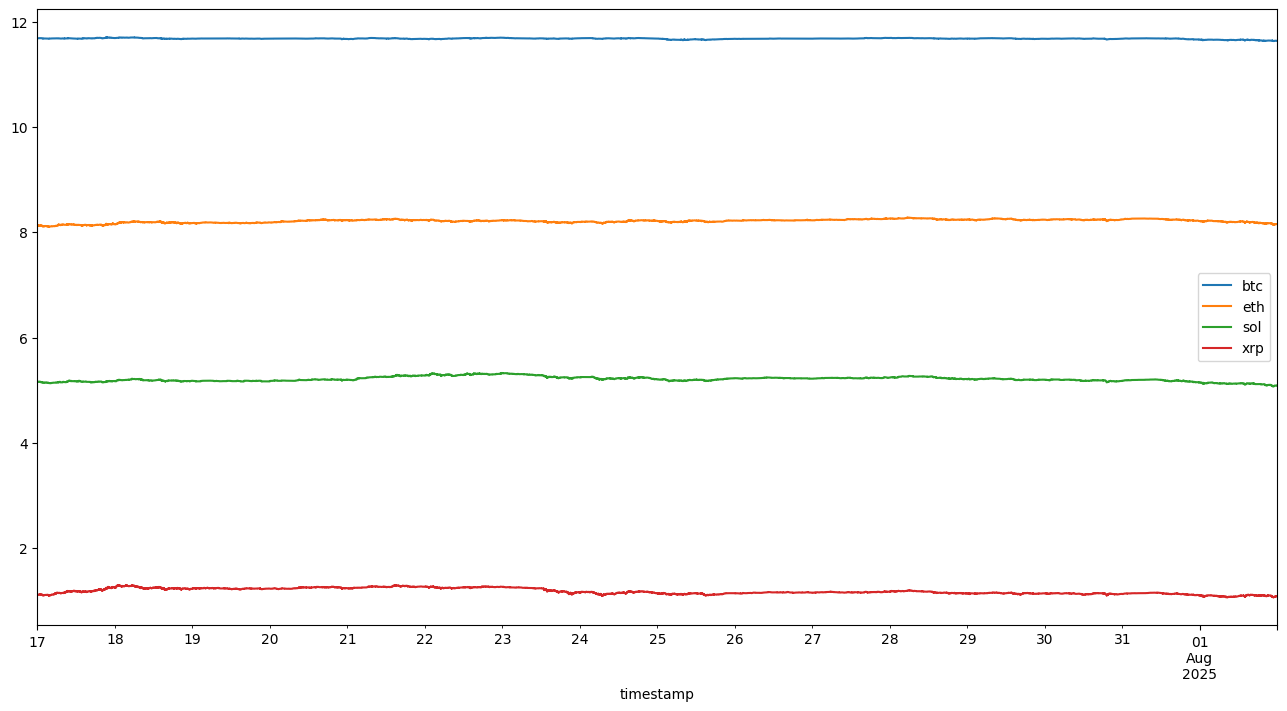

In [124]:
# Log transform price columns
price_cols = ['btc', 'eth', 'sol', 'xrp']
log_df = data_train.copy()
log_df[price_cols] = np.log(log_df[price_cols])

log_df[['btc', 'eth', 'sol', 'xrp']].plot(figsize=(16,8))

plt.show()

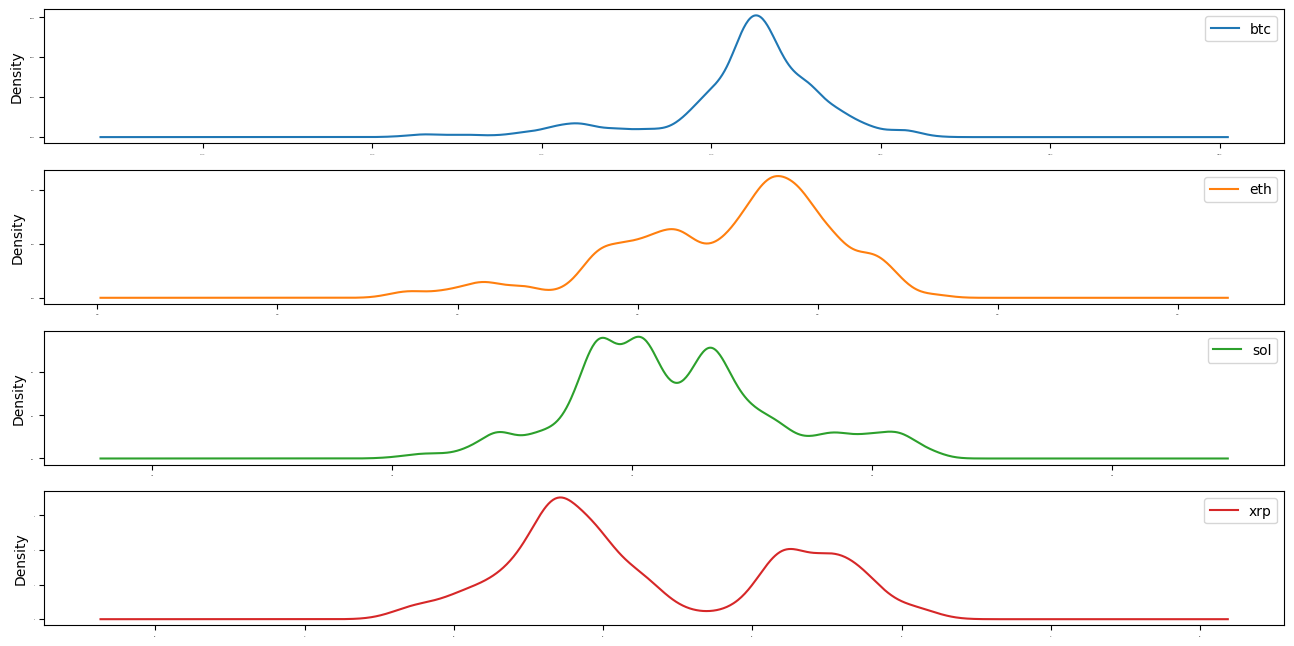

In [125]:
distribution(df=data_train[['btc', 'eth', 'sol', 'xrp']])

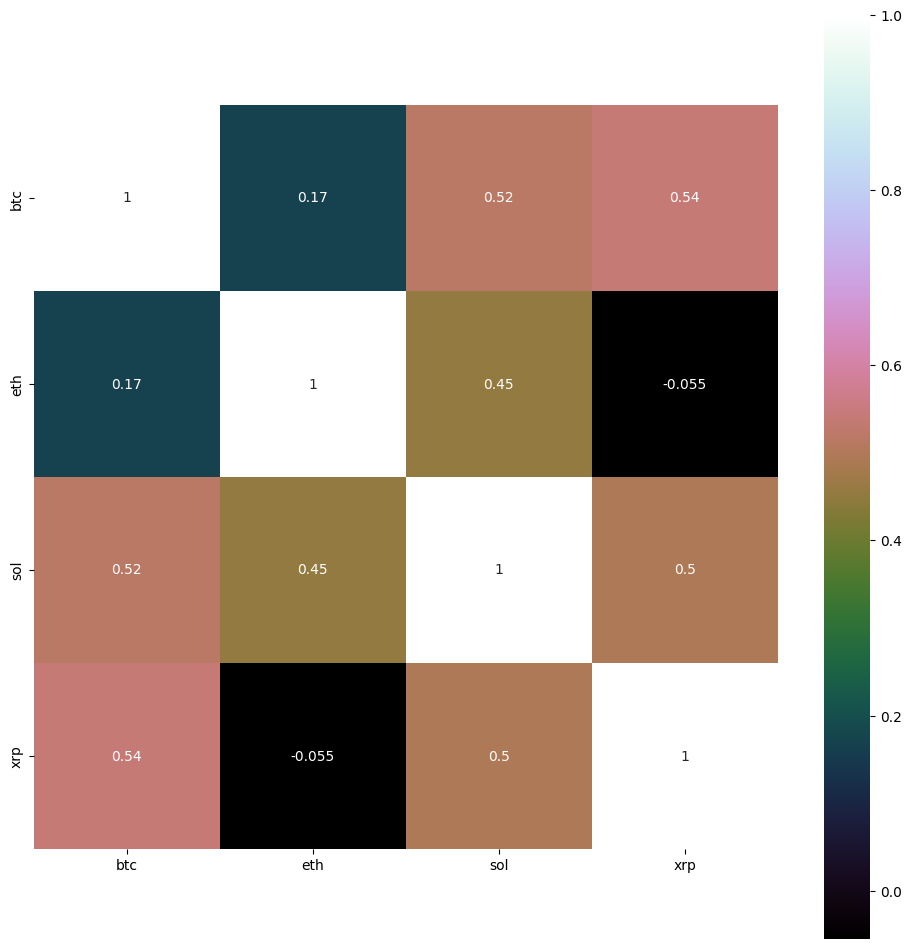

In [126]:
correlation(df=data_train[['btc', 'eth', 'sol', 'xrp']])

# 2. Cointegration Analysis

## 2.1. Stationarity Testing

In [127]:
# Stationarity Testing: ADF Test

from statsmodels.tsa.stattools import adfuller

def test_stationarity(df):
  adftest = adfuller(df)
  result = pd.Series(adftest[0:4],index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
  for key, value in adftest[4].items():
    result['Critical Value(%s)'%key] = value
  result = pd.DataFrame(result)
  return result

tickers = ['btc', 'eth', 'sol', 'xrp','^IRX']
for price in tickers[:-1]:
  if price == tickers[0]:
    adf_test = test_stationarity(data_train[price])
  else: 
    adf_test = pd.concat([adf_test, test_stationarity(data_train[price])], axis=1)

adf_test.columns = tickers[:-1]
adf_test = adf_test.T

adf_test

# all stock prices are non-stationary


,Test Statistic,p-value,Lags Used,Number of Observations Used,Critical Value(1%),Critical Value(5%),Critical Value(10%)
btc,-1.803640,0.378656,46.0,22993.0,-3.430634,-2.861666,-2.566837
eth,-2.790433,0.059653,2.0,23037.0,-3.430634,-2.861665,-2.566837
sol,-1.223597,0.663363,0.0,23039.0,-3.430634,-2.861665,-2.566837
xrp,-1.506630,0.530229,11.0,23028.0,-3.430634,-2.861666,-2.566837


## 2.2. Cointegration Analysis on Log of Price Series

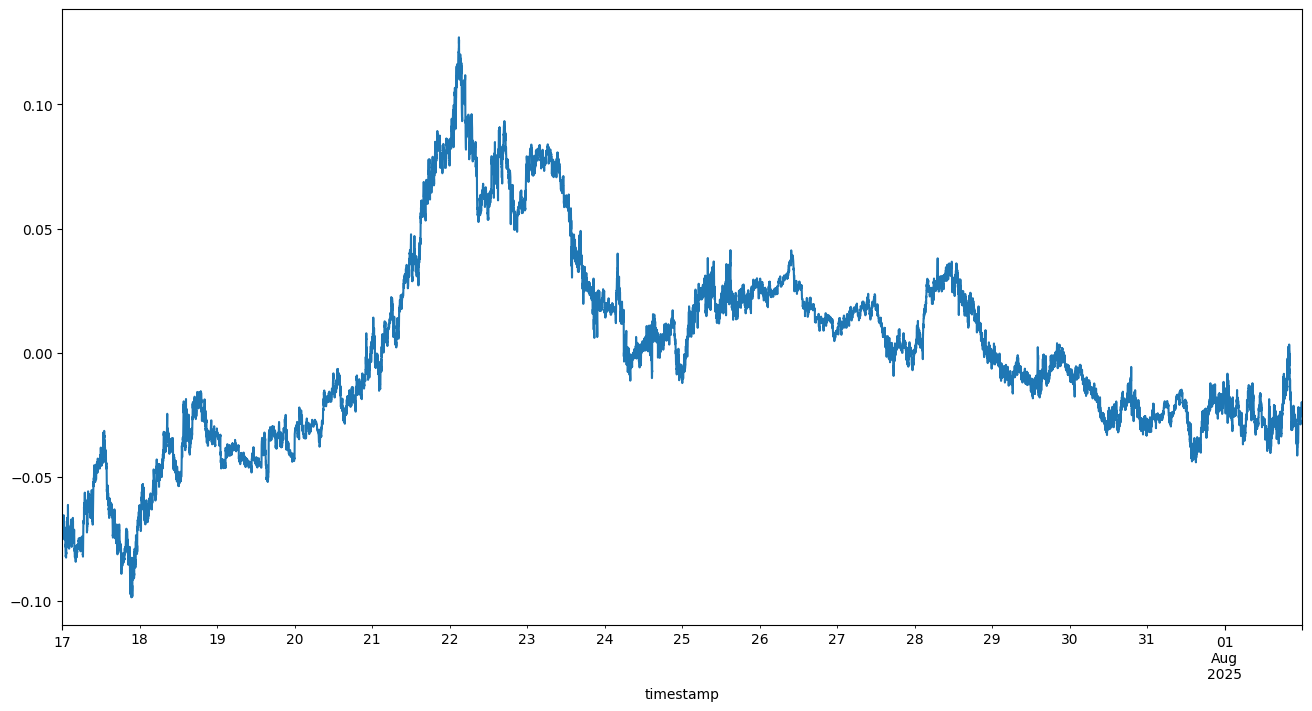

In [128]:
# Engle-Granger Two Step Procedure 1: Estimate the Cointegration Relation

def linear_OLS(x_arr, y_arr):
  x_avg = x_arr.mean()
  y_avg = y_arr.mean()
  s_xy = (x_arr-x_avg)*(y_arr-y_avg).T
  s_x = (x_arr-x_avg)*(x_arr-x_avg).T
  beta_1 = s_xy.sum()/s_x.sum()
  beta_0 = y_avg-beta_1*x_avg
  resid = y_arr - beta_0 - beta_1 * x_arr
  return beta_1, beta_0, resid

# A Demo: 
beta_1, beta_0, spread = linear_OLS(np.log(data_train['btc']), np.log(data_train['sol']))
spread.plot(figsize=(16,8))
plt.show()

In [129]:
# Engle-Granger Two Step Procedure 2: Test for Stationarity of the Residual

adf_test_spread = test_stationarity(spread)
adf_test_spread = adf_test_spread.T
adf_test_spread

,Test Statistic,p-value,Lags Used,Number of Observations Used,Critical Value(1%),Critical Value(5%),Critical Value(10%)
0,-2.088468,0.249177,30.0,23009.0,-3.430634,-2.861666,-2.566837


## 2.3. Cointegrated Pairs Selection

In [130]:
import itertools

In [131]:
# Select pairs with the most significant cointegration (ADF p-value < 0.1)

p_values = []

for pair in itertools.combinations(tickers[:-1], 2):
  beta_1, beta_0, spread = linear_OLS(np.log(data_train[pair[0]]), np.log(data_train[pair[1]]))
  p_value = test_stationarity(spread).iloc[1, 0]
  p_values.append(p_value)

pair_p_value = pd.DataFrame({'p-value': p_values}, index=itertools.combinations(tickers[:-1], 2))
selected_pairs = pair_p_value[pair_p_value['p-value'] < 0.1]
selected_pairs.index

Index([('btc', 'eth')], dtype='object')

In [132]:
pair_p_value = pd.DataFrame({'p-value': p_values}, index=itertools.combinations(tickers[:-1], 2))
selected_pairs = pair_p_value[pair_p_value['p-value'] < 0.4]
selected_pairs.index

Index([('btc', 'eth'), ('btc', 'sol'), ('btc', 'xrp')], dtype='object')

In [133]:
selected_pairs


,p-value
"(btc, eth)",0.054697
"(btc, sol)",0.249177
"(btc, xrp)",0.254522


In [134]:
# Construct the new data set for selected pairs
pair_BTC_ETH_train = data_train[['btc', 'eth']]
pair_BTC_SOL_train = data_train[['btc', 'sol']]
pair_BTC_XRP_train = data_train[['btc', 'xrp']]
pair_ETH_XRP_train = data_train[['eth', 'xrp']]
pair_SOL_XRP_train = data_train[['sol', 'xrp']]
pair_ETH_SOL_train = data_train[['eth', 'sol']]

pair_BTC_ETH_test = data_test[['btc', 'eth']]
pair_BTC_SOL_test = data_test[['btc', 'sol']]
pair_BTC_XRP_test = data_test[['btc', 'xrp']]
pair_ETH_XRP_test = data_test[['eth', 'xrp']]
pair_SOL_XRP_test = data_test[['sol', 'xrp']]
pair_ETH_SOL_test = data_test[['eth', 'sol']]

# 3. Kalman Filter

In [135]:
df_demo_train = pair_BTC_XRP_train

In [136]:
df_demo_train.head()

,btc,xrp
timestamp,,
2025-07-17 00:00:00,118705.0,3.0466
2025-07-17 00:01:00,118738.0,3.0410
2025-07-17 00:02:00,118724.0,3.0410
2025-07-17 00:03:00,118729.0,3.0410
2025-07-17 00:04:00,118719.0,3.0449


In [137]:
df_demo_train.shape[0]


23040

## 3.1. Initializing betas with Historical Regression Coefficients

In [139]:
# The first j = 1000 data are used to initialize betas
j = 1000

In [142]:
def initialize_beta(df, j=1000):
  beta_1, beta_0, initial_spread = linear_OLS(np.log(df.iloc[:j, 0]), np.log(df.iloc[:j, 1]))
  return beta_1, beta_0

## 3.2. Kalman Filter and Hedge Ratio Estimate

In [144]:
# Initialization

beta_1, beta_0 = initialize_beta(df_demo_train)

df_demo_train['Predicted Beta 0'] = beta_0
df_demo_train['Predicted Beta 1'] = beta_1
df_demo_train['Innovation'] = 0.0

R = np.array([0.001]).reshape(1, 1)
# Initializing R (constant Measurement Uncertainty)

P = np.zeros((2, 2))
# Initializing P (Estimate Uncertainty)

delta = 0.0001

Q = delta / (1 - delta) * np.diag([1, 1]) 
# Initializing Q (Constant Process Noise Uncertainty)

I = np.identity(2)

for t in range(j, df_demo_train.shape[0]-1):
  z = np.array([np.log(df_demo_train.iloc[:,1][t])]).reshape(1, 1)
  H = np.array([1, np.log(df_demo_train.iloc[:,0][t])]).reshape(1, 2)
  # Prediction
  ## 1. Extrapolate the state
  beta_old = np.array([df_demo_train['Predicted Beta 0'][t], df_demo_train['Predicted Beta 1'][t]]).reshape(2, 1)
  ## 2. Extrapolate uncertainty
  P = P + Q
  ## 3. Compute innovation
  prediction = np.matmul(H, beta_old)
  innovation = z - prediction
  df_demo_train['Innovation'][t] = innovation[0][0]

  # Update
  ## 4. Compute the Kalman Gain
  K = np.matmul(P, H.T) / (np.matmul(np.matmul(H, P), H.T) + R)
  ## 5. Update estimate with measurement
  beta_predict = beta_old + np.matmul(K, innovation)
  df_demo_train['Predicted Beta 0'][t+1], df_demo_train['Predicted Beta 1'][t+1] = beta_predict[0][0], beta_predict[1][0]
  ## 6. Update the estimate uncertainty
  P = np.matmul(np.matmul((I - np.matmul(K, H)), P), (I - np.matmul(K, H)).T) + np.matmul(np.matmul(K, R), K.T)

,btc,xrp,Predicted Beta 0,Predicted Beta 1,Innovation
timestamp,,,,,
2025-07-17 16:40:00,118481.0,3.2400,-2.007464,0.270413,0.023934
2025-07-17 16:41:00,118573.0,3.2560,-2.007301,0.272309,0.006337
2025-07-17 16:42:00,118630.0,3.2577,-2.007258,0.272813,0.000795
2025-07-17 16:43:00,118630.0,3.2568,-2.007253,0.272876,-0.000226
2025-07-17 16:44:00,118450.0,3.2571,-2.007254,0.272858,0.000492
...,...,...,...,...,...
2025-08-01 23:55:00,113267.0,2.9618,-2.033536,0.268210,-0.001963
2025-08-01 23:56:00,113339.0,2.9655,-2.033551,0.268054,0.000952
2025-08-01 23:57:00,113319.0,2.9588,-2.033552,0.268130,-0.002153


In [156]:
df_demo_train[j+5:]

,btc,xrp,Predicted Beta 0,Predicted Beta 1,Innovation
timestamp,,,,,
2025-07-17 16:45:00,118450.0,3.2568,-2.007251,0.272898,-0.000061
2025-07-17 16:46:00,118450.0,3.2555,-2.007251,0.272893,-0.000403
2025-07-17 16:47:00,118551.0,3.2612,-2.007254,0.272861,0.001491
2025-07-17 16:48:00,118551.0,3.2560,-2.007244,0.272979,-0.001501
2025-07-17 16:49:00,118551.0,3.2527,-2.007254,0.272860,-0.001110
...,...,...,...,...,...
2025-08-01 23:55:00,113267.0,2.9618,-2.033536,0.268210,-0.001963
2025-08-01 23:56:00,113339.0,2.9655,-2.033551,0.268054,0.000952
2025-08-01 23:57:00,113319.0,2.9588,-2.033552,0.268130,-0.002153


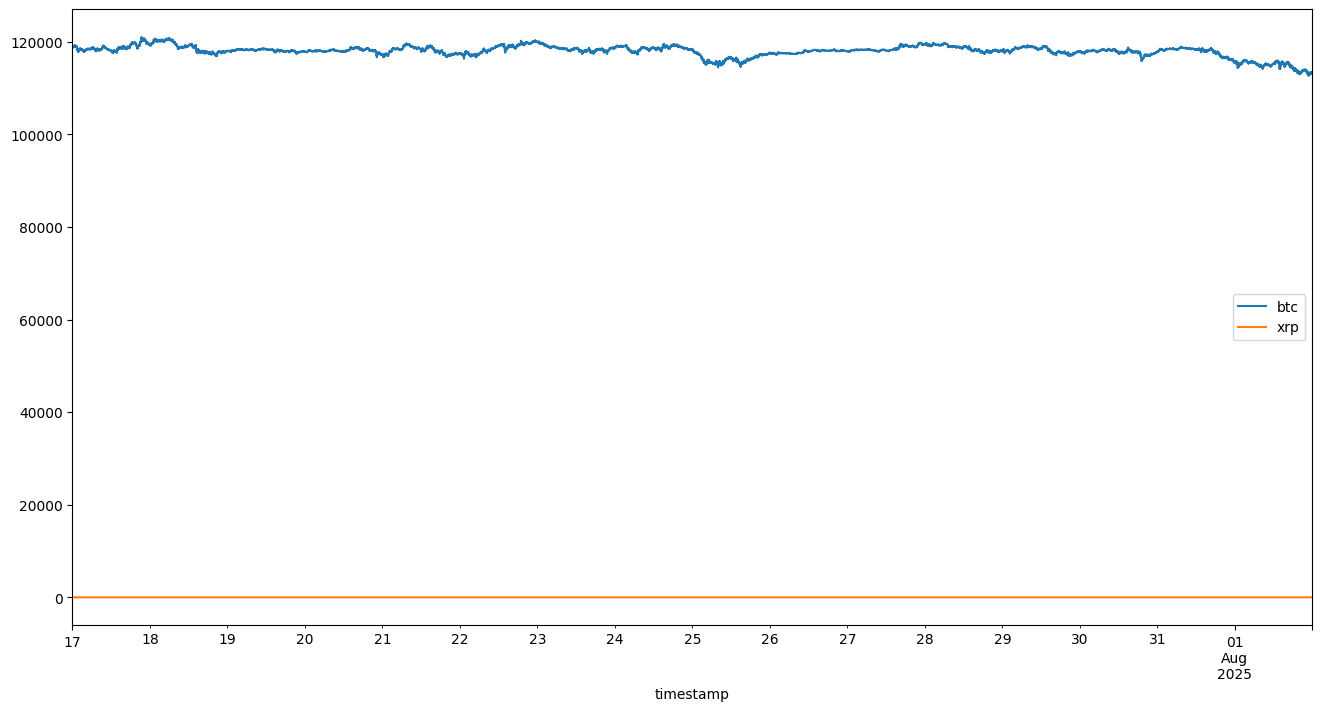

In [145]:
df_demo_train[['btc', 'xrp']].plot(figsize=(16,8))
plt.show()

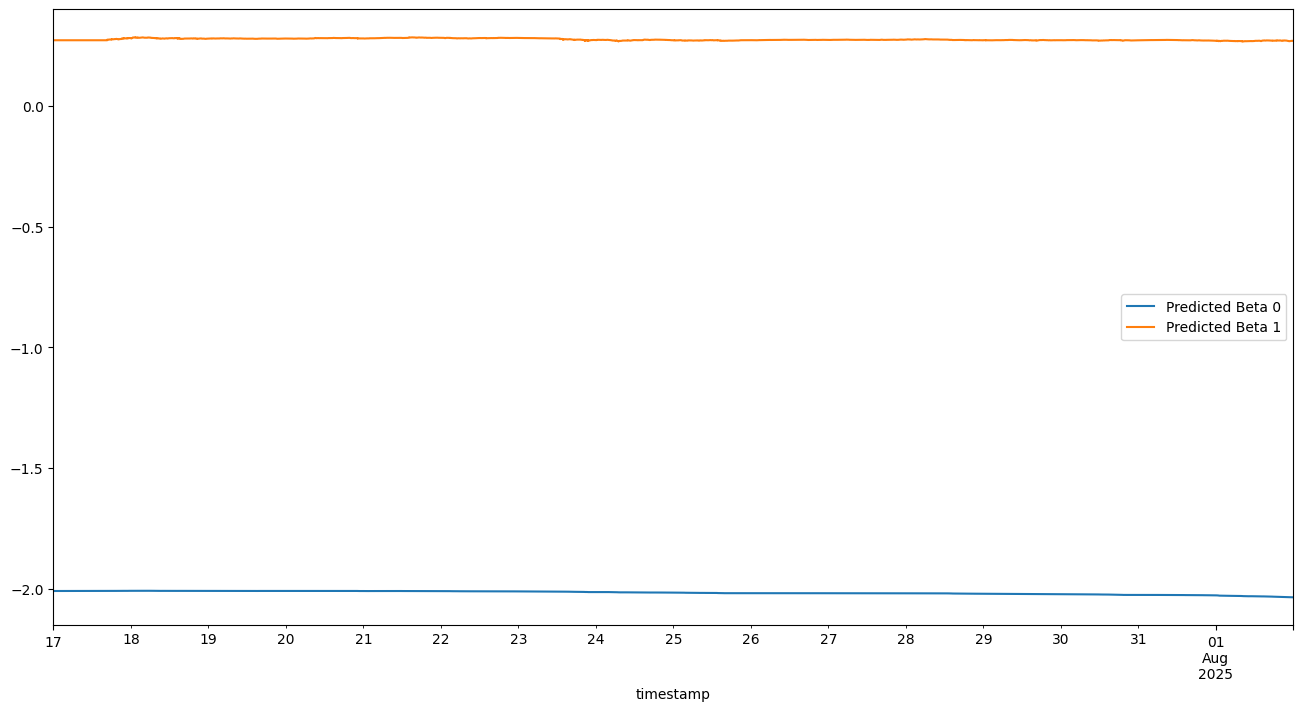

In [146]:
df_demo_train[['Predicted Beta 0', 'Predicted Beta 1']].plot(figsize=(16,8))
plt.show()

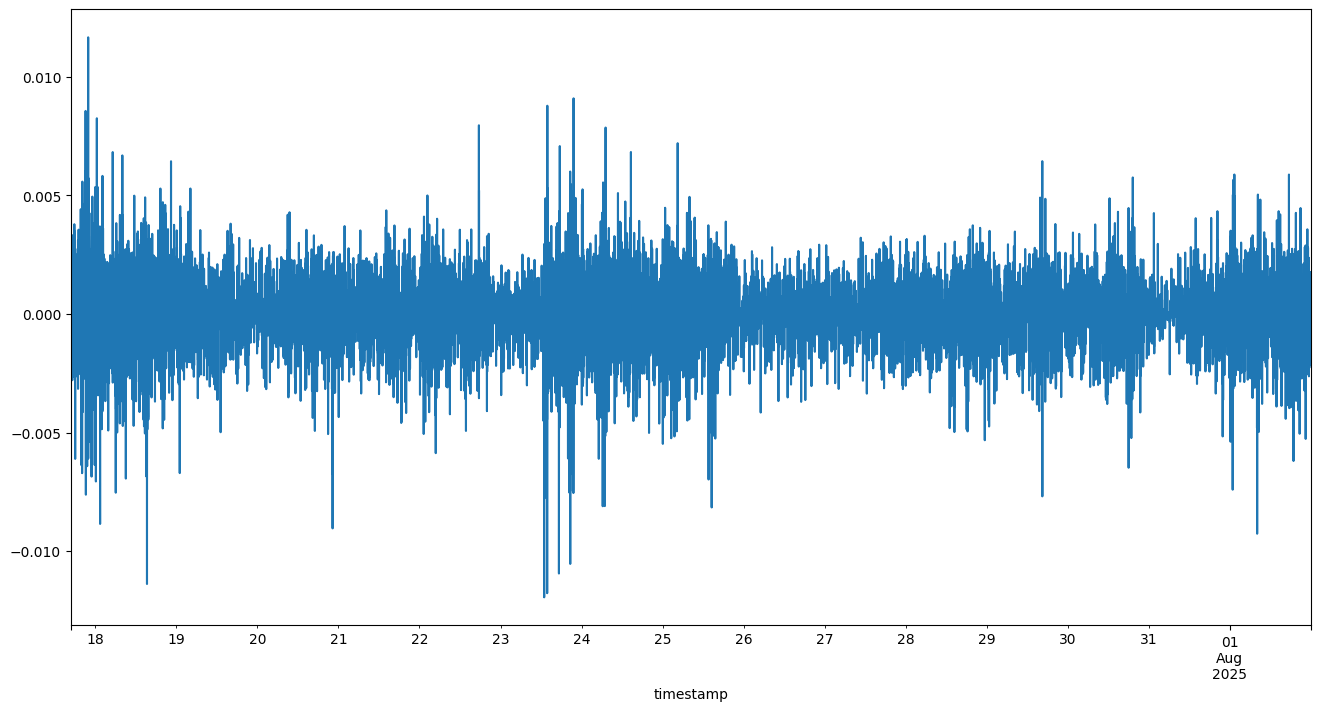

In [155]:
df_demo_train['Innovation'][j+5:].plot(figsize=(16,8))
plt.show()

## 3.3. Sensitivity Test to the Initialization Assumptions

In [157]:
# Initialization

beta_1, beta_0 = initialize_beta(df_demo_train)

df_demo_train['Predicted Beta 0 Test'] = beta_0
df_demo_train['Predicted Beta 1 Test'] = beta_1
df_demo_train['Innovation Test'] = 0.0

R = np.array([1]).reshape(1, 1)
# Initializing R (constant Measurement Uncertainty)

P = np.zeros((2, 2))
# Initializing P (Estimate Uncertainty)

delta = 0.1

Q = delta / (1 - delta) * np.diag([1, 1]) 
# Initializing Q (Constant Process Noise Uncertainty)

I = np.identity(2)

for t in range(j, df_demo_train.shape[0]-1):
  z = np.array([np.log(df_demo_train.iloc[:,1][t])]).reshape(1, 1)
  H = np.array([1, np.log(df_demo_train.iloc[:,0][t])]).reshape(1, 2)
  # Prediction
  ## 1. Extrapolate the state
  beta_old = np.array([df_demo_train['Predicted Beta 0 Test'][t], df_demo_train['Predicted Beta 1 Test'][t]]).reshape(2, 1)
  ## 2. Extrapolate uncertainty
  P = P + Q
  ## 3. Compute innovation
  prediction = np.matmul(H, beta_old)
  innovation = z - prediction
  df_demo_train['Innovation Test'][t] = innovation[0][0]

  # Update
  ## 4. Compute the Kalman Gain
  K = np.matmul(P, H.T) / (np.matmul(np.matmul(H, P), H.T) + R)
  ## 5. Update estimate with measurement
  beta_predict = beta_old + np.matmul(K, innovation)
  df_demo_train['Predicted Beta 0 Test'][t+1], df_demo_train['Predicted Beta 1 Test'][t+1] = beta_predict[0][0], beta_predict[1][0]
  ## 6. Update the estimate uncertainty
  P = np.matmul(np.matmul((I - np.matmul(K, H)), P), (I - np.matmul(K, H)).T) + np.matmul(np.matmul(K, R), K.T)

df_demo_train[j+5:]

,btc,xrp,Predicted Beta 0,Predicted Beta 1,Innovation,Predicted Beta 0 Test,Predicted Beta 1 Test,Innovation Test
timestamp,,,,,,,,
2025-07-17 16:45:00,118450.0,3.2568,-2.007251,0.272898,-0.000061,-2.007251,0.272898,-0.000063
2025-07-17 16:46:00,118450.0,3.2555,-2.007251,0.272893,-0.000403,-2.007251,0.272893,-0.000403
2025-07-17 16:47:00,118551.0,3.2612,-2.007254,0.272861,0.001491,-2.007254,0.272860,0.001493
2025-07-17 16:48:00,118551.0,3.2560,-2.007244,0.272979,-0.001501,-2.007244,0.272980,-0.001509
2025-07-17 16:49:00,118551.0,3.2527,-2.007254,0.272860,-0.001110,-2.007254,0.272859,-0.001102
...,...,...,...,...,...,...,...,...
2025-08-01 23:55:00,113267.0,2.9618,-2.033536,0.268210,-0.001963,-2.033745,0.268229,-0.001973
2025-08-01 23:56:00,113339.0,2.9655,-2.033551,0.268054,0.000952,-2.033759,0.268071,0.000963
2025-08-01 23:57:00,113319.0,2.9588,-2.033552,0.268130,-0.002153,-2.033760,0.268149,-0.002158


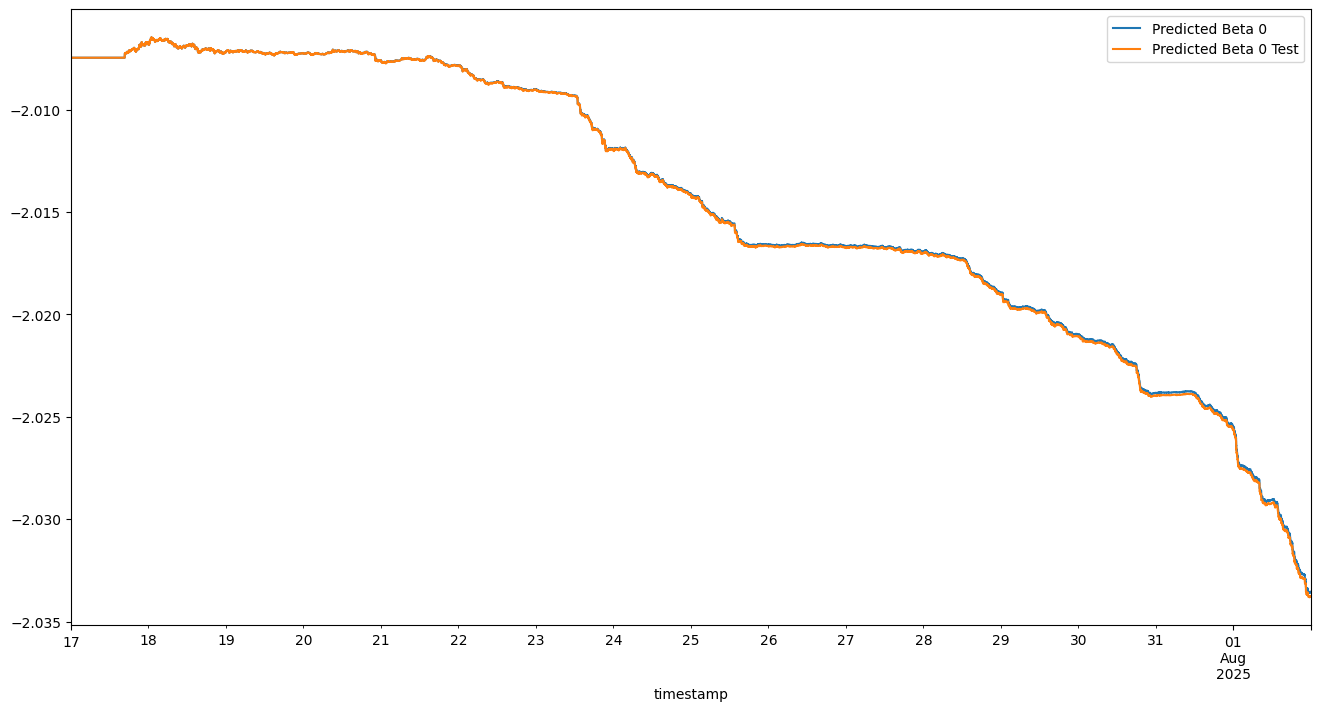

In [158]:
df_demo_train[['Predicted Beta 0', 'Predicted Beta 0 Test']].plot(figsize=(16,8))
plt.show()

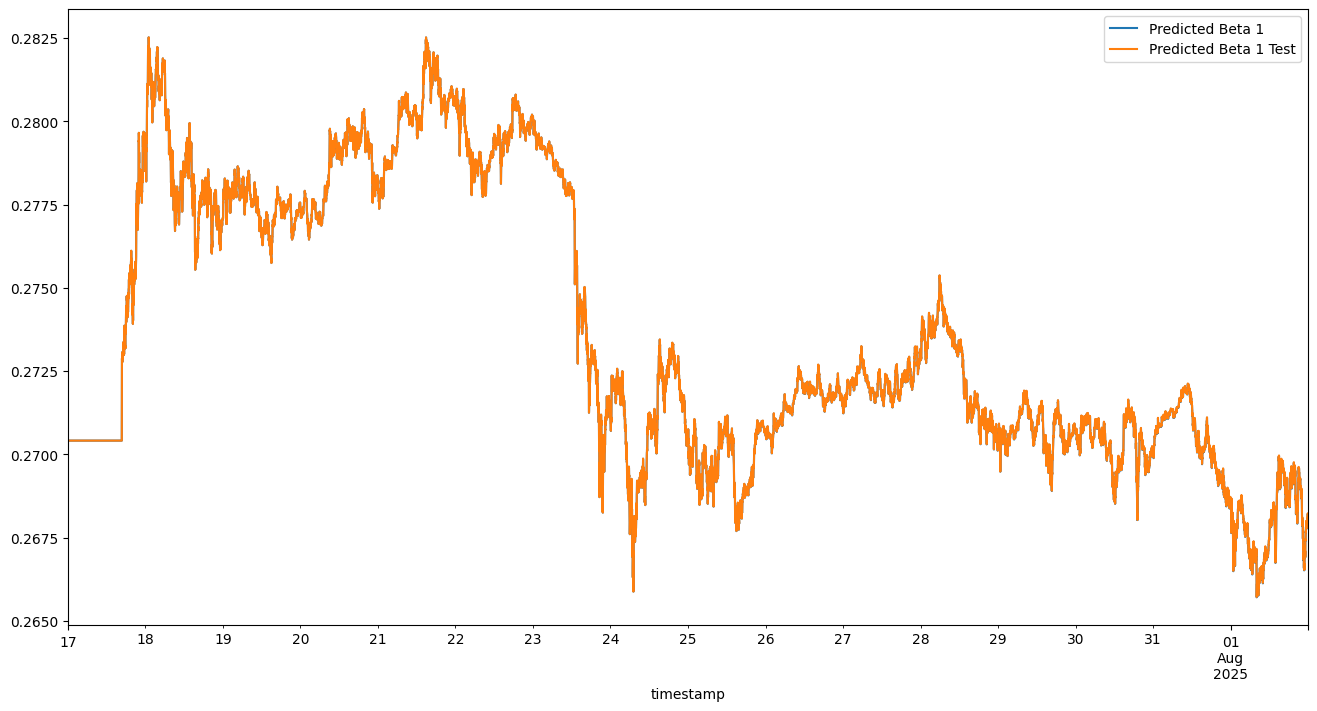

In [159]:
df_demo_train[['Predicted Beta 1', 'Predicted Beta 1 Test']].plot(figsize=(16,8))
plt.show()

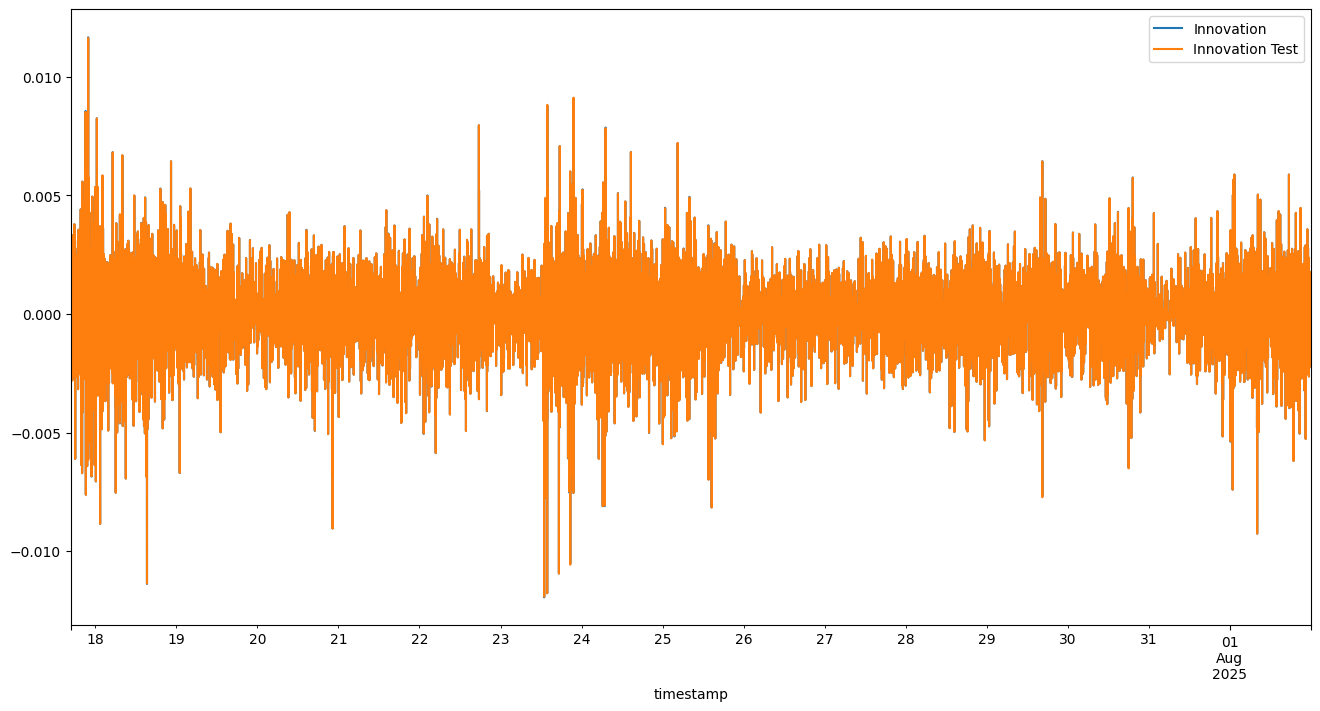

In [160]:
df_demo_train[['Innovation', 'Innovation Test']][j+5:].plot(figsize=(16,8))
plt.show()

In [161]:
df_demo_train = df_demo_train.drop(['Predicted Beta 0 Test', 'Predicted Beta 1 Test', 'Innovation Test'], axis=1)

# 4. Data-Driven Innovation Volatility Forecast

## 4.1. A Demo for t = 2000

In [236]:
# A demo for t = 2000
s = 2000    # Current time index
k = 1000    # Window length for DDIVF calculation
l = 200     # Initialization length for S

# last k observations prior to time s (excluding s) to build the volatility forecast.
w = df_demo_train['Innovation'].iloc[s-k:s].values 
# rho: Correlation between centered innovations and their signs — acts as a scaling factor for volatility.
rho = np.corrcoef(w - w.mean(), np.sign(w - w.mean()))[0, 1]

# V represents a raw volatility measure, adjusted by ρ.
V = abs(w - w.mean()) / rho 

S = np.zeros(k)
S[0] = V[:l].mean() # initializing

# optimize alpha
alpha_values = np.arange(0.01, 0.5, 0.01)
min_fess = 999999999.9
alpha_opt = None


# Test α values between 0.01 and 0.49.
# For each α, compute the smoothed series S.
# FESS (Forecast Error Sum of Squares) is calculated from l onward.
# Optimal α minimizes FESS.
for alpha in alpha_values:
  for i in range(1, k):
    S[i] = alpha * V[i] + (1 - alpha) * S[i-1]
  fess = np.sum(np.square(np.subtract(V[l:], S[l-1:-1])))
  if fess < min_fess:
    min_fess = fess
    alpha_opt = alpha

# Recalculate S using the optimal α.
for i in range(1, k):
  S[i] = alpha_opt * V[i] + (1 - alpha_opt) * S[i-1]

ddivf = S[k-1]

print(alpha_opt, ddivf)

0.07 0.002630781131966141


## 4.2. Kalman Filter with Data-Driven Innovation Volatility

In [163]:
# Initialization

beta_1, beta_0 = initialize_beta(df_demo_train)

df_demo_train['Predicted Beta 0'] = beta_0
df_demo_train['Predicted Beta 1'] = beta_1
df_demo_train['Innovation'] = 0.0
df_demo_train['DDIVF'] = 0.0

R = np.array([0.001]).reshape(1, 1)
# Initializing R (constant Measurement Uncertainty)

P = np.zeros((2, 2))
# Initializing P (Estimate Uncertainty)

delta = 0.0001

Q = delta / (1 - delta) * np.diag([1, 1]) 
# Initializing Q (Constant Process Noise Uncertainty)

I = np.identity(2)

for t in range(j, df_demo_train.shape[0]-1):
  z = np.array([np.log(df_demo_train.iloc[:,1][t])]).reshape(1, 1)
  H = np.array([1, np.log(df_demo_train.iloc[:,0][t])]).reshape(1, 2)
  # Prediction
  ## 1. Extrapolate the state
  beta_old = np.array([df_demo_train['Predicted Beta 0'][t], df_demo_train['Predicted Beta 1'][t]]).reshape(2, 1)
  ## 2. Extrapolate uncertainty
  P = P + Q
  ## 3. Compute innovation
  prediction = np.matmul(H, beta_old)
  innovation = z - prediction
  df_demo_train['Innovation'][t] = innovation[0][0]
  ## 4. Compute ddivf
  k = 1000
  l = 200
  if t > j + k:
    w = df_demo_train['Innovation'].iloc[t-k:t].values
    rho = np.corrcoef(w - w.mean(), np.sign(w - w.mean()))[0, 1]
    V = abs(w - w.mean()) / rho
    S = np.zeros(k)
    S[0] = V[:l].mean()
    alpha_values = np.arange(0, 0.5, 0.01)
    min_fess = 999999999.9
    alpha_opt = None
    for alpha in alpha_values:
      for i in range(1, k):
        S[i] = alpha * V[i] + (1 - alpha) * S[i-1]
      fess = np.sum(np.square(np.subtract(V[l:], S[l-1:-1])))
      if fess < min_fess:
        min_fess = fess
        alpha_opt = alpha
    for i in range(1, k):
      S[i] = alpha_opt * V[i] + (1 - alpha_opt) * S[i-1]
    ddivf = S[-1]
    df_demo_train['DDIVF'][t] = ddivf

  # Update
  ## 5. Compute the Kalman Gain
  K = np.matmul(P, H.T) / (np.matmul(np.matmul(H, P), H.T) + R)
  ## 6. Update estimate with measurement
  beta_predict = beta_old + np.matmul(K, innovation)
  df_demo_train['Predicted Beta 0'][t+1], df_demo_train['Predicted Beta 1'][t+1] = beta_predict[0][0], beta_predict[1][0]
  ## 7. Update the estimate uncertainty
  P = np.matmul(np.matmul((I - np.matmul(K, H)), P), (I - np.matmul(K, H)).T) + np.matmul(np.matmul(K, R), K.T)

df_demo_train[j+k:]

,btc,xrp,Predicted Beta 0,Predicted Beta 1,Innovation,DDIVF
timestamp,,,,,,
2025-07-18 09:20:00,118820.0,3.4240,-2.006973,0.277269,-0.002211,0.000000
2025-07-18 09:21:00,118820.0,3.4154,-2.006988,0.277093,-0.002656,0.002573
2025-07-18 09:22:00,118828.0,3.4184,-2.007006,0.276882,0.000690,0.002708
2025-07-18 09:23:00,118828.0,3.4184,-2.007002,0.276937,0.000044,0.002565
2025-07-18 09:24:00,118828.0,3.4184,-2.007001,0.276941,0.000003,0.002361
...,...,...,...,...,...,...
2025-08-01 23:55:00,113267.0,2.9618,-2.033536,0.268210,-0.001963,0.000819
2025-08-01 23:56:00,113339.0,2.9655,-2.033551,0.268054,0.000952,0.000953
2025-08-01 23:57:00,113319.0,2.9588,-2.033552,0.268130,-0.002153,0.000983


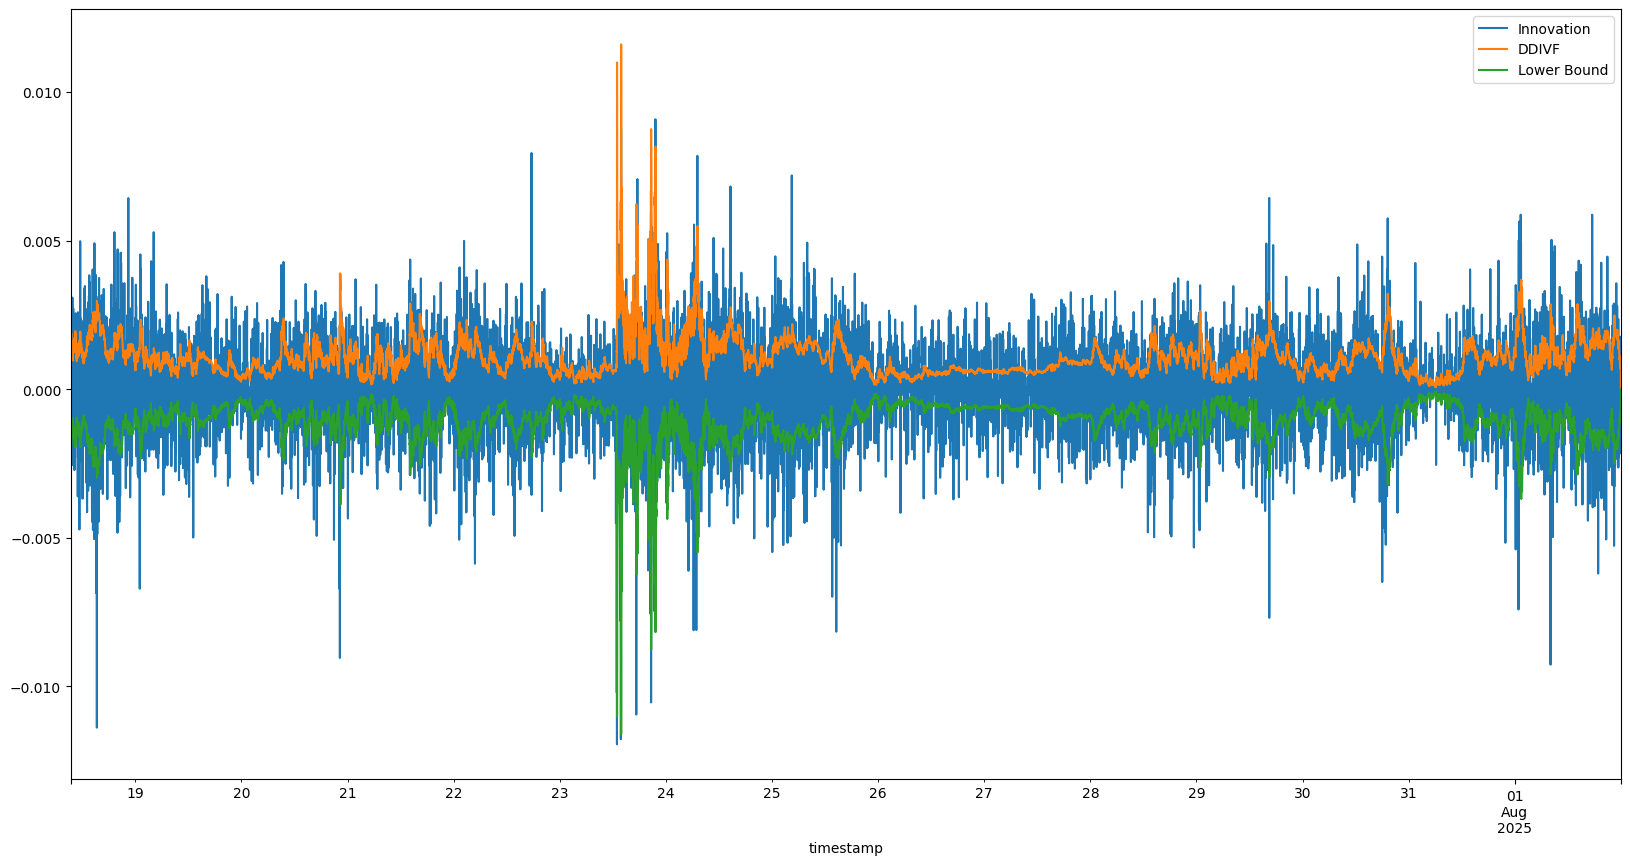

In [166]:
demo1 = df_demo_train.iloc[j+k+5:][['Innovation', 'DDIVF']]
demo1.rename(columns={'DDIVF': 'Upper Bound'})
demo1['Lower Bound'] = - demo1['DDIVF']
demo1.plot(figsize=(20,10))
plt.show()
     

# 5. Regime Detection with Hidden Markov Model

In [167]:
df_demo_train['H Return'] = np.log1p(df_demo_train.iloc[:,0].pct_change())
df_demo_train['z Return'] = np.log1p(df_demo_train.iloc[:,1].pct_change())

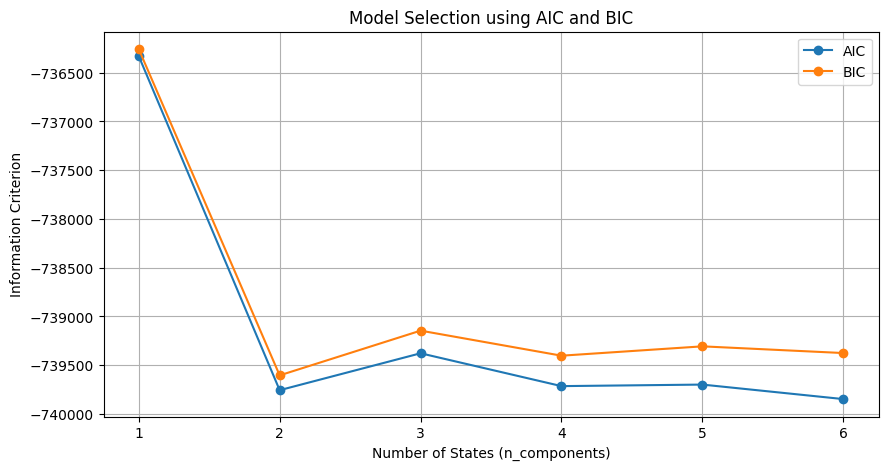

Best number of states by BIC: 2


In [168]:
# Range of components to test (e.g., 2 to 6 states)
n_components_range = range(1, 7)

aic_scores = []
bic_scores = []
models = []

# The input data for HMM
X = df_demo_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values

# Loop over number of components
for n in n_components_range:
    model = mix.GaussianMixture(
        n_components=n, 
        covariance_type="full", 
        n_init=100, 
        random_state=7
    )
    model.fit(X)
    
    aic_scores.append(model.aic(X))
    bic_scores.append(model.bic(X))
    models.append(model)

# Plot AIC and BIC
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.xlabel('Number of States (n_components)')
plt.ylabel('Information Criterion')
plt.title('Model Selection using AIC and BIC')
plt.legend()
plt.grid(True)
plt.show()

# Choose best model (e.g., by BIC)
best_index = np.argmin(bic_scores)  # or use aic_scores
best_model = models[best_index]
print(f"Best number of states by BIC: {n_components_range[best_index]}")

# Apply the best model to assign states
df_demo_train['State'] = np.nan
df_demo_train.loc[df_demo_train.index[j+5:-1], 'State'] = best_model.predict(X)

In [ ]:
# # Manually set the number of states
# df_demo_train['State'] = np.nan
# X = df_demo_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values
# hmm = mix.GaussianMixture(n_components=3, covariance_type="full", n_init=100, random_state=7).fit(X)
# df_demo_train['State'][j+5:-1] = hmm.predict(X = df_demo_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)

# df_demo_train[j+5:]

In [169]:
regime = df_demo_train.groupby("State")["Innovation"].agg(mean_abs_innovation=lambda x: x.abs().mean(),count="count")
print(regime)

       mean_abs_innovation  count
State                            
0.0               0.004813    398
1.0               0.000607  21636


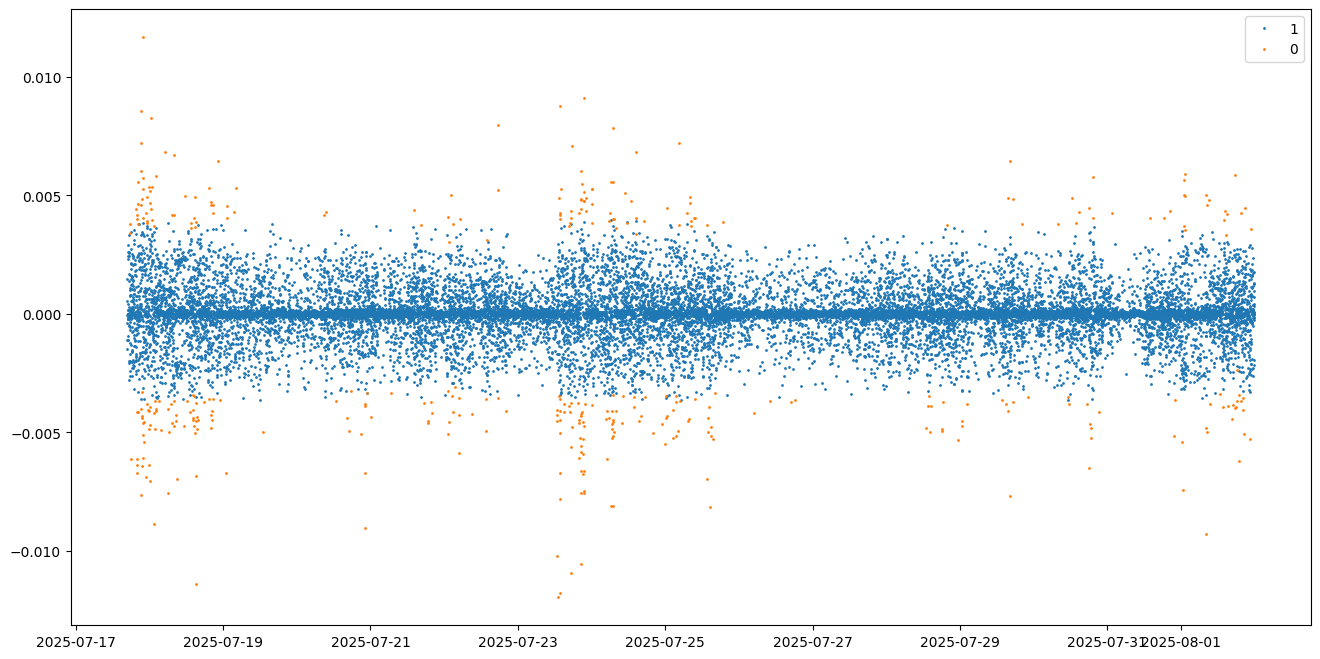

In [170]:
Z = best_model.predict(X)
states = pd.unique(Z)

plt.figure(figsize = (16, 8))
for i in states:
  want = (Z == i)
  x = df_demo_train[j+5:-1].index.values[want]
  y = df_demo_train[j+5:-1]['Innovation'].iloc[want]
  plt.plot(x, y, '.',markersize=2)
plt.legend(states)
plt.show()

# 6. Thresholds Optimization and Training Set Performance

In [171]:
# Setting
E0 = 100000.0
W0 = 1000000.0
epsilon = 0.0005
delta_r = 0
Delta_max = 2

## 6.1. Trading Simulation: In-Sample

In [172]:
# Incorporate Daily Fed Funds Rate
df_demo_train = df_demo_train.join(data_train['Daily RF Rate'])

In [91]:
df_demo_train = df_demo_train.drop('Daily RF Rate', axis=1)

In [181]:
df_demo_train[j+k+5:]

,btc,xrp,Predicted Beta 0,Predicted Beta 1,Innovation,DDIVF,H Return,z Return,State,Daily RF Rate
timestamp,,,,,,,,,,
2025-07-18 09:25:00,118696.0,3.4184,-2.007001,0.276941,0.000308,0.002178,-0.001111,0.000000,1.0,0.000114
2025-07-18 09:26:00,118669.0,3.4217,-2.006999,0.276965,0.001048,0.002033,-0.000227,0.000965,1.0,0.000114
2025-07-18 09:27:00,118669.0,3.4217,-2.006992,0.277049,0.000067,0.001985,0.000000,0.000000,1.0,0.000114
2025-07-18 09:28:00,118669.0,3.4217,-2.006991,0.277054,0.000004,0.001830,0.000000,0.000000,1.0,0.000114
2025-07-18 09:29:00,118694.0,3.4320,-2.006991,0.277054,0.002948,0.001690,0.000211,0.003006,1.0,0.000114
...,...,...,...,...,...,...,...,...,...,...
2025-08-01 23:55:00,113267.0,2.9618,-2.033536,0.268210,-0.001963,0.000819,-0.000053,-0.002091,1.0,0.000112
2025-08-01 23:56:00,113339.0,2.9655,-2.033551,0.268054,0.000952,0.000953,0.000635,0.001248,1.0,0.000112
2025-08-01 23:57:00,113319.0,2.9588,-2.033552,0.268130,-0.002153,0.000983,-0.000176,-0.002262,1.0,0.000112


Number of Trades: 3
Hit Rate: 0.3333333333333333
Average Win: 1021.8272463126797
Average Loss: 546.2507282611659
Average Return: 0.005623319222416158
Sharpe Ratio: 0.1950805684272453


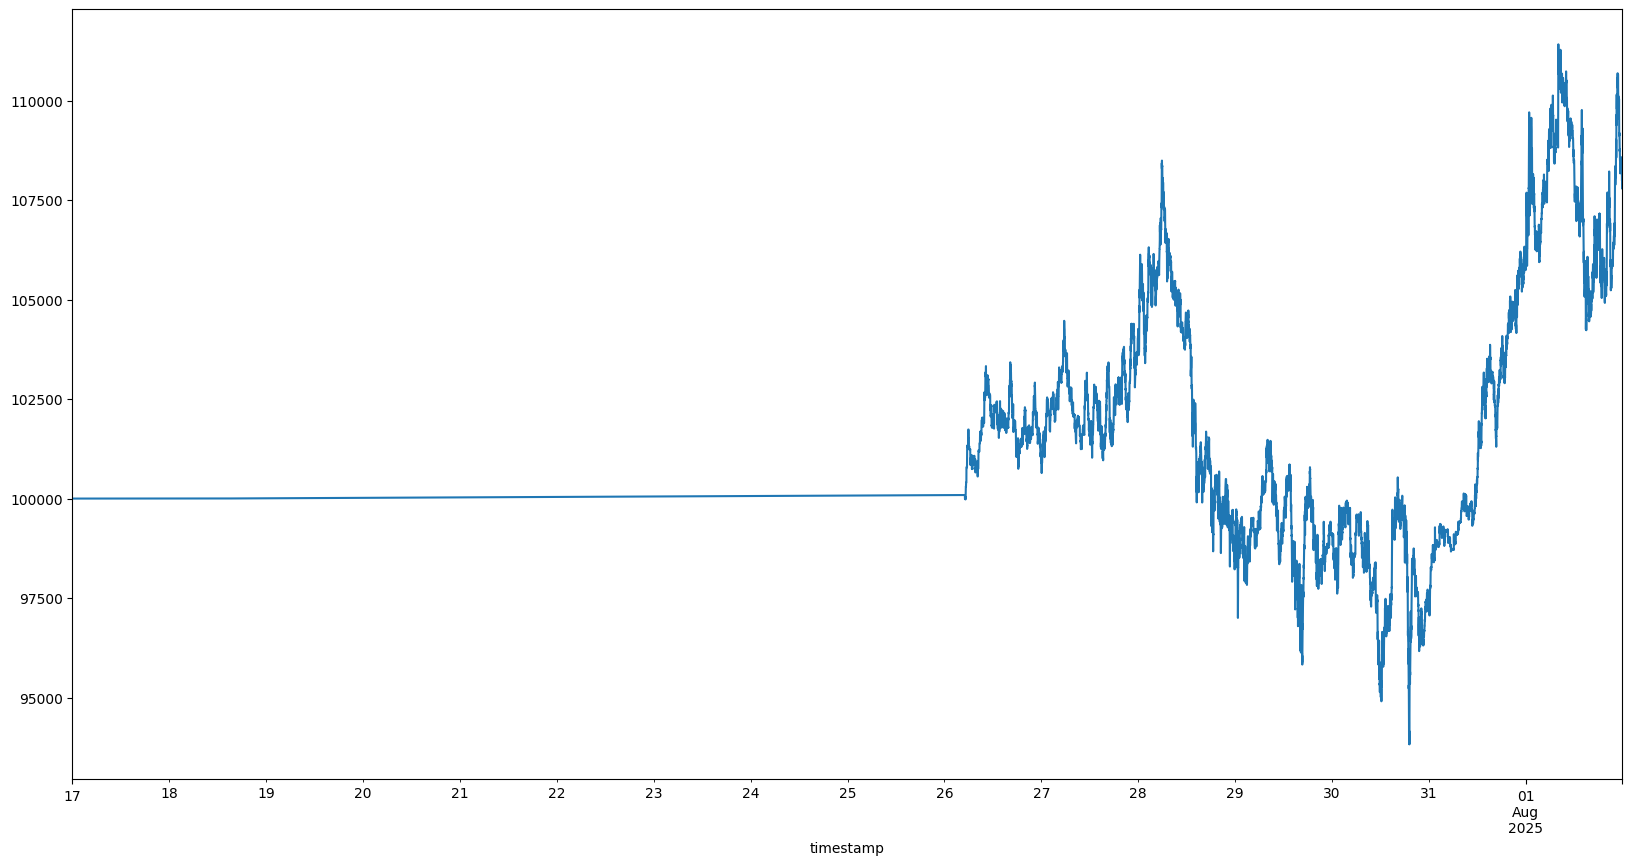

In [184]:
# Let me first demostrate the trading strategy and fix the thresholds to be 3.
init = j+k+5
p_S0 = 15
p_S1 = 15
p_S2 = 15

df_demo_train['Investment in H'] = 0.0
df_demo_train['Investment in z'] = 0.0
df_demo_train['Signal'] = 0
df_demo_train['Strategy Instant PnL'] = 0.0
df_demo_train['Strategy'] = E0
df_demo_train['Strategy Instant Return'] = 0.0
df_demo_train['Cash'] = W0 - E0

number_of_successes = 0
number_of_failures = 0
total_win = 0.0
total_loss = 0.0
cum_pnl = 0
Q_z_begin = 0
Q_H_begin = 0

for t in range(j + k + 5, df_demo_train.shape[0] - 1):
  # Starts after the fifth iteration to make the KF stablized.

  ## GENERATING SIGNALS
  if df_demo_train['State'][t] == 0:
      p_now = p_S0
  elif df_demo_train['State'][t] == 1:
      p_now = p_S1
  elif df_demo_train['State'][t] == 2:
      p_now = p_S2
  if df_demo_train['State'][t - 1] == 0:
      p_past = p_S0
  elif df_demo_train['State'][t - 1] == 1:
      p_past = p_S1
  elif df_demo_train['State'][t - 1] == 2:
      p_past = p_S2

  # Note the position would close in one day
  if df_demo_train['Innovation'][t] < p_now * df_demo_train['DDIVF'][t] and df_demo_train['Innovation'][
      t - 1] > p_past * df_demo_train['DDIVF'][t - 1]:
      signal = -1
  elif df_demo_train['Innovation'][t] > -p_now * df_demo_train['DDIVF'][t] and df_demo_train['Innovation'][
      t - 1] < -p_past * df_demo_train['DDIVF'][t - 1]:
      signal = 1
  else:
      signal = 0
  df_demo_train['Signal'][t] = signal

  ## GENERATE Instant PNL
  E = df_demo_train['Strategy'][t]
  # Refill if falls below zero
  if E < 0:
      refill = min(E0 - E, df_demo_train['Cash'][t])
      df_demo_train['Cash'][t] = df_demo_train['Cash'][t] - refill
      E = df_demo_train['Strategy'][t] + refill
  df_demo_train['Cash'][t + 1] = df_demo_train['Cash'][t]
  r = df_demo_train['Daily RF Rate'][t] / (24 * 60)
  hedge_ratio = df_demo_train['Predicted Beta 1'][t]
  R_z = (df_demo_train.iloc[:, 1][t] / df_demo_train.iloc[:, 1][t - 1]) - 1
  R_H = (df_demo_train.iloc[:, 0][t] / df_demo_train.iloc[:, 0][t - 1]) - 1
  Q_z = df_demo_train['Investment in z'][t - 1]
  Q_H = df_demo_train['Investment in H'][t - 1]

  # funding cost is imposed on the date trade is executed. It isn't imposed when clearing
  if signal == 0:
      # Not trade, but change value of position
      Q_z_new = Q_z * (1 + R_z)
      Q_H_new = Q_H * (1 + R_H)
      df_demo_train['Investment in z'][t] = Q_z_new
      df_demo_train['Investment in H'][t] = Q_H_new
      instant_pnl = (Q_z * R_z + Q_H * R_H) + r * (E - Q_z_begin - Q_H_begin) - delta_r * (
                  abs(Q_z_begin) + abs(Q_H_begin))
      cum_pnl += instant_pnl
      df_demo_train['Strategy Instant PnL'][t] = instant_pnl


  elif signal != 0:
      # Clearing & Trade the minimum of $200,000 and maximum leverage
      Q_z_new = min(200000.0, Delta_max * E) / (1 + hedge_ratio) * signal
      Q_H_new = -Q_z_new * hedge_ratio
      df_demo_train['Investment in z'][t] = Q_z_new
      df_demo_train['Investment in H'][t] = Q_H_new
      Q_z_begin = Q_z_new
      Q_H_begin = Q_H_new
      instant_pnl = ((Q_z * R_z + Q_H * R_H) - epsilon * (abs(Q_z_new - Q_z) + abs(Q_H_new - Q_H))
                     + r * (E - Q_z_begin - Q_H_begin) - delta_r * (abs(Q_z_begin) + abs(Q_H_begin)))
      cum_pnl += instant_pnl
      df_demo_train['Strategy Instant PnL'][t] = instant_pnl
      if (Q_z != 0) | (Q_H != 0):
          if cum_pnl > 0:
              number_of_successes += 1
              total_win += cum_pnl
              #print(f"cum_pnl: {cum_pnl}")
          else:
              number_of_failures += 1
              total_loss -= cum_pnl
              #print(f"cum_pnl: {cum_pnl}")
          cum_pnl = 0
      #print(f"Trading time: {df.index[t]}")

  ## GAIN PNL
  df_demo_train['Strategy'][t+1] = E + instant_pnl
  df_demo_train['Strategy Instant Return'][t+1] = instant_pnl / E

df_demo_train['Strategy'] = df_demo_train['Strategy'] + df_demo_train['Cash'] - W0 + E0
df_demo_train = df_demo_train.drop(['Investment in H', 'Investment in z', 'Cash'], axis=1)

# Extract date
df_demo_train['date_only'] = df_demo_train.index.date
# Group by date
daily_pnl = df_demo_train.groupby('date_only')['Strategy Instant PnL'].sum()
daily_strategy_first = df_demo_train.groupby('date_only')['Strategy'].first()
# Calculate daily return
daily_return = daily_pnl / daily_strategy_first
# Combine into a new DataFrame
daily_summary = pd.DataFrame({
 'Strategy Daily PnL': daily_pnl,
 'Strategy Daily Return': daily_return
})
# Merge back to the original DataFrame
df_demo_train = df_demo_train.merge(daily_summary, left_on='date_only', right_index=True, how='left')
# Step 1: Slice first
df_sliced = df_demo_train[init:].copy()  
# Step 2: Ensure datetime index
df_sliced.index = pd.to_datetime(df_sliced.index)
# Step 3: Drop duplicates to keep one row per day (first row of each date)
df_daily = df_sliced[~df_sliced.index.normalize().duplicated(keep='first')]
# Step 4: Compute Sharpe components
average_return = df_daily['Strategy Daily Return'].mean() 
excess_returns = df_daily['Strategy Daily Return'] - df_daily['Daily RF Rate']
volatility = df_daily['Strategy Daily Return'].std() 
sharpe = excess_returns.mean() / volatility
# Step 5: Calmar Ratio
df_daily['Cumulative Return'] = (1 + df_daily['Strategy Daily Return']).cumprod()
df_daily['Cumulative Max'] = df_daily['Cumulative Return'].cummax()
df_daily['Drawdown'] = df_daily['Cumulative Return'] / df_daily['Cumulative Max'] - 1
max_drawdown = df_daily['Drawdown'].min()
calmar_ratio = excess_returns / abs(max_drawdown)
df_demo_train = df_demo_train.drop(['Strategy Daily PnL','Strategy Daily Return'], axis=1)

## Calculate Trading Statistics
number_of_trades = number_of_successes + number_of_failures
if number_of_successes > 0:
 average_win = total_win / number_of_successes
 hit_rate = number_of_successes / number_of_trades
else:
 average_win = 0
 hit_rate = 0
if number_of_failures > 0:
 average_loss = total_loss / number_of_failures
else:
 average_loss = 0


print('Number of Trades:', number_of_trades)
print('Hit Rate:', hit_rate)
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print('Sharpe Ratio:', sharpe)

df_demo_train['Strategy'].plot(figsize=(20,10))
plt.show()

In [185]:
def simulate_strategy(df, p_S0, p_S1, p_S2, init, E0 = 100000.0, W0 = 1000000.0, epsilon = 0.0005, delta_r = 0, Delta_max = 2):

  df['Investment in H'] = 0.0
  df['Investment in z'] = 0.0
  df['Signal'] = 0
  df['Strategy Instant PnL'] = 0.0
  df['Strategy'] = E0
  df['Strategy Instant Return'] = 0.0
  df['Cash'] = W0 - E0

  number_of_successes = 0
  number_of_failures = 0
  total_win = 0.0
  total_loss = 0.0
  cum_pnl = 0
  Q_z_begin = 0
  Q_H_begin = 0
    
  for t in range(j + k + 5, df.shape[0] - 1):
      # Starts after the fifth iteration to make the KF stablized.
  
      ## GENERATING SIGNALS
      if df['State'][t] == 0:
          p_now = p_S0
      elif df['State'][t] == 1:
          p_now = p_S1
      elif df['State'][t] == 2:
          p_now = p_S2
      if df['State'][t - 1] == 0:
          p_past = p_S0
      elif df['State'][t - 1] == 1:
          p_past = p_S1
      elif df['State'][t - 1] == 2:
          p_past = p_S2
  
      # Note the position would close in one day
      if df['Innovation'][t] < p_now * df['DDIVF'][t] and df['Innovation'][
          t - 1] > p_past * df['DDIVF'][t - 1]:
          signal = -1
      elif df['Innovation'][t] > -p_now * df['DDIVF'][t] and df['Innovation'][
          t - 1] < -p_past * df['DDIVF'][t - 1]:
          signal = 1
      else:
          signal = 0
      df['Signal'][t] = signal
  
      ## GENERATE Instant PNL
      E = df['Strategy'][t]
      # Refill if falls below zero
      if E < 0:
          refill = min(E0 - E, df['Cash'][t])
          df['Cash'][t] = df['Cash'][t] - refill
          E = df['Strategy'][t] + refill
      df['Cash'][t + 1] = df['Cash'][t]
      r = df['Daily RF Rate'][t] / (24 * 60)
      hedge_ratio = df['Predicted Beta 1'][t]
      R_z = (df.iloc[:, 1][t] / df.iloc[:, 1][t - 1]) - 1
      R_H = (df.iloc[:, 0][t] / df.iloc[:, 0][t - 1]) - 1
      Q_z = df['Investment in z'][t - 1]
      Q_H = df['Investment in H'][t - 1]
  
      # funding cost is imposed on the date trade is executed. It isn't imposed when clearing
      if signal == 0:
          # Not trade, but change value of position
          Q_z_new = Q_z * (1 + R_z)
          Q_H_new = Q_H * (1 + R_H)
          df['Investment in z'][t] = Q_z_new
          df['Investment in H'][t] = Q_H_new
          instant_pnl = (Q_z * R_z + Q_H * R_H) + r * (E - Q_z_begin - Q_H_begin) - delta_r * (
                      abs(Q_z_begin) + abs(Q_H_begin))
          cum_pnl += instant_pnl
          df['Strategy Instant PnL'][t] = instant_pnl
  
  
      elif signal != 0:
          # Clearing & Trade the minimum of $200,000 and maximum leverage
          Q_z_new = min(200000.0, Delta_max * E) / (1 + hedge_ratio) * signal
          Q_H_new = -Q_z_new * hedge_ratio
          df['Investment in z'][t] = Q_z_new
          df['Investment in H'][t] = Q_H_new
          Q_z_begin = Q_z_new
          Q_H_begin = Q_H_new
          instant_pnl = ((Q_z * R_z + Q_H * R_H) - epsilon * (abs(Q_z_new - Q_z) + abs(Q_H_new - Q_H))
                         + r * (E - Q_z_begin - Q_H_begin) - delta_r * (abs(Q_z_begin) + abs(Q_H_begin)))
          cum_pnl += instant_pnl
          df['Strategy Instant PnL'][t] = instant_pnl
          if (Q_z != 0) | (Q_H != 0):
              if cum_pnl > 0:
                  number_of_successes += 1
                  total_win += cum_pnl
                  #print(f"cum_pnl: {cum_pnl}")
              else:
                  number_of_failures += 1
                  total_loss -= cum_pnl
                  #print(f"cum_pnl: {cum_pnl}")
              cum_pnl = 0
          #print(f"Trading time: {df.index[t]}")

      ## GAIN PNL
      df['Strategy'][t+1] = E + instant_pnl
      df['Strategy Instant Return'][t+1] = instant_pnl / E
      
  df['Strategy'] = df['Strategy'] + df['Cash'] - W0 + E0
  df = df.drop(['Investment in H', 'Investment in z', 'Cash'], axis=1)

  # Extract date
  df['date_only'] = df.index.date
  # Group by date
  daily_pnl = df.groupby('date_only')['Strategy Instant PnL'].sum()
  daily_strategy_first = df.groupby('date_only')['Strategy'].first()
  # Calculate daily return
  daily_return = daily_pnl / daily_strategy_first
  # Combine into a new DataFrame
  daily_summary = pd.DataFrame({
     'Strategy Daily PnL': daily_pnl,
     'Strategy Daily Return': daily_return
    })
  # Merge back to the original DataFrame
  df = df.merge(daily_summary, left_on='date_only', right_index=True, how='left')
  # Step 1: Slice first
  df_sliced = df[init:].copy()  
  # Step 2: Ensure datetime index
  df_sliced.index = pd.to_datetime(df_sliced.index)
  # Step 3: Drop duplicates to keep one row per day (first row of each date)
  df_daily = df_sliced[~df_sliced.index.normalize().duplicated(keep='first')]
  # Step 4: Compute Sharpe components
  average_return = df_daily['Strategy Daily Return'].mean() 
  excess_returns = df_daily['Strategy Daily Return'] - df_daily['Daily RF Rate']
  volatility = df_daily['Strategy Daily Return'].std() 
  sharpe = excess_returns.mean() / volatility
  # Step 5: Calmar Ratio
  df_daily['Cumulative Return'] = (1 + df_daily['Strategy Daily Return']).cumprod()
  df_daily['Cumulative Max'] = df_daily['Cumulative Return'].cummax()
  df_daily['Drawdown'] = df_daily['Cumulative Return'] / df_daily['Cumulative Max'] - 1
  max_drawdown = df_daily['Drawdown'].min()
  calmar_ratio = excess_returns / abs(max_drawdown)
  df = df.drop(['Strategy Daily PnL','Strategy Daily Return'], axis=1)
    
  ## Calculate Trading Statistics
  number_of_trades = number_of_successes + number_of_failures
  if number_of_successes > 0:
    average_win = total_win / number_of_successes
    hit_rate = number_of_successes / number_of_trades
  else:
    average_win = 0
    hit_rate = 0
  if number_of_failures > 0:
    average_loss = total_loss / number_of_failures
  else:
    average_loss = 0
  
  return df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio.mean()

## 6.2. Optimizting Thresholds in Different Regimes


In [186]:
p_S0 = p_S1 = p_S2 = 15

In [188]:
init = j+k+5

def eval_function_sharpe(p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init):
    df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_train, 
                                                                                                          p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init)
    return sharpe
def eval_function_hit(p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init):
    df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_train, 
                                                                                                          p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init)
    return hit_rate
def eval_function_win(p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init):
    df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_train, 
                                                                                                          p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init)
    return average_win
def eval_function_loss(p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init):
    df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_train, 
                                                                                                          p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init)
    return -average_loss
def eval_function_return(p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init):
    df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_train, 
                                                                                                          p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init)
    return average_return

param_bounds = {'p_S0': (5, 45), 'p_S1': (5, 45), 'p_S2': (5, 45)}

optimizer_sharpe = BayesianOptimization(f=eval_function_sharpe,
                                 pbounds=param_bounds,
                                  random_state=0)

optimizer_hit = BayesianOptimization(f=eval_function_hit,
                                 pbounds=param_bounds,
                                  random_state=0)


optimizer_win = BayesianOptimization(f=eval_function_win,
                                 pbounds=param_bounds,
                                  random_state=0)


optimizer_loss = BayesianOptimization(f=eval_function_loss,
                                 pbounds=param_bounds,
                                  random_state=0)


optimizer_return = BayesianOptimization(f=eval_function_return,
                                 pbounds=param_bounds,
                                  random_state=0)

optimizer_sharpe.maximize(init_points=10, n_iter=10)
p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S2_sharpe, sharpe_best = optimizer_sharpe.max['params']['p_S0'], optimizer_sharpe.max['params']['p_S1'], optimizer_sharpe.max['params']['p_S2'], optimizer_sharpe.max['target']

optimizer_hit.maximize(init_points=10, n_iter=10)
p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S2_hit_rate, hit_rate_best = optimizer_hit.max['params']['p_S0'], optimizer_hit.max['params']['p_S1'], optimizer_hit.max['params']['p_S2'], optimizer_hit.max['target']

optimizer_win.maximize(init_points=10, n_iter=10)
p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S2_average_win, average_win_best = optimizer_win.max['params']['p_S0'], optimizer_win.max['params']['p_S1'], optimizer_win.max['params']['p_S2'], optimizer_win.max['target']

optimizer_loss.maximize(init_points=10, n_iter=10)
p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S2_average_loss, average_loss_best = optimizer_loss.max['params']['p_S0'], optimizer_loss.max['params']['p_S1'], optimizer_loss.max['params']['p_S2'], - optimizer_loss.max['target']

optimizer_return.maximize(init_points=10, n_iter=10)
p_opt_S0_average_return, p_opt_S1_average_return, p_opt_S2_average_return, average_return_best = optimizer_return.max['params']['p_S0'], optimizer_return.max['params']['p_S1'], optimizer_return.max['params']['p_S2'], optimizer_return.max['target']


print('Sharpe Optimized p(S0), p(S1), p(S2), Sharpe:', p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S2_sharpe, sharpe_best)
print('Hit-Rate Optimized p(S0), p(S1), p(S2), Hit Rate:', p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S2_hit_rate, hit_rate_best)
print('Average-Win Optimized p(S0), p(S1), p(S2), Average Win', p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S2_average_win, average_win_best)
print('Average-Loss Optimized p(S0), p(S1), p(S2), Average Loss:', p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S2_average_loss, average_loss_best)
print('Average-Return Optimized p(S0), p(S1), p(S2), Average Return:', p_opt_S0_average_return, p_opt_S1_average_return, p_opt_S2_average_return, average_return_best)

|   iter    |  target   |   p_S0    |   p_S1    |   p_S2    |
-------------------------------------------------------------
| 1         | -0.354158 | 26.952540 | 33.607574 | 29.110535 |
| 2         | -0.354158 | 26.795327 | 21.946191 | 30.835764 |
| 3         | -0.257653 | 22.503488 | 40.670920 | 43.546510 |
| 4         | -0.257653 | 20.337660 | 36.669001 | 26.155796 |
| 5         | -0.257653 | 27.721782 | 42.023865 | 7.8414423 |
| 6         | -0.377344 | 8.4851719 | 5.8087358 | 38.304793 |
| 7         | -0.257653 | 36.126270 | 39.800485 | 44.144733 |
| 8         | -0.354158 | 36.966342 | 23.459174 | 36.221167 |
| 9         | -0.359801 | 9.7309770 | 30.596840 | 10.734131 |
| 10        | -0.354158 | 42.786756 | 25.873932 | 21.586477 |
| 11        | -0.257653 | 29.705419 | 40.830520 | 15.402312 |
| 12        | -0.257653 | 20.359453 | 44.076885 | 19.868518 |
| 13        | -0.274309 | 14.516052 | 43.966421 | 31.739366 |
| 14        | -0.257653 | 37.008210 | 38.654171 | 38.419449 |
| 15    

| 12        | 0.4909    | 27.74     | 5.752     | 29.71     |
| 13        | 0.0       | 29.48     | 29.68     | 42.75     |
| 14        | 0.4       | 32.27     | 19.38     | 22.48     |
| 15        | 0.4884    | 32.91     | 7.409     | 31.67     |
| 16        | 0.4932    | 31.83     | 13.42     | 10.16     |
| 17        | 0.3333    | 17.62     | 19.55     | 27.81     |
| 18        | 0.4839    | 22.54     | 44.53     | 9.082     |
| 19        | 0.5625    | 13.36     | 11.45     | 31.12     |
| 20        | 0.75      | 15.13     | 23.65     | 14.78     |
| 21        | 0.6667    | 45.0      | 27.87     | 13.28     |
| 22        | 0.6667    | 45.0      | 18.76     | 20.71     |
| 23        | 0.0       | 45.0      | 33.12     | 22.82     |
| 24        | 0.75      | 39.92     | 24.05     | 17.8      |
| 25        | 0.0       | 43.01     | 23.44     | 25.03     |
| 26        | 0.5833    | 41.27     | 33.3      | 14.57     |
| 27        | 0.0       | 44.33     | 30.74     | 39.56     |
| 28    

| 24        | 5.324e+03 | 38.73     | 18.99     | 23.26     |
| 25        | 9.228e+03 | 44.36     | 20.36     | 19.69     |
| 26        | 5.754e+03 | 44.9      | 18.41     | 16.33     |
| 27        | 0.0       | 45.0      | 20.72     | 23.13     |
| 28        | 9.228e+03 | 42.46     | 20.78     | 18.69     |
| 29        | 1.127e+04 | 44.78     | 22.42     | 18.01     |
| 30        | 6.355e+03 | 44.87     | 25.0      | 16.98     |
| 31        | 1.127e+04 | 43.78     | 22.95     | 19.25     |
| 32        | 1.127e+04 | 45.0      | 23.01     | 19.44     |
| 33        | 6.288e+03 | 38.06     | 15.19     | 19.06     |
| 34        | 6.355e+03 | 30.18     | 24.22     | 17.67     |
| 35        | 1.127e+04 | 35.1      | 25.7      | 20.56     |
| 36        | 1.127e+04 | 34.63     | 29.01     | 19.56     |
| 37        | 0.0       | 34.25     | 28.29     | 23.13     |
| 38        | 1.127e+04 | 35.4      | 26.84     | 17.69     |
| 39        | 5.649e+03 | 33.05     | 29.53     | 16.91     |
| 40    

| 36        | 0.0       | 41.52     | 43.92     | 24.37     |
| 37        | 0.0       | 44.75     | 38.47     | 35.99     |
| 38        | 0.0       | 44.68     | 29.68     | 44.13     |
| 39        | -1.376e+0 | 40.15     | 42.19     | 14.49     |
| 40        | 0.0       | 45.0      | 39.64     | 45.0      |
| 41        | -4.517e+0 | 9.732     | 43.72     | 19.31     |
| 42        | 0.0       | 10.37     | 38.06     | 37.13     |
| 43        | 0.0       | 39.36     | 45.0      | 37.82     |
| 44        | 0.0       | 15.54     | 35.05     | 44.11     |
| 45        | 0.0       | 9.416     | 43.53     | 45.0      |
| 46        | -1.508e+0 | 5.0       | 34.34     | 45.0      |
| 47        | -3.608e+0 | 24.78     | 36.59     | 17.72     |
| 48        | 0.0       | 30.0      | 45.0      | 40.61     |
| 49        | -1.508e+0 | 5.0       | 45.0      | 36.48     |
| 50        | -3.767e+0 | 44.18     | 29.65     | 13.05     |
| 51        | 0.0       | 38.08     | 34.84     | 23.62     |
| 52    

| 48        | 0.007296  | 8.304     | 15.77     | 18.02     |
| 49        | 0.001918  | 6.576     | 18.06     | 17.13     |
| 50        | 0.007134  | 7.299     | 13.78     | 16.45     |
| 51        | 0.004022  | 6.956     | 13.48     | 18.92     |
| 52        | 0.007853  | 8.6       | 11.35     | 14.78     |
| 53        | 0.003862  | 7.787     | 13.76     | 12.85     |
| 54        | 0.006269  | 9.076     | 9.436     | 16.25     |
| 55        | 0.001017  | 11.83     | 9.847     | 13.56     |
| 56        | 0.00371   | 7.048     | 10.85     | 16.14     |
| 57        | 0.007297  | 9.984     | 15.6      | 20.22     |
| 58        | 0.007149  | 12.25     | 13.75     | 19.98     |
| 59        | 0.001426  | 10.99     | 13.98     | 22.65     |
| 60        | 0.006896  | 14.8      | 11.84     | 19.03     |
Sharpe Optimized p(S0), p(S1), p(S2), Sharpe: 15.131664101591284 23.65243091425225 14.77702368006411 0.26816719273709727
Hit-Rate Optimized p(S0), p(S1), p(S2), Hit Rate: 42.786756681983356 25.8

## 6.3. Training Set Performance


OPTIMIZED WITH SHARPE RATIO
Number of Trades: 8
Hit Rate: 50.00%
Average Win: 4084.874375868275
Average Loss: 5349.919641183494
Average Return: 0.0015730691639891108
Sharpe Ratio (Strategy): 4.52%
Max Drawdown: -12.65%
Calmar Ratio: 1.15%
 
OPTIMIZED WITH HIT RATE
Number of Trades: 124
Hit Rate: 44.35%
Average Win: 882.8214735947914
Average Loss: 673.210972928875
Average Return: 0.002211695916163171
Sharpe Ratio (Strategy): 4.94%
Max Drawdown: -12.56%
Calmar Ratio: 1.67%
 
OPTIMIZED WITH AVERAGE WIN
Number of Trades: 3
Hit Rate: 33.33%
Average Win: 1021.8272463126797
Average Loss: 546.2507282611659
Average Return: 0.005623319222416158
Sharpe Ratio (Strategy): 19.51%
Max Drawdown: -6.18%
Calmar Ratio: 8.92%
 
OPTIMIZED WITH AVERAGE LOSS
Number of Trades: 0
Hit Rate: 0.00%
Average Win: 0
Average Loss: 0
Average Return: -0.004758220791326121
Sharpe Ratio (Strategy): -35.42%
Max Drawdown: -7.17%
Calmar Ratio: -6.80%
 
OPTIMIZED WITH AVERAGE RETURN
Number of Trades: 124
Hit Rate: 44.35%
Ave

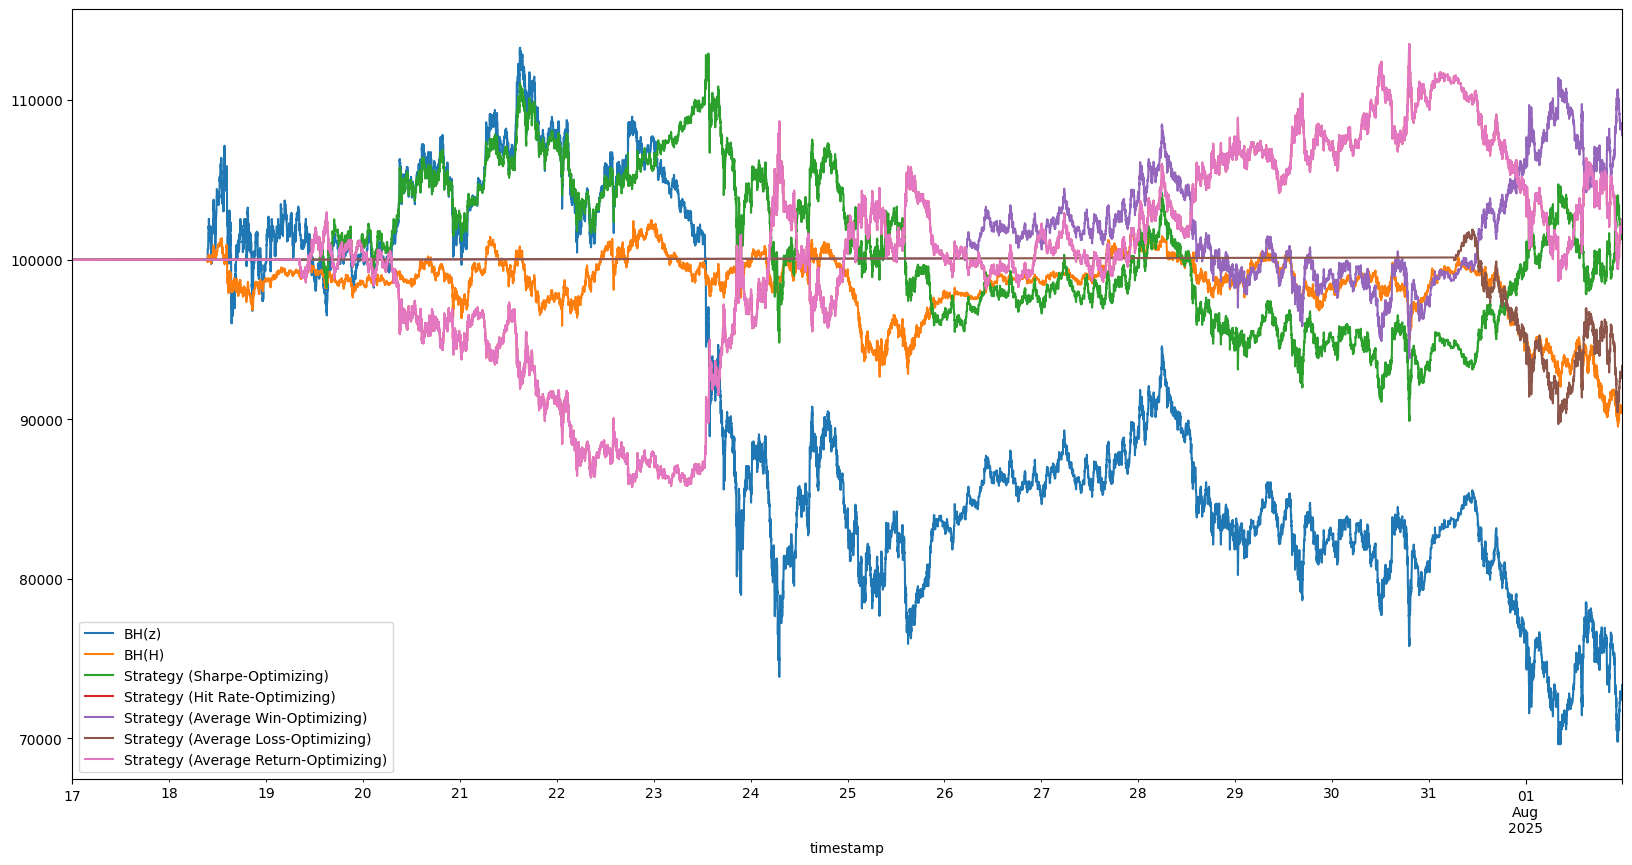

In [189]:
# Sharpe Optimizing
print('OPTIMIZED WITH SHARPE RATIO')
df_demo_train, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_train, p_S0=p_opt_S0_sharpe, p_S1=p_opt_S1_sharpe, p_S2=p_opt_S2_sharpe, init=init)
df_demo_train['Strategy (Sharpe-Optimizing)'] = df_demo_train['Strategy']
print('Number of Trades:', number_of_trades)
print(f'Hit Rate: {hit_rate:.2%}')
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2%}")
print(' ')

# Hit Rate Optimizing
print('OPTIMIZED WITH HIT RATE')
df_demo_train, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_train, p_S0=p_opt_S0_hit_rate, p_S1=p_opt_S1_hit_rate, p_S2=p_opt_S2_hit_rate, init=init)
df_demo_train['Strategy (Hit Rate-Optimizing)'] = df_demo_train['Strategy']
print('Number of Trades:', number_of_trades)
print(f'Hit Rate: {hit_rate:.2%}')
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2%}")
print(' ')

# Average Win Optimizing
print('OPTIMIZED WITH AVERAGE WIN')
df_demo_train, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_train, p_S0=p_opt_S0_average_win, p_S1=p_opt_S1_average_win, p_S2=p_opt_S2_average_win, init=init)
df_demo_train['Strategy (Average Win-Optimizing)'] = df_demo_train['Strategy']
print('Number of Trades:', number_of_trades)
print(f'Hit Rate: {hit_rate:.2%}')
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2%}")
print(' ')

# Average Loss Optimizing
print('OPTIMIZED WITH AVERAGE LOSS')
df_demo_train, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_train, p_S0=p_opt_S0_average_loss, p_S1=p_opt_S1_average_loss, p_S2=p_opt_S2_average_loss, init=init)
df_demo_train['Strategy (Average Loss-Optimizing)'] = df_demo_train['Strategy']
print('Number of Trades:', number_of_trades)
print(f'Hit Rate: {hit_rate:.2%}')
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2%}")
print(' ')

# Average Return Optimizing
print('OPTIMIZED WITH AVERAGE RETURN')
df_demo_train, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_train, p_S0=p_opt_S0_average_return, p_S1=p_opt_S1_average_return, p_S2=p_opt_S2_average_return, init=init)
df_demo_train['Strategy (Average Return-Optimizing)'] = df_demo_train['Strategy']
print('Number of Trades:', number_of_trades)
print(f'Hit Rate: {hit_rate:.2%}')
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2%}")
print(' ')

# Construct Buy-and-Hold Strategy for comparision

df_demo_train['Investment in H'] = 0.0
df_demo_train['BH(H) Instant PnL'] = 0.0
df_demo_train['BH(H)'] = E0
df_demo_train['BH(H) Instant Return'] = 0.0
df_demo_train['Cash'] = W0 - E0
Q_H_begin_BH = min(200000.0, Delta_max * df_demo_train['BH(H)'][init])

for t in range(init, df_demo_train.shape[0] - 1):
    ## GENERATE INSTANT PNL
    E = df_demo_train['BH(H)'][t]
    # Refill if falls below zero
    if E < 0:
        refill = min(E0 - E, df_demo_train['Cash'][t])
        df_demo_train['Cash'][t] = df_demo_train['Cash'][t] - refill
        E = df_demo_train['BH(H)'][t] + refill
    df_demo_train['Cash'][t + 1] = df_demo_train['Cash'][t]
    r = df_demo_train['Daily RF Rate'][t] / (24 * 60)
    R_H = (df_demo_train.iloc[:, 0][t] / df_demo_train.iloc[:, 0][t - 1]) - 1
    # Trade the minimum of $200,000 and maximum leverage
    Q_H = df_demo_train['Investment in H'][t - 1]
    if t == init:
        Q_H_new = Q_H_begin_BH
    else:
        Q_H_new = Q_H * (1 + R_H)
    df_demo_train['Investment in H'][t] = Q_H_new

    if t == init:
        instant_pnl = (Q_H * R_H) + r * (E - Q_H_begin_BH) - delta_r * abs(Q_H_begin_BH) - epsilon * (abs(Q_H_begin_BH))
    elif t == df_demo_train.shape[0] - 2:
        instant_pnl = (Q_H * R_H) - epsilon * (abs(Q_H))
    else:
        instant_pnl = (Q_H * R_H) + r * (E - Q_H_begin_BH) - delta_r * abs(Q_H_begin_BH)

    df_demo_train['BH(H) Instant PnL'][t] = instant_pnl

    ## GAIN PNL
    df_demo_train['BH(H)'][t + 1] = E + instant_pnl
    df_demo_train['BH(H) Instant Return'][t + 1] = instant_pnl / E

df_demo_train['BH(H)'] = df_demo_train['BH(H)'] + df_demo_train['Cash'] - W0 + E0
df_demo_train = df_demo_train.drop(['Investment in H', 'Cash'], axis=1)

# Extract date
df_demo_train['date_only'] = df_demo_train.index.date

# Group by date
daily_pnl = df_demo_train.groupby('date_only')['BH(H) Instant PnL'].sum()
daily_strategy_first = df_demo_train.groupby('date_only')['BH(H)'].first()

# Calculate daily return
daily_return = daily_pnl / daily_strategy_first

# Combine into a new DataFrame
daily_summary = pd.DataFrame({
    'BH(H) Daily PnL': daily_pnl,
    'BH(H) Daily Return': daily_return
})

# Merge back to the original DataFrame
df_demo_train = df_demo_train.merge(daily_summary, left_on='date_only', right_index=True, how='left')

# Step 1: Slice first
df_sliced = df_demo_train[init:].copy()

# Step 2: Ensure datetime index
df_sliced.index = pd.to_datetime(df_sliced.index)

# Step 3: Drop duplicates to keep one row per day (first row of each date)
df_daily = df_sliced[~df_sliced.index.normalize().duplicated(keep='first')]

# Step 4: Compute Sharpe components
average_return = df_daily['BH(H) Daily Return'].mean() 
excess_returns = df_daily['BH(H) Daily Return'] - df_daily['Daily RF Rate']
volatility = df_daily['BH(H) Daily Return'].std() 
sharpe = excess_returns.mean()  / volatility

# Step 5: Calmar Ratio
df_daily['Cumulative Return'] = (1 + df_daily['BH(H) Daily Return']).cumprod()
df_daily['Cumulative Max'] = df_daily['Cumulative Return'].cummax()
df_daily['Drawdown'] = df_daily['Cumulative Return'] / df_daily['Cumulative Max'] - 1
max_drawdown = df_daily['Drawdown'].min()
calmar_ratio = excess_returns / abs(max_drawdown)

df_demo_train = df_demo_train.drop(['BH(H) Daily PnL', 'BH(H) Daily Return', 'date_only'], axis=1)

print(f"average_return : {average_return:.2%}")
print(f"volatility : {volatility:.2%}")
print(f"Sharpe Ratio (BH(H)): {sharpe:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio.mean():.2%}")


df_demo_train['Investment in z'] = 0.0
df_demo_train['BH(z) Instant PnL'] = 0.0
df_demo_train['BH(z)'] = E0
df_demo_train['BH(z) Instant Return'] = 0.0
df_demo_train['Cash'] = W0 - E0
Q_z_begin_BH = min(200000.0, Delta_max * df_demo_train['BH(z)'][init])

for t in range(init, df_demo_train.shape[0] - 1):

    ## GENERATE INSTANT PNL
    E = df_demo_train['BH(z)'][t]
    # Refill if falls below zero
    if E < 0:
        refill = min(E0 - E, df_demo_train['Cash'][t])
        df_demo_train['Cash'][t] = df_demo_train['Cash'][t] - refill
        E = df_demo_train['BH(z)'][t] + refill
    df_demo_train['Cash'][t + 1] = df_demo_train['Cash'][t]
    r = df_demo_train['Daily RF Rate'][t] / (24 * 60)
    R_z = (df_demo_train.iloc[:, 1][t] / df_demo_train.iloc[:, 1][t - 1]) - 1
    # Trade the minimum of $200,000 and maximum leverage
    Q_z = df_demo_train['Investment in z'][t - 1]
    if t == init:
        Q_z_new = Q_z_begin_BH
    else:
        Q_z_new = Q_z * (1 + R_z)
    df_demo_train['Investment in z'][t] = Q_z_new

    if t == init:
        instant_pnl = (Q_z * R_z) + r * (E - Q_z_begin_BH) - delta_r * abs(Q_z_begin_BH) - epsilon * (abs(Q_z_begin_BH))
    elif t == df_demo_train.shape[0] - 2:
        instant_pnl = (Q_z * R_z) - epsilon * (abs(Q_z))
    else:
        instant_pnl = (Q_z * R_z) + r * (E - Q_z_begin_BH) - delta_r * abs(Q_z_begin_BH)

    df_demo_train['BH(z) Instant PnL'][t] = instant_pnl

    ## GAIN PNL
    df_demo_train['BH(z)'][t + 1] = E + instant_pnl
    df_demo_train['BH(z) Instant Return'][t + 1] = instant_pnl / E

df_demo_train['BH(z)'] = df_demo_train['BH(z)'] + df_demo_train['Cash'] - W0 + E0
df_demo_train = df_demo_train.drop(['Investment in z', 'Cash'], axis=1)

# Extract date
df_demo_train['date_only'] = df_demo_train.index.date

# Group by date
daily_pnl = df_demo_train.groupby('date_only')['BH(z) Instant PnL'].sum()
daily_strategy_first = df_demo_train.groupby('date_only')['BH(z)'].first()

# Calculate daily return
daily_return = daily_pnl / daily_strategy_first

# Combine into a new DataFrame
daily_summary = pd.DataFrame({
    'BH(z) Daily PnL': daily_pnl,
    'BH(z) Daily Return': daily_return
})

# Merge back to the original DataFrame
df_demo_train = df_demo_train.merge(daily_summary, left_on='date_only', right_index=True, how='left')

# Step 1: Slice first
df_sliced = df_demo_train[init:].copy()

# Step 2: Ensure datetime index
df_sliced.index = pd.to_datetime(df_sliced.index)

# Step 3: Drop duplicates to keep one row per day (first row of each date)
df_daily = df_sliced[~df_sliced.index.normalize().duplicated(keep='first')]

# Step 4: Compute Sharpe components
average_return = df_daily['BH(z) Daily Return'].mean()
excess_returns = df_daily['BH(z) Daily Return'] - df_daily['Daily RF Rate']
volatility = df_daily['BH(z) Daily Return'].std() 
sharpe = excess_returns.mean() / volatility

# Step 5: Calmar Ratio
df_daily['Cumulative Return'] = (1 + df_daily['BH(z) Daily Return']).cumprod()
df_daily['Cumulative Max'] = df_daily['Cumulative Return'].cummax()
df_daily['Drawdown'] = df_daily['Cumulative Return'] / df_daily['Cumulative Max'] - 1
max_drawdown = df_daily['Drawdown'].min()
calmar_ratio = excess_returns / abs(max_drawdown)

df_demo_train = df_demo_train.drop(['BH(z) Daily PnL', 'BH(z) Daily Return', 'date_only'], axis=1)

print(f"average_return : {average_return:.2%}")
print(f"volatility : {volatility:.2%}")
print(f"Sharpe Ratio (BH(z)): {sharpe:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio.mean():.2%}")


df_demo_train[['BH(z)', 'BH(H)', 'Strategy (Sharpe-Optimizing)', 'Strategy (Hit Rate-Optimizing)',
               'Strategy (Average Win-Optimizing)',
               'Strategy (Average Loss-Optimizing)', 'Strategy (Average Return-Optimizing)']].plot(figsize=(20, 10))
plt.show()

     

# 7. Testing Seet Performance

In [190]:
# Take ETH & SOL for Example
df_demo_test = pair_BTC_XRP_test

In [193]:
df_demo_train

,btc,xrp,Predicted Beta 0,Predicted Beta 1,Innovation,DDIVF,H Return,z Return,State,Daily RF Rate,...,Strategy (Hit Rate-Optimizing),Strategy (Average Win-Optimizing),Strategy (Average Loss-Optimizing),Strategy (Average Return-Optimizing),BH(H) Instant PnL,BH(H),BH(H) Instant Return,BH(z) Instant PnL,BH(z),BH(z) Instant Return
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-07-17 00:00:00,118705.0,3.0466,-2.007464,0.270413,0.000000,0.000000,NaN,NaN,NaN,0.000114,...,100000.000000,100000.000000,100000.000000,100000.000000,0.000000,100000.000000,0.000000e+00,0.000000,100000.000000,0.000000
2025-07-17 00:01:00,118738.0,3.0410,-2.007464,0.270413,0.000000,0.000000,0.000278,-0.001840,NaN,0.000114,...,100000.000000,100000.000000,100000.000000,100000.000000,0.000000,100000.000000,0.000000e+00,0.000000,100000.000000,0.000000
2025-07-17 00:02:00,118724.0,3.0410,-2.007464,0.270413,0.000000,0.000000,-0.000118,0.000000,NaN,0.000114,...,100000.000000,100000.000000,100000.000000,100000.000000,0.000000,100000.000000,0.000000e+00,0.000000,100000.000000,0.000000
2025-07-17 00:03:00,118729.0,3.0410,-2.007464,0.270413,0.000000,0.000000,0.000042,0.000000,NaN,0.000114,...,100000.000000,100000.000000,100000.000000,100000.000000,0.000000,100000.000000,0.000000e+00,0.000000,100000.000000,0.000000
2025-07-17 00:04:00,118719.0,3.0449,-2.007464,0.270413,0.000000,0.000000,-0.000084,0.001282,NaN,0.000114,...,100000.000000,100000.000000,100000.000000,100000.000000,0.000000,100000.000000,0.000000e+00,0.000000,100000.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-01 23:55:00,113267.0,2.9618,-2.033536,0.268210,-0.001963,0.000819,-0.000053,-0.002091,1.0,0.000112,...,102533.237871,107783.622230,93374.451288,102533.237871,-10.118389,90593.930983,-9.413878e-08,-362.752675,73366.944818,0.004244
2025-08-01 23:56:00,113339.0,2.9655,-2.033551,0.268054,0.000952,0.000953,0.000635,0.001248,1.0,0.000112,...,102206.752031,108089.587334,93065.658513,102206.752031,121.309797,90583.812594,-1.116895e-04,216.465645,73004.192143,-0.004944
2025-08-01 23:57:00,113319.0,2.9588,-2.033552,0.268130,-0.002153,0.000983,-0.000176,-0.002262,1.0,0.000112,...,102376.594088,107931.660480,93225.261714,102376.594088,-33.708055,90705.122391,1.339200e-03,-392.006138,73220.657788,0.002965


In [194]:
last_beta_0, last_beta_1 = df_demo_train.iloc[-1, 2], df_demo_train.iloc[-1, 3]

In [205]:
# Hedge Ratio & Innovation Volatility Forcasting
df_demo_test['Predicted Beta 0'] = last_beta_0
df_demo_test['Predicted Beta 1'] = last_beta_1
df_demo_test['Innovation'] = 0.0
df_demo_test['DDIVF'] = 0.0
R = np.array([0.001]).reshape(1, 1)
P = np.zeros((2, 2))
delta = 0.0001 
Q = delta / (1 - delta) * np.diag([1, 1])
I = np.identity(2)
k = 100
for t in range(1, df_demo_test.shape[0]-1):
  z = np.array([np.log(df_demo_test.iloc[:,1][t])]).reshape(1, 1)
  H = np.array([1, np.log(df_demo_test.iloc[:,0][t])]).reshape(1, 2)
  beta_old = np.array([df_demo_test['Predicted Beta 0'][t], df_demo_test['Predicted Beta 1'][t]]).reshape(2, 1)
  P = P + Q
  prediction = np.matmul(H, beta_old)
  innovation = z - prediction
  df_demo_test['Innovation'][t] = innovation[0][0]
  if t > k:
    w = df_demo_test['Innovation'].iloc[t-k:t].values
    a = w - w.mean()
    b = np.zeros(k)
    for i in range(k):
      if w[i] - w.mean() < 0:
        b[i] = -1
      elif w[i] - w.mean() > 0:
        b[i] = 1
      else:
        b[i] = 0
    rho = np.corrcoef(a, b)[0, 1]
    V = abs(w - w.mean()) / rho
    S = np.zeros(k)
    S[0] = V[:l].mean()
    alpha_values = np.arange(0.01, 0.5, 0.01)
    min_fess = 999999999.9
    alpha_opt = None
    for alpha in alpha_values:
      for i in range(1, k):
        S[i] = alpha * V[i] + (1 - alpha) * S[i-1]
      V_new = V[l:]
      S_new = S[l-1:-1]
      fess = np.sum(np.square(np.subtract(V_new, S_new)))
      if fess < min_fess:
        min_fess = fess
        alpha_opt = alpha
    for i in range(1, k):
      S[i] = alpha_opt * V[i] + (1 - alpha_opt) * S[i-1]
    ddivf = S[k-1]
    df_demo_test['DDIVF'][t] = ddivf
  K = np.matmul(P, H.T) / (np.matmul(np.matmul(H, P), H.T) + R)
  beta_predict = beta_old + np.matmul(K, innovation)
  df_demo_test['Predicted Beta 0'][t+1], df_demo_test['Predicted Beta 1'][t+1] = beta_predict[0][0], beta_predict[1][0]
  P = np.matmul(np.matmul((I - np.matmul(K, H)), P), (I - np.matmul(K, H)).T) + np.matmul(np.matmul(K, R), K.T)

# Hidden Markov State Estimation
df_demo_test['H Return'] = np.log1p(df_demo_test.iloc[:,0].pct_change())
df_demo_test['z Return'] = np.log1p(df_demo_test.iloc[:,1].pct_change())
df_demo_test['State'] = np.nan
df_demo_test['State'][k:-1] = hmm.predict(X = df_demo_test.iloc[k:-1][['Innovation', 'H Return', 'z Return']].values)

In [212]:
df_demo_test[k:]

,btc,xrp,Predicted Beta 0,Predicted Beta 1,Innovation,DDIVF,H Return,z Return,State,Daily RF Rate
timestamp,,,,,,,,,,
2025-08-02 01:40:00,113554.0,2.9674,-2.033567,0.267995,0.001788,0.000000,0.000000,0.001788,0.0,0.000112
2025-08-02 01:41:00,113554.0,2.9674,-2.033555,0.268137,0.000115,0.000743,0.000000,0.000000,0.0,0.000112
2025-08-02 01:42:00,113554.0,2.9721,-2.033554,0.268146,0.001590,0.000805,0.000000,0.001583,0.0,0.000112
2025-08-02 01:43:00,113554.0,2.9693,-2.033543,0.268273,-0.000841,0.000927,0.000000,-0.000943,0.0,0.000112
2025-08-02 01:44:00,113554.0,2.9720,-2.033549,0.268206,0.000855,0.000985,0.000000,0.000909,0.0,0.000112
...,...,...,...,...,...,...,...,...,...,...
2025-08-15 15:09:00,117113.0,3.0489,-2.049537,0.271170,-0.000480,0.001219,-0.000068,-0.000394,0.0,0.000110
2025-08-15 15:10:00,117203.0,3.0495,-2.049541,0.271132,-0.000042,0.001167,0.000768,0.000197,0.0,0.000110
2025-08-15 15:11:00,117550.0,3.0560,-2.049541,0.271129,0.001325,0.001135,0.002956,0.002129,0.0,0.000110


In [211]:
# Incorporate Daily Fed Funds Rate
df_demo_test = df_demo_test.join(data_test['Daily RF Rate'])

ValueError: columns overlap but no suffix specified: Index(['Daily RF Rate'], dtype='object')

OPTIMIZED WITH SHARPE RATIO
Number of Trades: 11
Hit Rate: 63.64%
Average Win: 6227.22169539425
Average Loss: 1202.245418038762
Average Return: 0.029023434338565444
Sharpe Ratio (Strategy): 71.38%
Max Drawdown: -0.62%
Calmar Ratio: 469.48%
 
OPTIMIZED WITH HIT RATE
Number of Trades: 63
Hit Rate: 38.10%
Average Win: 1062.4100110202005
Average Loss: 1333.8014842681644
Average Return: -0.017975649946174767
Sharpe Ratio (Strategy): -30.04%
Max Drawdown: -27.65%
Calmar Ratio: -6.54%
 
OPTIMIZED WITH AVERAGE WIN
Number of Trades: 1
Hit Rate: 100.00%
Average Win: 14330.872913636496
Average Loss: 0
Average Return: 0.01588308903061689
Sharpe Ratio (Strategy): 31.00%
Max Drawdown: -8.71%
Calmar Ratio: 18.10%
 
OPTIMIZED WITH AVERAGE LOSS
Number of Trades: 0
Hit Rate: 0.00%
Average Win: 0
Average Loss: 0
Average Return: -0.008254097173955897
Sharpe Ratio (Strategy): -28.52%
Max Drawdown: -11.51%
Calmar Ratio: -7.27%
 
OPTIMIZED WITH AVERAGE RETURN
Number of Trades: 62
Hit Rate: 38.71%
Average Win

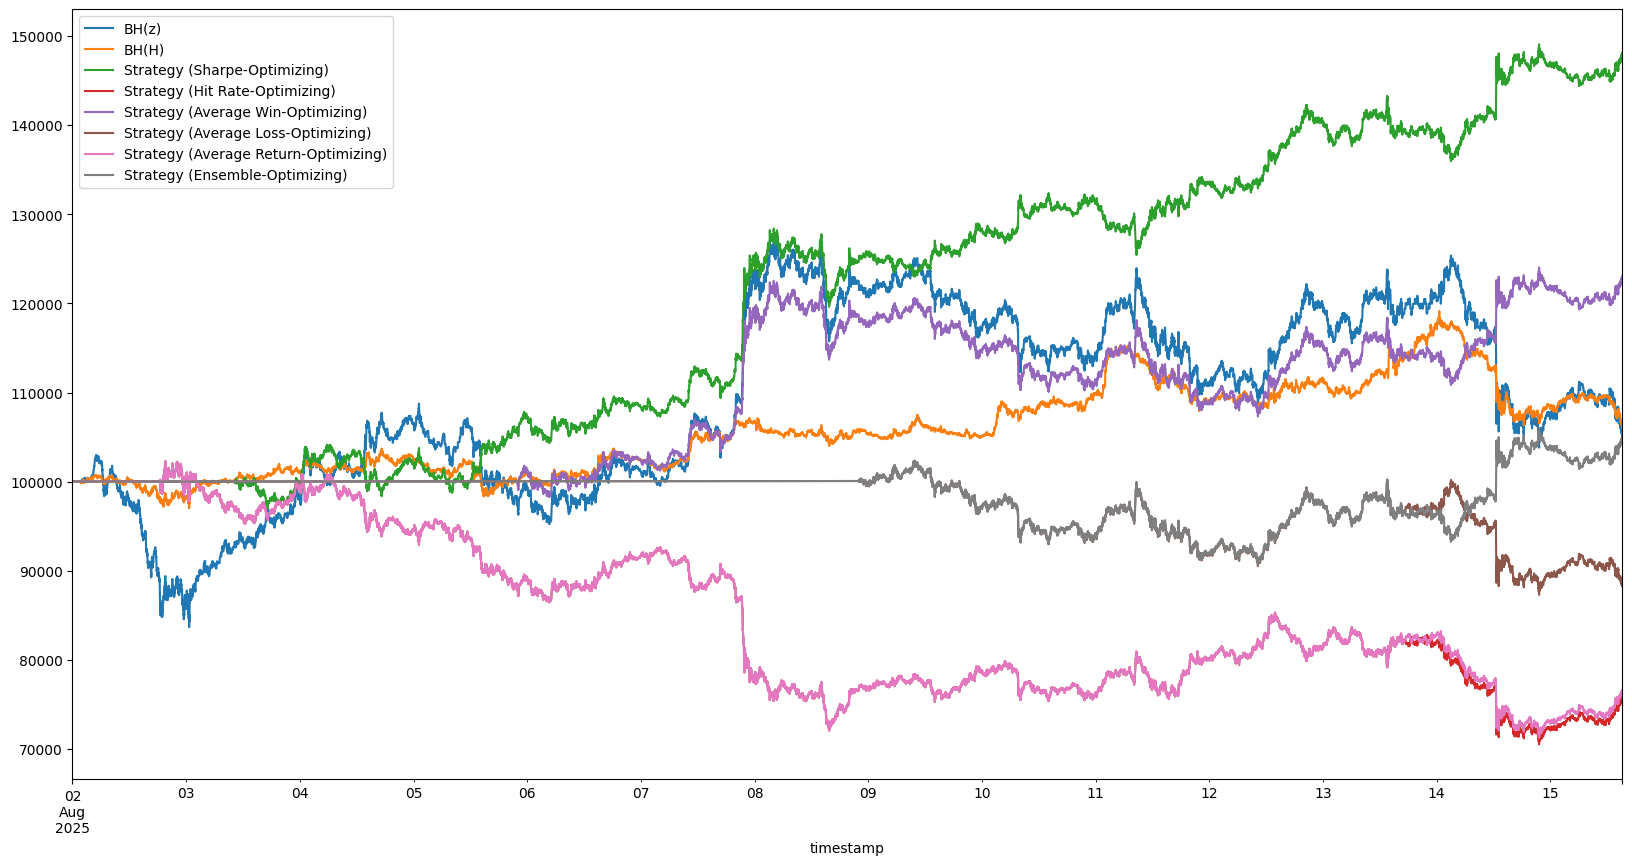

In [213]:
init = k+5

# Sharpe Optimizing
print('OPTIMIZED WITH SHARPE RATIO')
df_demo_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_test, p_S0=p_opt_S0_sharpe, p_S1=p_opt_S1_sharpe, p_S2=p_opt_S2_sharpe, init=init)
df_demo_test['Strategy (Sharpe-Optimizing)'] = df_demo_test['Strategy']
print('Number of Trades:', number_of_trades)
print(f'Hit Rate: {hit_rate:.2%}')
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2%}")
print(' ')

# Hit Rate Optimizing
print('OPTIMIZED WITH HIT RATE')
df_demo_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_test, p_S0=p_opt_S0_hit_rate, p_S1=p_opt_S1_hit_rate, p_S2=p_opt_S2_hit_rate, init=init)
df_demo_test['Strategy (Hit Rate-Optimizing)'] = df_demo_test['Strategy']
print('Number of Trades:', number_of_trades)
print(f'Hit Rate: {hit_rate:.2%}')
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2%}")
print(' ')

# Average Win Optimizing
print('OPTIMIZED WITH AVERAGE WIN')
df_demo_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_test, p_S0=p_opt_S0_average_win, p_S1=p_opt_S1_average_win, p_S2=p_opt_S2_average_win, init=init)
df_demo_test['Strategy (Average Win-Optimizing)'] = df_demo_test['Strategy']
print('Number of Trades:', number_of_trades)
print(f'Hit Rate: {hit_rate:.2%}')
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2%}")
print(' ')

# Average Loss Optimizing
print('OPTIMIZED WITH AVERAGE LOSS')
df_demo_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_test, p_S0=p_opt_S0_average_loss, p_S1=p_opt_S1_average_loss, p_S2=p_opt_S2_average_loss, init=init)
df_demo_test['Strategy (Average Loss-Optimizing)'] = df_demo_test['Strategy']
print('Number of Trades:', number_of_trades)
print(f'Hit Rate: {hit_rate:.2%}')
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2%}")
print(' ')

# Average Return Optimizing
print('OPTIMIZED WITH AVERAGE RETURN')
df_demo_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_test, p_S0=p_opt_S0_average_return, p_S1=p_opt_S1_average_return, p_S2=p_opt_S2_average_return, init=init)
df_demo_test['Strategy (Average Return-Optimizing)'] = df_demo_test['Strategy']
print('Number of Trades:', number_of_trades)
print(f'Hit Rate: {hit_rate:.2%}')
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2%}")
print(' ')

# Ensemble Optimizing
print('OPTIMIZED WITH Ensemble')
p_opt_S0_ensemble = (p_opt_S0_sharpe + p_opt_S0_hit_rate + p_opt_S0_average_win + p_opt_S0_average_loss + p_opt_S0_average_return) / 5
p_opt_S1_ensemble = (p_opt_S1_sharpe + p_opt_S1_hit_rate + p_opt_S1_average_win + p_opt_S1_average_loss + p_opt_S1_average_return) / 5
p_opt_S2_ensemble = (p_opt_S2_sharpe + p_opt_S2_hit_rate + p_opt_S2_average_win + p_opt_S2_average_loss + p_opt_S2_average_return) / 5
print(f"p_opt_S0_ensemble: {p_opt_S0_ensemble}")
print(f"p_opt_S1_ensemble: {p_opt_S1_ensemble}")
print(f"p_opt_S2_ensemble: {p_opt_S2_ensemble}")
df_demo_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=df_demo_test, p_S0=p_opt_S0_ensemble, p_S1=p_opt_S1_ensemble, p_S2=p_opt_S2_ensemble, init=init)
df_demo_test['Strategy (Ensemble-Optimizing)'] = df_demo_test['Strategy']
print('Number of Trades:', number_of_trades)
print(f'Hit Rate: {hit_rate:.2%}')
print('Average Win:', average_win)
print('Average Loss:', average_loss)
print('Average Return:', average_return)
print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2%}")
print(' ')

# Construct Buy-and-Hold Strategy for comparision

df_demo_test['Investment in H'] = 0.0
df_demo_test['BH(H) Instant PnL'] = 0.0
df_demo_test['BH(H)'] = E0
df_demo_test['BH(H) Instant Return'] = 0.0
df_demo_test['Cash'] = W0 - E0
Q_H_begin_BH = min(200000.0, Delta_max * df_demo_test['BH(H)'][init])

for t in range(init, df_demo_test.shape[0] - 1):
    ## GENERATE INSTANT PNL
    E = df_demo_test['BH(H)'][t]
    # Refill if falls below zero
    if E < 0:
        refill = min(E0 - E, df_demo_test['Cash'][t])
        df_demo_test['Cash'][t] = df_demo_test['Cash'][t] - refill
        E = df_demo_test['BH(H)'][t] + refill
    df_demo_test['Cash'][t + 1] = df_demo_test['Cash'][t]
    r = df_demo_test['Daily RF Rate'][t] / (24 * 60)
    R_H = (df_demo_test.iloc[:, 0][t] / df_demo_test.iloc[:, 0][t - 1]) - 1
    # Trade the minimum of $200,000 and maximum leverage
    Q_H = df_demo_test['Investment in H'][t - 1]
    if t == init:
        Q_H_new = Q_H_begin_BH
    else:
        Q_H_new = Q_H * (1 + R_H)
    df_demo_test['Investment in H'][t] = Q_H_new

    if t == init:
        instant_pnl = (Q_H * R_H) + r * (E - Q_H_begin_BH) - delta_r * abs(Q_H_begin_BH) - epsilon * (abs(Q_H_begin_BH))
    elif t == df_demo_test.shape[0] - 2:
        instant_pnl = (Q_H * R_H) - epsilon * (abs(Q_H))
    else:
        instant_pnl = (Q_H * R_H) + r * (E - Q_H_begin_BH) - delta_r * abs(Q_H_begin_BH)

    df_demo_test['BH(H) Instant PnL'][t] = instant_pnl

    ## GAIN PNL
    df_demo_test['BH(H)'][t + 1] = E + instant_pnl
    df_demo_test['BH(H) Instant Return'][t + 1] = instant_pnl / E

df_demo_test['BH(H)'] = df_demo_test['BH(H)'] + df_demo_test['Cash'] - W0 + E0
df_demo_test = df_demo_test.drop(['Investment in H', 'Cash'], axis=1)

# Extract date
df_demo_test['date_only'] = df_demo_test.index.date

# Group by date
daily_pnl = df_demo_test.groupby('date_only')['BH(H) Instant PnL'].sum()
daily_strategy_first = df_demo_test.groupby('date_only')['BH(H)'].first()

# Calculate daily return
daily_return = daily_pnl / daily_strategy_first

# Combine into a new DataFrame
daily_summary = pd.DataFrame({
    'BH(H) Daily PnL': daily_pnl,
    'BH(H) Daily Return': daily_return
})

# Merge back to the original DataFrame
df_demo_test = df_demo_test.merge(daily_summary, left_on='date_only', right_index=True, how='left')

# Step 1: Slice first
df_sliced = df_demo_test[init:].copy()

# Step 2: Ensure datetime index
df_sliced.index = pd.to_datetime(df_sliced.index)

# Step 3: Drop duplicates to keep one row per day (first row of each date)
df_daily = df_sliced[~df_sliced.index.normalize().duplicated(keep='first')]

# Step 4: Compute Sharpe components
average_return = df_daily['BH(H) Daily Return'].mean() 
excess_returns = df_daily['BH(H) Daily Return'] - df_daily['Daily RF Rate']
volatility = df_daily['BH(H) Daily Return'].std() 
sharpe = excess_returns.mean() / volatility
df_demo_test = df_demo_test.drop(['BH(H) Daily PnL', 'BH(H) Daily Return', 'date_only'], axis=1)

# Step 5: Calmar Ratio
df_daily['Cumulative Return'] = (1 + df_daily['BH(H) Daily Return']).cumprod()
df_daily['Cumulative Max'] = df_daily['Cumulative Return'].cummax()
df_daily['Drawdown'] = df_daily['Cumulative Return'] / df_daily['Cumulative Max'] - 1
max_drawdown = df_daily['Drawdown'].min()
calmar_ratio = excess_returns / abs(max_drawdown)

print(f"average_return : {average_return:.2%}")
print(f"volatility : {volatility:.2%}")
print(f"Sharpe Ratio (BH(H)): {sharpe:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio.mean():.2%}")


df_demo_test['Investment in z'] = 0.0
df_demo_test['BH(z) Instant PnL'] = 0.0
df_demo_test['BH(z)'] = E0
df_demo_test['BH(z) Instant Return'] = 0.0
df_demo_test['Cash'] = W0 - E0
Q_z_begin_BH = min(200000.0, Delta_max * df_demo_test['BH(z)'][init])

for t in range(init, df_demo_test.shape[0] - 1):

    ## GENERATE INSTANT PNL
    E = df_demo_test['BH(z)'][t]
    # Refill if falls below zero
    if E < 0:
        refill = min(E0 - E, df_demo_test['Cash'][t])
        df_demo_test['Cash'][t] = df_demo_test['Cash'][t] - refill
        E = df_demo_test['BH(z)'][t] + refill
    df_demo_test['Cash'][t + 1] = df_demo_test['Cash'][t]
    r = df_demo_test['Daily RF Rate'][t] / (24 * 60)
    R_z = (df_demo_test.iloc[:, 1][t] / df_demo_test.iloc[:, 1][t - 1]) - 1
    # Trade the minimum of $200,000 and maximum leverage
    Q_z = df_demo_test['Investment in z'][t - 1]
    if t == init:
        Q_z_new = Q_z_begin_BH
    else:
        Q_z_new = Q_z * (1 + R_z)
    df_demo_test['Investment in z'][t] = Q_z_new

    if t == init:
        instant_pnl = (Q_z * R_z) + r * (E - Q_z_begin_BH) - delta_r * abs(Q_z_begin_BH) - epsilon * (abs(Q_z_begin_BH))
    elif t == df_demo_test.shape[0] - 2:
        instant_pnl = (Q_z * R_z) - epsilon * (abs(Q_z))
    else:
        instant_pnl = (Q_z * R_z) + r * (E - Q_z_begin_BH) - delta_r * abs(Q_z_begin_BH)

    df_demo_test['BH(z) Instant PnL'][t] = instant_pnl

    ## GAIN PNL
    df_demo_test['BH(z)'][t + 1] = E + instant_pnl
    df_demo_test['BH(z) Instant Return'][t + 1] = instant_pnl / E

df_demo_test['BH(z)'] = df_demo_test['BH(z)'] + df_demo_test['Cash'] - W0 + E0
df_demo_test = df_demo_test.drop(['Investment in z', 'Cash'], axis=1)

# Extract date
df_demo_test['date_only'] = df_demo_test.index.date

# Group by date
daily_pnl = df_demo_test.groupby('date_only')['BH(z) Instant PnL'].sum()
daily_strategy_first = df_demo_test.groupby('date_only')['BH(z)'].first()

# Calculate daily return
daily_return = daily_pnl / daily_strategy_first

# Combine into a new DataFrame
daily_summary = pd.DataFrame({
    'BH(z) Daily PnL': daily_pnl,
    'BH(z) Daily Return': daily_return
})

# Merge back to the original DataFrame
df_demo_test = df_demo_test.merge(daily_summary, left_on='date_only', right_index=True, how='left')

# Step 1: Slice first
df_sliced = df_demo_test[init:].copy()

# Step 2: Ensure datetime index
df_sliced.index = pd.to_datetime(df_sliced.index)

# Step 3: Drop duplicates to keep one row per day (first row of each date)
df_daily = df_sliced[~df_sliced.index.normalize().duplicated(keep='first')]

# Step 4: Compute Sharpe components
average_return = df_daily['BH(z) Daily Return'].mean() 
excess_returns = df_daily['BH(z) Daily Return'] - df_daily['Daily RF Rate']
volatility = df_daily['BH(z) Daily Return'].std() 
sharpe = excess_returns.mean()  / volatility
df_demo_test = df_demo_test.drop(['BH(z) Daily PnL', 'BH(z) Daily Return', 'date_only'], axis=1)

# Step 5: Calmar Ratio
df_daily['Cumulative Return'] = (1 + df_daily['BH(z) Daily Return']).cumprod()
df_daily['Cumulative Max'] = df_daily['Cumulative Return'].cummax()
df_daily['Drawdown'] = df_daily['Cumulative Return'] / df_daily['Cumulative Max'] - 1
max_drawdown = df_daily['Drawdown'].min()
calmar_ratio = excess_returns / abs(max_drawdown)

print(f"average_return : {average_return:.2%}")
print(f"volatility : {volatility:.2%}")
print(f"Sharpe Ratio (BH(z)): {sharpe:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio.mean():.2%}")


df_demo_test[['BH(z)', 'BH(H)', 'Strategy (Sharpe-Optimizing)', 'Strategy (Hit Rate-Optimizing)',
               'Strategy (Average Win-Optimizing)',
               'Strategy (Average Loss-Optimizing)', 'Strategy (Average Return-Optimizing)','Strategy (Ensemble-Optimizing)']].plot(figsize=(20, 10))
plt.show()


In [214]:
print(f"p_opt_S0_ensemble: {p_opt_S0_ensemble}")
print(f"p_opt_S1_ensemble: {p_opt_S1_ensemble}")
print(f"p_opt_S2_ensemble: {p_opt_S2_ensemble}")

p_opt_S0_ensemble: 22.94523219069859
p_opt_S1_ensemble: 19.025788701412864
p_opt_S2_ensemble: 25.822107008573152


# 8. Performance Robustness Examination

In [223]:
## Settings

# KF-DDIVF, Beta Initializion
delta = 0.0001
sigma = 0.001 
j = 500 # Initialization for betas
k = 500 # Window length for DDIVF calculation
l = 100 # Initialization length for S
init = j+k+5

# Trading Simulation
E0 = 100000.0
W0 = 1000000.0
epsilon = 0.0005
delta_r = 0
Delta_max = 2

In [224]:
def initialize_beta(df, j=j):
  beta_0, beta_1, initial_spread = linear_OLS(np.log(df.iloc[:j, 0]), np.log(df.iloc[:j, 1]))
  return beta_0, beta_1

In [225]:
# KF-DDIVF

def kf_ddivf(pair_train):
  beta_1, beta_0 = initialize_beta(pair_train)
  pair_train['Predicted Beta 0'] = beta_0
  pair_train['Predicted Beta 1'] = beta_1
  pair_train['Innovation'] = 0.0
  pair_train['DDIVF'] = 0.0
  R = np.array([sigma]).reshape(1, 1)
  P = np.zeros((2, 2))
  Q = delta / (1 - delta) * np.diag([1, 1]) 
  I = np.identity(2)
  for t in range(j, pair_train.shape[0]-1):
    z = np.array([np.log(pair_train.iloc[:,1][t])]).reshape(1, 1)
    H = np.array([1, np.log(pair_train.iloc[:,0][t])]).reshape(1, 2)
    beta_old = np.array([pair_train['Predicted Beta 0'][t], pair_train['Predicted Beta 1'][t]]).reshape(2, 1)
    P = P + Q
    prediction = np.matmul(H, beta_old)
    innovation = z - prediction
    pair_train['Innovation'][t] = innovation[0][0]
    if t > j + k:
      w = pair_train['Innovation'].iloc[t-k:t].values
      rho = np.corrcoef(w - w.mean(), np.sign(w - w.mean()))[0, 1]
      V = abs(w - w.mean()) / rho
      S = np.zeros(k)
      S[0] = V[:l].mean()
      alpha_values = np.arange(0, 0.5, 0.01)
      min_fess = 999999999.9
      alpha_opt = None
      for alpha in alpha_values:
        for i in range(1, k):
          S[i] = alpha * V[i] + (1 - alpha) * S[i-1]
        fess = np.sum(np.square(np.subtract(V[l:], S[l-1:-1])))
        if fess < min_fess:
          min_fess = fess
          alpha_opt = alpha
      for i in range(1, k):
        S[i] = alpha_opt * V[i] + (1 - alpha_opt) * S[i-1]
      ddivf = S[-1]
      pair_train['DDIVF'][t] = ddivf
    K = np.matmul(P, H.T) / (np.matmul(np.matmul(H, P), H.T) + R)
    beta_predict = beta_old + np.matmul(K, innovation)
    pair_train['Predicted Beta 0'][t+1], pair_train['Predicted Beta 1'][t+1] = beta_predict[0][0], beta_predict[1][0]
    P = np.matmul(np.matmul((I - np.matmul(K, H)), P), (I - np.matmul(K, H)).T) + np.matmul(np.matmul(K, R), K.T)

In [226]:
# def classify_state(pair_train):
#   pair_train['H Return'] = np.log1p(pair_train.iloc[:,0].pct_change())
#   pair_train['z Return'] = np.log1p(pair_train.iloc[:,1].pct_change())
#   pair_train['State'] = np.nan
#   hmm = mix.GaussianMixture(n_components=3, covariance_type="full", n_init=100, random_state=7).fit(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)
#   pair_train['State'][j+5:-1] = hmm.predict(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)

In [227]:
def simulate_strategy(df, p_S0, p_S1, p_S2, init, E0 = 100000.0, W0 = 1000000.0, epsilon = 0.0005, delta_r = 0, Delta_max = 2):

  df['Investment in H'] = 0.0
  df['Investment in z'] = 0.0
  df['Signal'] = 0
  df['Strategy Instant PnL'] = 0.0
  df['Strategy'] = E0
  df['Strategy Instant Return'] = 0.0
  df['Cash'] = W0 - E0

  number_of_successes = 0
  number_of_failures = 0
  total_win = 0.0
  total_loss = 0.0
  cum_pnl = 0
  Q_z_begin = 0
  Q_H_begin = 0
  
  for t in range(j + k + 5, df.shape[0] - 1):
      # Starts after the fifth iteration to make the KF stablized.
  
      ## GENERATING SIGNALS
      if df['State'][t] == 0:
          p_now = p_S0
      elif df['State'][t] == 1:
          p_now = p_S1
      elif df['State'][t] == 2:
          p_now = p_S2
      if df['State'][t - 1] == 0:
          p_past = p_S0
      elif df['State'][t - 1] == 1:
          p_past = p_S1
      elif df['State'][t - 1] == 2:
          p_past = p_S2
  
      # Note the position would close in one day
      if df['Innovation'][t] < p_now * df['DDIVF'][t] and df['Innovation'][
          t - 1] > p_past * df['DDIVF'][t - 1]:
          signal = -1
      elif df['Innovation'][t] > -p_now * df['DDIVF'][t] and df['Innovation'][
          t - 1] < -p_past * df['DDIVF'][t - 1]:
          signal = 1
      else:
          signal = 0
      df['Signal'][t] = signal
  
      ## GENERATE Instant PNL
      E = df['Strategy'][t]
      # Refill if falls below zero
      if E < 0:
          refill = min(E0 - E, df['Cash'][t])
          df['Cash'][t] = df['Cash'][t] - refill
          E = df['Strategy'][t] + refill
      df['Cash'][t + 1] = df['Cash'][t]
      r = df['Daily RF Rate'][t] / (24 * 60)
      hedge_ratio = df['Predicted Beta 1'][t]
      R_z = (df.iloc[:, 1][t] / df.iloc[:, 1][t - 1]) - 1
      R_H = (df.iloc[:, 0][t] / df.iloc[:, 0][t - 1]) - 1
      Q_z = df['Investment in z'][t - 1]
      Q_H = df['Investment in H'][t - 1]
  
      # funding cost is imposed on the date trade is executed. It isn't imposed when clearing
      if signal == 0:
          # Not trade, but change value of position
          Q_z_new = Q_z * (1 + R_z)
          Q_H_new = Q_H * (1 + R_H)
          df['Investment in z'][t] = Q_z_new
          df['Investment in H'][t] = Q_H_new
          instant_pnl = (Q_z * R_z + Q_H * R_H) + r * (E - Q_z_begin - Q_H_begin) - delta_r * (
                      abs(Q_z_begin) + abs(Q_H_begin))
          cum_pnl += instant_pnl
          df['Strategy Instant PnL'][t] = instant_pnl
  
  
      elif signal != 0:
          # Clearing & Trade the minimum of $200,000 and maximum leverage
          Q_z_new = min(200000.0, Delta_max * E) / (1 + hedge_ratio) * signal
          Q_H_new = -Q_z_new * hedge_ratio
          df['Investment in z'][t] = Q_z_new
          df['Investment in H'][t] = Q_H_new
          Q_z_begin = Q_z_new
          Q_H_begin = Q_H_new
          instant_pnl = ((Q_z * R_z + Q_H * R_H) - epsilon * (abs(Q_z_new - Q_z) + abs(Q_H_new - Q_H))
                         + r * (E - Q_z_begin - Q_H_begin) - delta_r * (abs(Q_z_begin) + abs(Q_H_begin)))
          cum_pnl += instant_pnl
          df['Strategy Instant PnL'][t] = instant_pnl
          if (Q_z != 0) | (Q_H != 0):
              if cum_pnl > 0:
                  number_of_successes += 1
                  total_win += cum_pnl
                  #print(f"cum_pnl: {cum_pnl}")
              else:
                  number_of_failures += 1
                  total_loss -= cum_pnl
                  #print(f"cum_pnl: {cum_pnl}")
              cum_pnl = 0
          #print(f"Trading time: {df.index[t]}")

      ## GAIN PNL
      df['Strategy'][t+1] = E + instant_pnl
      df['Strategy Instant Return'][t+1] = instant_pnl / E
      
  df['Strategy'] = df['Strategy'] + df['Cash'] - W0 + E0
  df = df.drop(['Investment in H', 'Investment in z', 'Cash'], axis=1)

  # Extract date
  df['date_only'] = df.index.date
  # Group by date
  daily_pnl = df.groupby('date_only')['Strategy Instant PnL'].sum()
  daily_strategy_first = df.groupby('date_only')['Strategy'].first()
  # Calculate daily return
  daily_return = daily_pnl / daily_strategy_first
  # Combine into a new DataFrame
  daily_summary = pd.DataFrame({
     'Strategy Daily PnL': daily_pnl,
     'Strategy Daily Return': daily_return
    })
  # Merge back to the original DataFrame
  df = df.merge(daily_summary, left_on='date_only', right_index=True, how='left')
  # Step 1: Slice first
  df_sliced = df[init:].copy()  
  # Step 2: Ensure datetime index
  df_sliced.index = pd.to_datetime(df_sliced.index)
  # Step 3: Drop duplicates to keep one row per day (first row of each date)
  df_daily = df_sliced[~df_sliced.index.normalize().duplicated(keep='first')]
  # Step 4: Compute Sharpe components
  average_return = df_daily['Strategy Daily Return'].mean() 
  excess_returns = df_daily['Strategy Daily Return'] - df_daily['Daily RF Rate']
  volatility = df_daily['Strategy Daily Return'].std() 
  sharpe = excess_returns.mean() / volatility
  df = df.drop(['Strategy Daily PnL','Strategy Daily Return'], axis=1)
  # Step 5: Calmar Ratio
  df_daily['Cumulative Return'] = (1 + df_daily['Strategy Daily Return']).cumprod()
  df_daily['Cumulative Max'] = df_daily['Cumulative Return'].cummax()
  df_daily['Drawdown'] = df_daily['Cumulative Return'] / df_daily['Cumulative Max'] - 1
  max_drawdown = df_daily['Drawdown'].min()
  calmar_ratio = excess_returns / abs(max_drawdown)
    
  ## Calculate Trading Statistics
  number_of_trades = number_of_successes + number_of_failures
  if number_of_successes > 0:
    average_win = total_win / number_of_successes
    hit_rate = number_of_successes / number_of_trades
  else:
    average_win = 0
    hit_rate = 0
  if number_of_failures > 0:
    average_loss = total_loss / number_of_failures
  else:
    average_loss = 0
  
  return df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio.mean()

In [228]:
def optimize_threshold(pair_train, init=init):
    def eval_function_sharpe(p_S0, p_S1, p_S2):
        df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=pair_train, 
                                                                                                              p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init)
        return sharpe
    def eval_function_hit(p_S0, p_S1, p_S2):
        df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=pair_train, 
                                                                                                              p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init)
        return hit_rate
    def eval_function_win(p_S0, p_S1, p_S2):
        df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=pair_train, 
                                                                                                              p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init)
        return average_win
    def eval_function_loss(p_S0, p_S1, p_S2):
        df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=pair_train, 
                                                                                                              p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init)
        return -average_loss
    def eval_function_return(p_S0, p_S1, p_S2):
        df, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=pair_train, 
                                                                                                              p_S0=p_S0, p_S1=p_S1, p_S2=p_S2, init=init)
        return average_return

    param_bounds = {'p_S0': (5, 45), 'p_S1': (5, 45), 'p_S2': (5, 45) }

    optimizer_sharpe = BayesianOptimization(f=eval_function_sharpe,
                                     pbounds=param_bounds,
                                      random_state=0)

    optimizer_hit = BayesianOptimization(f=eval_function_hit,
                                     pbounds=param_bounds,
                                      random_state=0)


    optimizer_win = BayesianOptimization(f=eval_function_win,
                                     pbounds=param_bounds,
                                      random_state=0)


    optimizer_loss = BayesianOptimization(f=eval_function_loss,
                                     pbounds=param_bounds,
                                      random_state=0)


    optimizer_return = BayesianOptimization(f=eval_function_return,
                                     pbounds=param_bounds,
                                      random_state=0)

    optimizer_sharpe.maximize(init_points=5, n_iter=30)
    p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S2_sharpe, sharpe_best = optimizer_sharpe.max['params']['p_S0'], optimizer_sharpe.max['params']['p_S1'], optimizer_sharpe.max['params']['p_S2'], optimizer_sharpe.max['target']

    optimizer_hit.maximize(init_points=5, n_iter=30)
    p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S2_hit_rate, hit_rate_best = optimizer_hit.max['params']['p_S0'], optimizer_hit.max['params']['p_S1'], optimizer_hit.max['params']['p_S2'], optimizer_hit.max['target']

    optimizer_win.maximize(init_points=5, n_iter=30)
    p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S2_average_win, average_win_best = optimizer_win.max['params']['p_S0'], optimizer_win.max['params']['p_S1'], optimizer_win.max['params']['p_S2'], optimizer_win.max['target']

    optimizer_loss.maximize(init_points=5, n_iter=30)
    p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S2_average_loss, average_loss_best = optimizer_loss.max['params']['p_S0'], optimizer_loss.max['params']['p_S1'], optimizer_loss.max['params']['p_S2'], - optimizer_loss.max['target']

    optimizer_return.maximize(init_points=5, n_iter=30)
    p_opt_S0_average_return, p_opt_S1_average_return, p_opt_S2_average_return, average_return_best = optimizer_return.max['params']['p_S0'], optimizer_return.max['params']['p_S1'], optimizer_return.max['params']['p_S2'], optimizer_return.max['target']


    print('Sharpe Optimized p(S0), p(S1), p(S2), Sharpe:', p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S2_sharpe, sharpe_best)
    print('Hit-Rate Optimized p(S0), p(S1), p(S2), Hit Rate:', p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S2_hit_rate, hit_rate_best)
    print('Average-Win Optimized p(S0), p(S1), p(S2), Average Win', p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S2_average_win, average_win_best)
    print('Average-Loss Optimized p(S0), p(S1), p(S2), Average Loss:', p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S2_average_loss, average_loss_best)
    print('Average-Return Optimized p(S0), p(S1), p(S2), Average Return:', p_opt_S0_average_return, p_opt_S1_average_return, p_opt_S2_average_return, average_return_best)

    return p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S2_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S2_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S2_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S2_average_loss, p_opt_S0_average_return, p_opt_S1_average_return, p_opt_S2_average_return


In [229]:
def kf_ddivf_hmm_test(pair_test):
  # Hedge Ratio & Innovation Volatility Forcasting
  pair_test['Predicted Beta 0'] = last_beta_0
  pair_test['Predicted Beta 1'] = last_beta_1
  pair_test['Innovation'] = 0.0
  pair_test['DDIVF'] = 0.0
  R = np.array([0.001]).reshape(1, 1)
  P = np.zeros((2, 2))
  delta = 0.0001 
  Q = delta / (1 - delta) * np.diag([1, 1])
  I = np.identity(2)
  for t in range(1, pair_test.shape[0]-1):
    z = np.array([np.log(pair_test.iloc[:,1][t])]).reshape(1, 1)
    H = np.array([1, np.log(pair_test.iloc[:,0][t])]).reshape(1, 2)
    beta_old = np.array([pair_test['Predicted Beta 0'][t], pair_test['Predicted Beta 1'][t]]).reshape(2, 1)
    P = P + Q
    prediction = np.matmul(H, beta_old)
    innovation = z - prediction
    pair_test['Innovation'][t] = innovation[0][0]
    if t > k:
      w = pair_test['Innovation'].iloc[t-k:t].values
      a = w - w.mean()
      b = np.zeros(k)
      for i in range(k):
        if w[i] - w.mean() < 0:
          b[i] = -1
        elif w[i] - w.mean() > 0:
          b[i] = 1
        else:
          b[i] = 0
      rho = np.corrcoef(a, b)[0, 1]
      V = abs(w - w.mean()) / rho
      S = np.zeros(k)
      S[0] = V[:l].mean()
      alpha_values = np.arange(0.01, 0.5, 0.01)
      min_fess = 999999999.9
      alpha_opt = None
      for alpha in alpha_values:
        for i in range(1, k):
          S[i] = alpha * V[i] + (1 - alpha) * S[i-1]
        V_new = V[l:]
        S_new = S[l-1:-1]
        fess = np.sum(np.square(np.subtract(V_new, S_new)))
        if fess < min_fess:
          min_fess = fess
          alpha_opt = alpha
      for i in range(1, k):
        S[i] = alpha_opt * V[i] + (1 - alpha_opt) * S[i-1]
      ddivf = S[k-1]
      pair_test['DDIVF'][t] = ddivf
    K = np.matmul(P, H.T) / (np.matmul(np.matmul(H, P), H.T) + R)
    beta_predict = beta_old + np.matmul(K, innovation)
    pair_test['Predicted Beta 0'][t+1], pair_test['Predicted Beta 1'][t+1] = beta_predict[0][0], beta_predict[1][0]
    P = np.matmul(np.matmul((I - np.matmul(K, H)), P), (I - np.matmul(K, H)).T) + np.matmul(np.matmul(K, R), K.T)

  # Hidden Markov State Estimation
  pair_test['H Return'] = np.log1p(pair_test.iloc[:,0].pct_change())
  pair_test['z Return'] = np.log1p(pair_test.iloc[:,1].pct_change())
  pair_test['State'] = np.nan
  pair_test['State'][k:-1] = hmm.predict(X = pair_test.iloc[k:-1][['Innovation', 'H Return', 'z Return']].values)

In [230]:
def back_test(pair_test):
  init = k+5

  # Sharpe Optimizing
  print('OPTIMIZED WITH SHARPE RATIO')
  pair_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=pair_test, p_S0=p_opt_S0_sharpe, p_S1=p_opt_S1_sharpe, p_S2=p_opt_S2_sharpe, init=init)
  pair_test['Strategy (Sharpe-Optimizing)'] = pair_test['Strategy']
  print('Number of Trades:', number_of_trades)
  print(f'Hit Rate: {hit_rate:.2%}')
  print('Average Win:', average_win)
  print('Average Loss:', average_loss)
  print('Average Return:', average_return)
  print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
  print(f"Max Drawdown: {max_drawdown:.2%}")
  print(f"Calmar Ratio: {calmar_ratio:.2%}")
  print(' ')

  # Hit Rate Optimizing
  print('OPTIMIZED WITH HIT RATE')
  pair_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=pair_test, p_S0=p_opt_S0_hit_rate, p_S1=p_opt_S1_hit_rate, p_S2=p_opt_S2_hit_rate, init=init)
  pair_test['Strategy (Hit Rate-Optimizing)'] = pair_test['Strategy']
  print('Number of Trades:', number_of_trades)
  print(f'Hit Rate: {hit_rate:.2%}')
  print('Average Win:', average_win)
  print('Average Loss:', average_loss)
  print('Average Return:', average_return)
  print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
  print(f"Max Drawdown: {max_drawdown:.2%}")
  print(f"Calmar Ratio: {calmar_ratio:.2%}")
  print(' ')

  # Average Win Optimizing
  print('OPTIMIZED WITH AVERAGE WIN')
  pair_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=pair_test, p_S0=p_opt_S0_average_win, p_S1=p_opt_S1_average_win, p_S2=p_opt_S2_average_win, init=init)
  pair_test['Strategy (Average Win-Optimizing)'] = pair_test['Strategy']
  print('Number of Trades:', number_of_trades)
  print(f'Hit Rate: {hit_rate:.2%}')
  print('Average Win:', average_win)
  print('Average Loss:', average_loss)
  print('Average Return:', average_return)
  print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
  print(f"Max Drawdown: {max_drawdown:.2%}")
  print(f"Calmar Ratio: {calmar_ratio:.2%}")
  print(' ')

  # Average Loss Optimizing
  print('OPTIMIZED WITH AVERAGE LOSS')
  pair_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=pair_test, p_S0=p_opt_S0_average_loss, p_S1=p_opt_S1_average_loss, p_S2=p_opt_S2_average_loss, init=init)
  pair_test['Strategy (Average Loss-Optimizing)'] = pair_test['Strategy']
  print('Number of Trades:', number_of_trades)
  print(f'Hit Rate: {hit_rate:.2%}')
  print('Average Win:', average_win)
  print('Average Loss:', average_loss)
  print('Average Return:', average_return)
  print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
  print(f"Max Drawdown: {max_drawdown:.2%}")
  print(f"Calmar Ratio: {calmar_ratio:.2%}")
  print(' ')

  # Average Return Optimizing
  print('OPTIMIZED WITH AVERAGE RETURN')
  pair_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=pair_test, p_S0=p_opt_S0_average_return, p_S1=p_opt_S1_average_return, p_S2=p_opt_S2_average_return, init=init)
  pair_test['Strategy (Average Return-Optimizing)'] = pair_test['Strategy']
  print('Number of Trades:', number_of_trades)
  print(f'Hit Rate: {hit_rate:.2%}')
  print('Average Win:', average_win)
  print('Average Loss:', average_loss)
  print('Average Return:', average_return)
  print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
  print(f"Max Drawdown: {max_drawdown:.2%}")
  print(f"Calmar Ratio: {calmar_ratio:.2%}")
  print(' ')
    
  # Ensemble Optimizing
  print('OPTIMIZED WITH Ensemble')
  p_opt_S0_ensemble = (p_opt_S0_sharpe + p_opt_S0_hit_rate + p_opt_S0_average_win + p_opt_S0_average_loss + p_opt_S0_average_return) / 5
  p_opt_S1_ensemble = (p_opt_S1_sharpe + p_opt_S1_hit_rate + p_opt_S1_average_win + p_opt_S1_average_loss + p_opt_S1_average_return) / 5
  p_opt_S2_ensemble = (p_opt_S2_sharpe + p_opt_S2_hit_rate + p_opt_S2_average_win + p_opt_S2_average_loss + p_opt_S2_average_return) / 5
  pair_test, number_of_trades, hit_rate, average_win, average_loss, average_return, sharpe, max_drawdown, calmar_ratio = simulate_strategy(df=pair_test, p_S0=p_opt_S0_ensemble, p_S1=p_opt_S1_ensemble, p_S2=p_opt_S2_ensemble, init=init)
  pair_test['Strategy (Ensemble-Optimizing)'] = pair_test['Strategy']
  print('Number of Trades:', number_of_trades)
  print(f'Hit Rate: {hit_rate:.2%}')
  print('Average Win:', average_win)
  print('Average Loss:', average_loss)
  print('Average Return:', average_return)
  print(f'Sharpe Ratio (Strategy): {sharpe:.2%}')
  print(f"Max Drawdown: {max_drawdown:.2%}")
  print(f"Calmar Ratio: {calmar_ratio:.2%}")
  print(' ')
    
  # Construct Buy-and-Hold Strategy for comparision
  
  pair_test['Investment in H'] = 0.0
  pair_test['BH(H) Instant PnL'] = 0.0
  pair_test['BH(H)'] = E0
  pair_test['BH(H) Instant Return'] = 0.0
  pair_test['Cash'] = W0 - E0
  Q_H_begin_BH = min(200000.0, Delta_max * pair_test['BH(H)'][init])
  
  for t in range(init, pair_test.shape[0] - 1):
      ## GENERATE INSTANT PNL
      E = pair_test['BH(H)'][t]
      # Refill if falls below zero
      if E < 0:
          refill = min(E0 - E, pair_test['Cash'][t])
          pair_test['Cash'][t] = pair_test['Cash'][t] - refill
          E = pair_test['BH(H)'][t] + refill
      pair_test['Cash'][t + 1] = pair_test['Cash'][t]
      r = pair_test['Daily RF Rate'][t] / (24 * 60)
      R_H = (pair_test.iloc[:, 0][t] / pair_test.iloc[:, 0][t - 1]) - 1
      # Trade the minimum of $200,000 and maximum leverage
      Q_H = pair_test['Investment in H'][t - 1]
      if t == init:
          Q_H_new = Q_H_begin_BH
      else:
          Q_H_new = Q_H * (1 + R_H)
      pair_test['Investment in H'][t] = Q_H_new
  
      if t == init:
          instant_pnl = (Q_H * R_H) + r * (E - Q_H_begin_BH) - delta_r * abs(Q_H_begin_BH) - epsilon * (abs(Q_H_begin_BH))
      elif t == pair_test.shape[0] - 2:
          instant_pnl = (Q_H * R_H) - epsilon * (abs(Q_H))
      else:
          instant_pnl = (Q_H * R_H) + r * (E - Q_H_begin_BH) - delta_r * abs(Q_H_begin_BH)
  
      pair_test['BH(H) Instant PnL'][t] = instant_pnl
  
      ## GAIN PNL
      pair_test['BH(H)'][t + 1] = E + instant_pnl
      pair_test['BH(H) Instant Return'][t + 1] = instant_pnl / E
  
  pair_test['BH(H)'] = pair_test['BH(H)'] + pair_test['Cash'] - W0 + E0
  pair_test = pair_test.drop(['Investment in H', 'Cash'], axis=1)
  
  # Extract date
  pair_test['date_only'] = pair_test.index.date
  
  # Group by date
  daily_pnl = pair_test.groupby('date_only')['BH(H) Instant PnL'].sum()
  daily_strategy_first = pair_test.groupby('date_only')['BH(H)'].first()
  
  # Calculate daily return
  daily_return = daily_pnl / daily_strategy_first
  
  # Combine into a new DataFrame
  daily_summary = pd.DataFrame({
      'BH(H) Daily PnL': daily_pnl,
      'BH(H) Daily Return': daily_return
  })
  
  # Merge back to the original DataFrame
  pair_test = pair_test.merge(daily_summary, left_on='date_only', right_index=True, how='left')
  
  # Step 1: Slice first
  df_sliced = pair_test[init:].copy()
  
  # Step 2: Ensure datetime index
  df_sliced.index = pd.to_datetime(df_sliced.index)
  
  # Step 3: Drop duplicates to keep one row per day (first row of each date)
  df_daily = df_sliced[~df_sliced.index.normalize().duplicated(keep='first')]
  
  # Step 4: Compute Sharpe components
  average_return = df_daily['BH(H) Daily Return'].mean() 
  excess_returns = df_daily['BH(H) Daily Return'] - df_daily['Daily RF Rate']
  volatility = df_daily['BH(H) Daily Return'].std() 
  sharpe = excess_returns.mean()  / volatility
  pair_test = pair_test.drop(['BH(H) Daily PnL', 'BH(H) Daily Return', 'date_only'], axis=1)

  # Step 5: Calmar Ratio
  df_daily['Cumulative Return'] = (1 + df_daily['BH(H) Daily Return']).cumprod()
  df_daily['Cumulative Max'] = df_daily['Cumulative Return'].cummax()
  df_daily['Drawdown'] = df_daily['Cumulative Return'] / df_daily['Cumulative Max'] - 1
  max_drawdown = df_daily['Drawdown'].min()
  calmar_ratio = excess_returns / abs(max_drawdown)
  
  print(f"average_return : {average_return:.2%}")
  print(f"volatility : {volatility:.2%}")
  print(f"Sharpe Ratio (BH(H)): {sharpe:.2%}")
  print(f"Max Drawdown: {max_drawdown:.2%}")
  print(f"Calmar Ratio: {calmar_ratio.mean():.2%}")

  
  pair_test['Investment in z'] = 0.0
  pair_test['BH(z) Instant PnL'] = 0.0
  pair_test['BH(z)'] = E0
  pair_test['BH(z) Instant Return'] = 0.0
  pair_test['Cash'] = W0 - E0
  Q_z_begin_BH = min(200000.0, Delta_max * pair_test['BH(z)'][init])
  
  for t in range(init, pair_test.shape[0] - 1):
  
      ## GENERATE INSTANT PNL
      E = pair_test['BH(z)'][t]
      # Refill if falls below zero
      if E < 0:
          refill = min(E0 - E, pair_test['Cash'][t])
          pair_test['Cash'][t] = pair_test['Cash'][t] - refill
          E = pair_test['BH(z)'][t] + refill
      pair_test['Cash'][t + 1] = pair_test['Cash'][t]
      r = pair_test['Daily RF Rate'][t] / (24 * 60)
      R_z = (pair_test.iloc[:, 1][t] / pair_test.iloc[:, 1][t - 1]) - 1
      # Trade the minimum of $200,000 and maximum leverage
      Q_z = pair_test['Investment in z'][t - 1]
      if t == init:
          Q_z_new = Q_z_begin_BH
      else:
          Q_z_new = Q_z * (1 + R_z)
      pair_test['Investment in z'][t] = Q_z_new
  
      if t == init:
          instant_pnl = (Q_z * R_z) + r * (E - Q_z_begin_BH) - delta_r * abs(Q_z_begin_BH) - epsilon * (abs(Q_z_begin_BH))
      elif t == pair_test.shape[0] - 2:
          instant_pnl = (Q_z * R_z) - epsilon * (abs(Q_z))
      else:
          instant_pnl = (Q_z * R_z) + r * (E - Q_z_begin_BH) - delta_r * abs(Q_z_begin_BH)
  
      pair_test['BH(z) Instant PnL'][t] = instant_pnl
  
      ## GAIN PNL
      pair_test['BH(z)'][t + 1] = E + instant_pnl
      pair_test['BH(z) Instant Return'][t + 1] = instant_pnl / E
  
  pair_test['BH(z)'] = pair_test['BH(z)'] + pair_test['Cash'] - W0 + E0
  pair_test = pair_test.drop(['Investment in z', 'Cash'], axis=1)
  
  # Extract date
  pair_test['date_only'] = pair_test.index.date
  
  # Group by date
  daily_pnl = pair_test.groupby('date_only')['BH(z) Instant PnL'].sum()
  daily_strategy_first = pair_test.groupby('date_only')['BH(z)'].first()
  
  # Calculate daily return
  daily_return = daily_pnl / daily_strategy_first
  
  # Combine into a new DataFrame
  daily_summary = pd.DataFrame({
      'BH(z) Daily PnL': daily_pnl,
      'BH(z) Daily Return': daily_return
  })
  
  # Merge back to the original DataFrame
  pair_test = pair_test.merge(daily_summary, left_on='date_only', right_index=True, how='left')
  
  # Step 1: Slice first
  df_sliced = pair_test[init:].copy()
  
  # Step 2: Ensure datetime index
  df_sliced.index = pd.to_datetime(df_sliced.index) 
  
  # Step 3: Drop duplicates to keep one row per day (first row of each date)
  df_daily = df_sliced[~df_sliced.index.normalize().duplicated(keep='first')]
  
  # Step 4: Compute Sharpe components
  average_return = df_daily['BH(z) Daily Return'].mean() 
  excess_returns = df_daily['BH(z) Daily Return'] - df_daily['Daily RF Rate']
  volatility = df_daily['BH(z) Daily Return'].std() 
  sharpe = excess_returns.mean() / volatility
  pair_test = pair_test.drop(['BH(z) Daily PnL', 'BH(z) Daily Return', 'date_only'], axis=1)
  
  # Step 5: Calmar Ratio
  df_daily['Cumulative Return'] = (1 + df_daily['BH(z) Daily Return']).cumprod()
  df_daily['Cumulative Max'] = df_daily['Cumulative Return'].cummax()
  df_daily['Drawdown'] = df_daily['Cumulative Return'] / df_daily['Cumulative Max'] - 1
  max_drawdown = df_daily['Drawdown'].min()
  calmar_ratio = excess_returns / abs(max_drawdown)
  
  print(f"average_return : {average_return:.2%}")
  print(f"volatility : {volatility:.2%}")
  print(f"Sharpe Ratio (BH(z)): {sharpe:.2%}")
  print(f"Max Drawdown: {max_drawdown:.2%}")
  print(f"Calmar Ratio: {calmar_ratio.mean():.2%}")

  pair_test[['BH(z)', 'BH(H)', 'Strategy (Sharpe-Optimizing)', 'Strategy (Hit Rate-Optimizing)',
                 'Strategy (Average Win-Optimizing)',
                 'Strategy (Average Loss-Optimizing)', 'Strategy (Average Return-Optimizing)', 'Strategy (Ensemble-Optimizing)']].plot(figsize=(20, 10))
  plt.show()

|   iter    |  target   |   p_S0    |   p_S1    |   p_S2    |
-------------------------------------------------------------
| 1         | 0.0347270 | 26.952540 | 33.607574 | 29.110535 |
| 2         | 0.0347270 | 26.795327 | 21.946191 | 30.835764 |
| 3         | 0.0342939 | 22.503488 | 40.670920 | 43.546510 |
| 4         | 0.0342939 | 20.337660 | 36.669001 | 26.155796 |
| 5         | -0.250148 | 27.721782 | 42.023865 | 7.8414423 |
| 6         | 0.0347270 | 26.632857 | 35.208939 | 28.397847 |
| 7         | 0.1061797 | 5.0       | 11.844035 | 45.0      |
| 8         | -0.784542 | 5.0       | 5.0       | 24.254459 |
| 9         | -0.180250 | 45.0      | 13.428597 | 45.0      |
| 10        | -0.419787 | 5.0       | 29.765871 | 45.0      |
| 11        | 0.2505697 | 19.406928 | 10.239948 | 45.0      |
| 12        | -0.250148 | 41.543874 | 45.0      | 45.0      |
| 13        | 0.0342939 | 24.972968 | 20.360120 | 45.0      |
| 14        | -0.607082 | 28.100295 | 5.0       | 45.0      |
| 15    

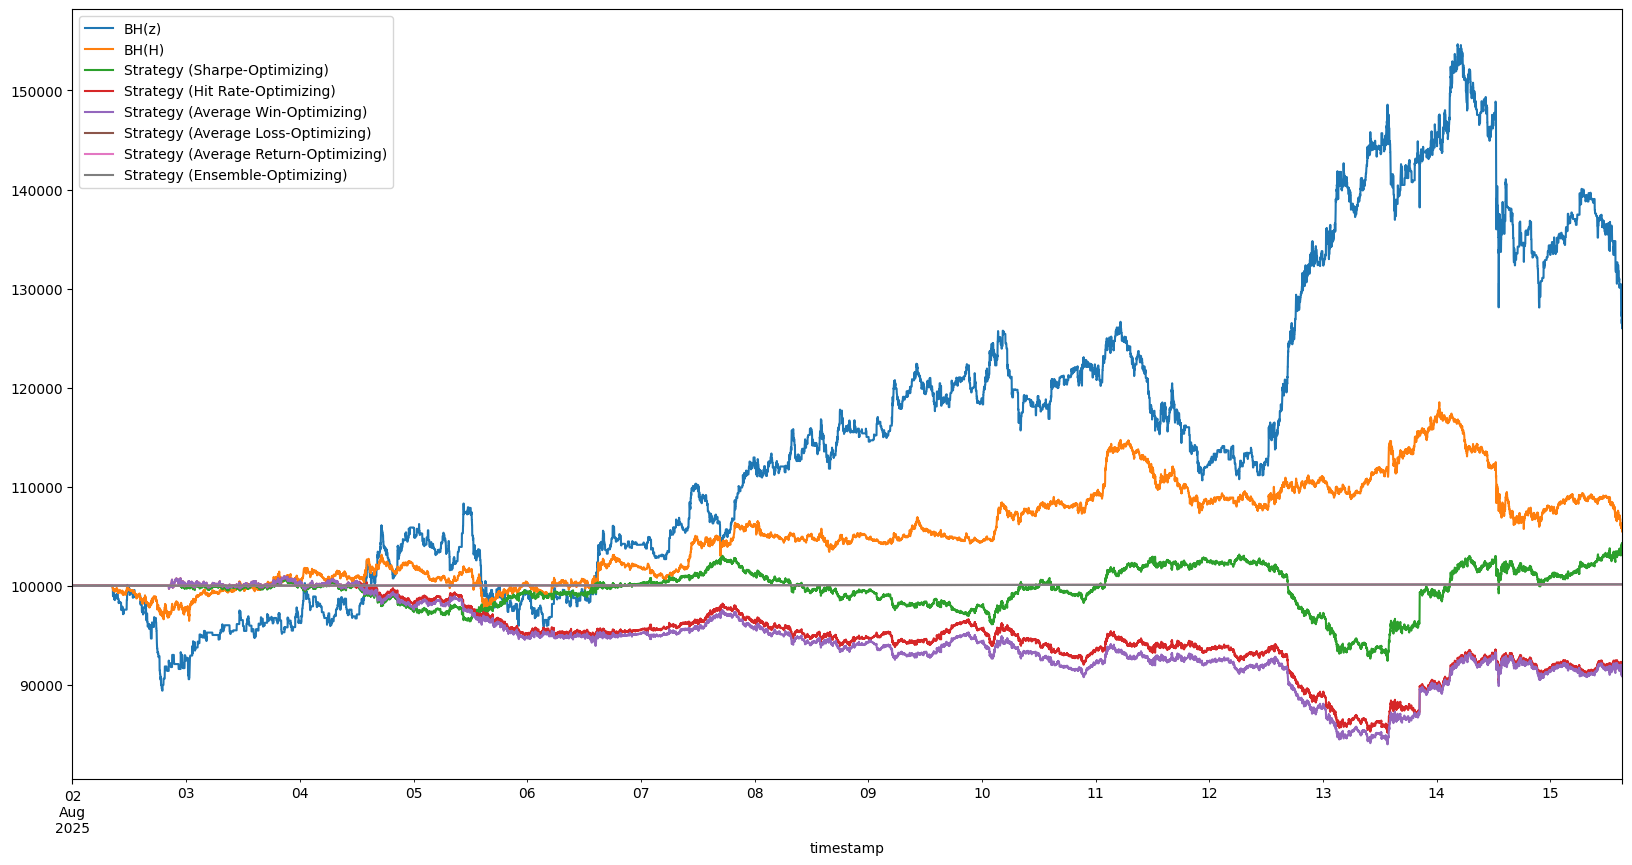

| 1         | 0.003959  | 26.95     | 33.61     | 29.11     |
| 2         | 0.005368  | 26.8      | 21.95     | 30.84     |
| 3         | 0.003053  | 22.5      | 40.67     | 43.55     |
| 4         | 0.0007409 | 20.34     | 36.67     | 26.16     |
| 5         | -0.003768 | 27.72     | 42.02     | 7.841     |
| 6         | 0.003183  | 40.96     | 25.27     | 40.31     |
| 7         | -0.005946 | 14.21     | 43.3      | 20.33     |
| 8         | -0.00763  | 13.28     | 10.44     | 45.0      |
| 9         | 0.0008973 | 39.59     | 16.71     | 21.3      |
| 10        | -0.002835 | 43.55     | 45.0      | 45.0      |
| 11        | 0.004136  | 27.41     | 21.03     | 31.09     |
| 12        | 0.00418   | 22.87     | 27.87     | 35.18     |
| 13        | 0.003842  | 22.34     | 24.53     | 24.64     |
| 14        | 0.002246  | 33.22     | 27.69     | 30.32     |
| 15        | 0.003925  | 30.23     | 30.84     | 44.37     |
| 16        | -0.002548 | 44.49     | 11.21     | 44.21     |
| 17    

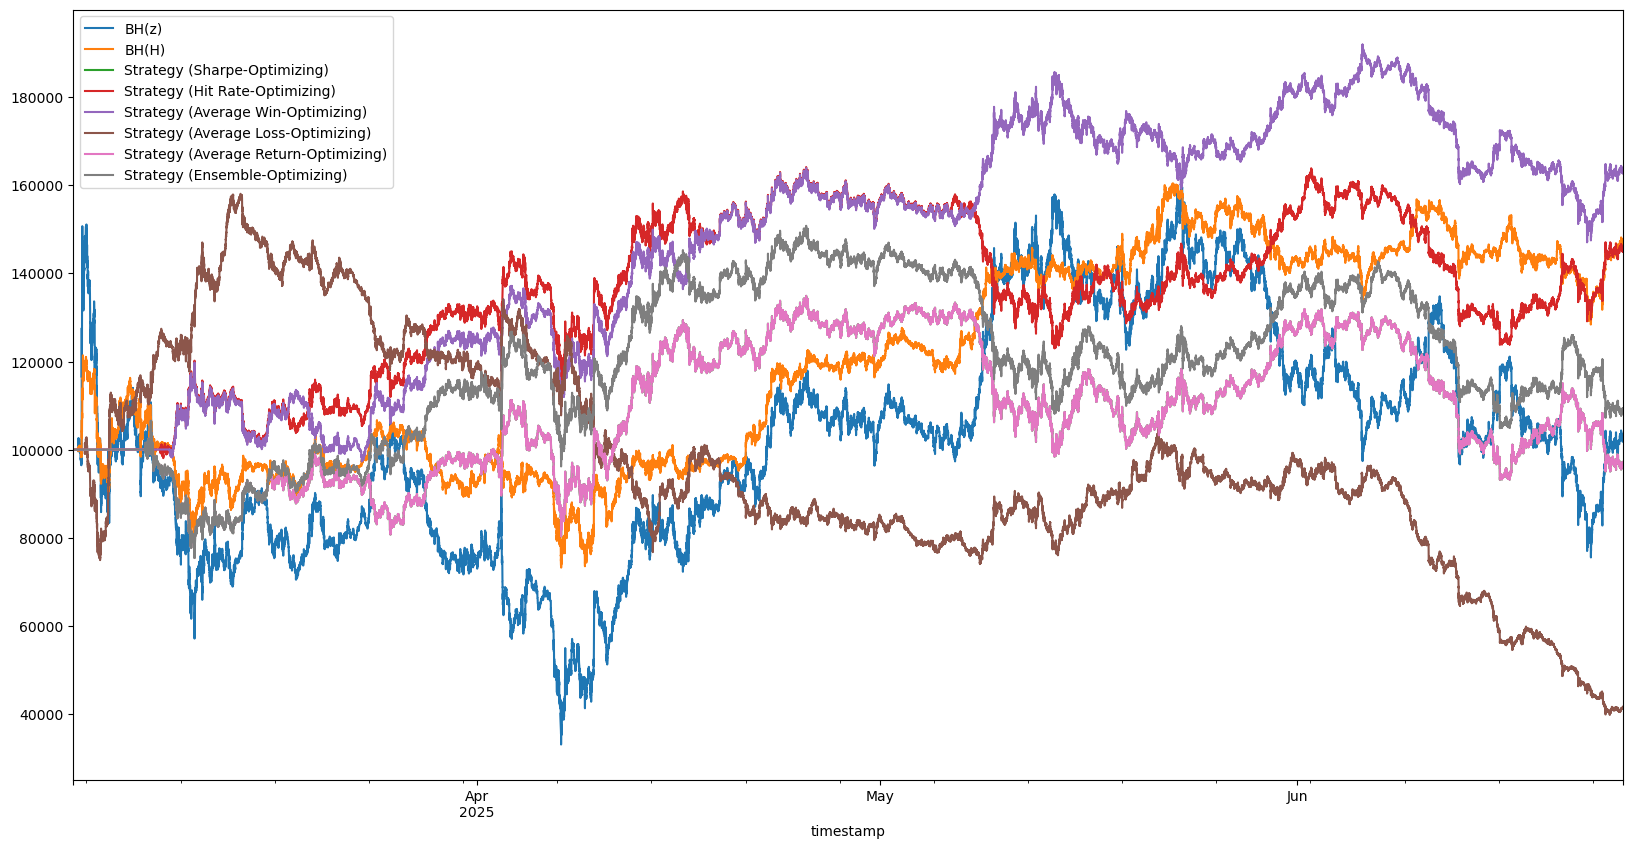

In [231]:
pair_train, pair_test = pair_BTC_SOL_train, pair_BTC_SOL_test

kf_ddivf(pair_train)

#classify states
pair_train['H Return'] = np.log1p(pair_train.iloc[:,0].pct_change())
pair_train['z Return'] = np.log1p(pair_train.iloc[:,1].pct_change())
pair_train['State'] = np.nan
hmm = mix.GaussianMixture(n_components=3, covariance_type="full", n_init=100, random_state=7).fit(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)
pair_train['State'][j+5:-1] = hmm.predict(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)
pair_train = pair_train.join(data_train['Daily RF Rate'])

p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S2_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S2_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S2_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S2_average_loss, p_opt_S0_average_return, p_opt_S1_average_return, p_opt_S2_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily RF Rate'])
back_test(pair_test)   

|   iter    |  target   |   p_S0    |   p_S1    |   p_S2    |
-------------------------------------------------------------
| 1         | -0.439159 | 26.952540 | 33.607574 | 29.110535 |
| 2         | -0.439159 | 26.795327 | 21.946191 | 30.835764 |
| 3         | 0.1352151 | 22.503488 | 40.670920 | 43.546510 |
| 4         | 0.1352151 | 20.337660 | 36.669001 | 26.155796 |
| 5         | -0.023351 | 27.721782 | 42.023865 | 7.8414423 |
| 6         | -0.121311 | 44.144733 | 27.257875 | 12.688349 |
| 7         | -0.025652 | 5.3929455 | 17.112592 | 23.241912 |
| 8         | -0.236289 | 16.557540 | 26.829568 | 19.901039 |
| 9         | -0.024178 | 38.142523 | 29.634789 | 7.7926245 |
| 10        | 0.1286519 | 21.790495 | 16.488361 | 8.3095456 |
| 11        | 0.4523054 | 39.612139 | 11.756961 | 26.676902 |
| 12        | -0.097233 | 36.039273 | 6.0096387 | 9.7134229 |
| 13        | 0.1352151 | 22.334285 | 40.662611 | 43.733266 |
| 14        | -0.181130 | 43.128833 | 9.0793413 | 27.509353 |
| 15    

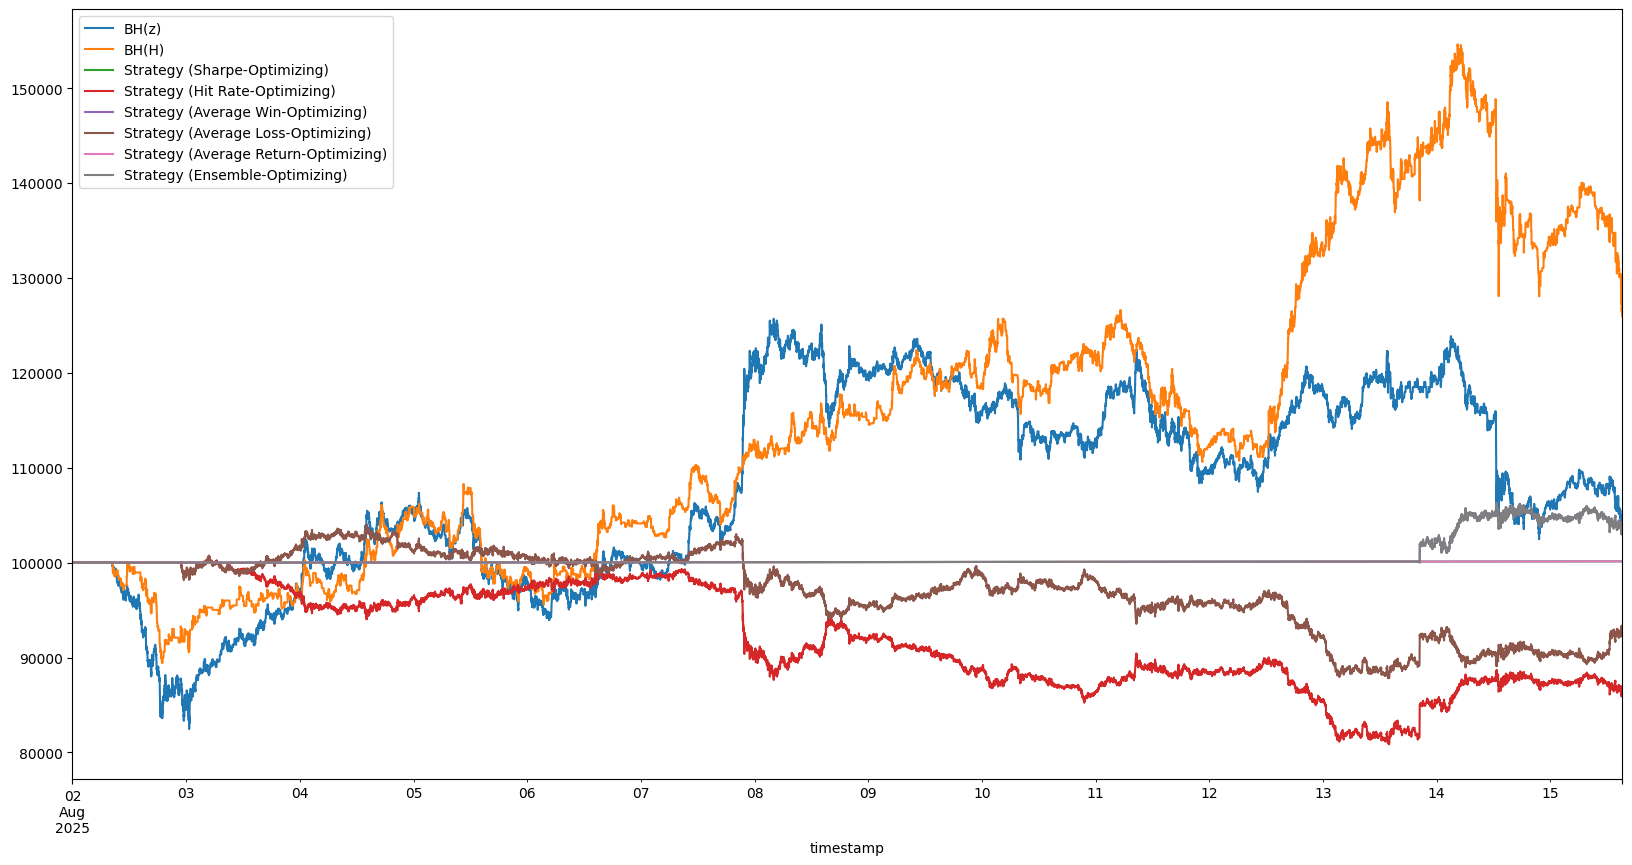

In [232]:
pair_train, pair_test = pair_SOL_XRP_train, pair_SOL_XRP_test

kf_ddivf(pair_train)

#classify states
pair_train['H Return'] = np.log1p(pair_train.iloc[:,0].pct_change())
pair_train['z Return'] = np.log1p(pair_train.iloc[:,1].pct_change())
pair_train['State'] = np.nan
hmm = mix.GaussianMixture(n_components=3, covariance_type="full", n_init=100, random_state=7).fit(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)
pair_train['State'][j+5:-1] = hmm.predict(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)
pair_train = pair_train.join(data_train['Daily RF Rate'])

p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S2_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S2_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S2_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S2_average_loss, p_opt_S0_average_return, p_opt_S1_average_return, p_opt_S2_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily RF Rate'])
back_test(pair_test)   

|   iter    |  target   |   p_S0    |   p_S1    |   p_S2    |
-------------------------------------------------------------
| 1         | -0.250148 | 26.952540 | 33.607574 | 29.110535 |
| 2         | -0.250148 | 26.795327 | 21.946191 | 30.835764 |
| 3         | -0.250148 | 22.503488 | 40.670920 | 43.546510 |
| 4         | -0.250148 | 20.337660 | 36.669001 | 26.155796 |
| 5         | -0.343768 | 27.721782 | 42.023865 | 7.8414423 |
| 6         | -0.250148 | 21.257980 | 37.786146 | 27.198088 |
| 7         | -0.239506 | 5.0       | 18.790646 | 44.608548 |
| 8         | -0.083710 | 5.0       | 5.0       | 21.533104 |
| 9         | -0.196930 | 5.0       | 5.0       | 6.4209978 |
| 10        | -0.083710 | 5.0       | 5.0       | 30.592611 |
| 11        | 0.2814092 | 14.176201 | 5.0       | 25.311518 |
| 12        | 0.3228522 | 20.022431 | 5.0       | 23.750214 |
| 13        | 0.3228522 | 21.125213 | 5.0       | 32.264083 |
| 14        | 0.3228522 | 38.601602 | 5.0       | 45.0      |
| 15    

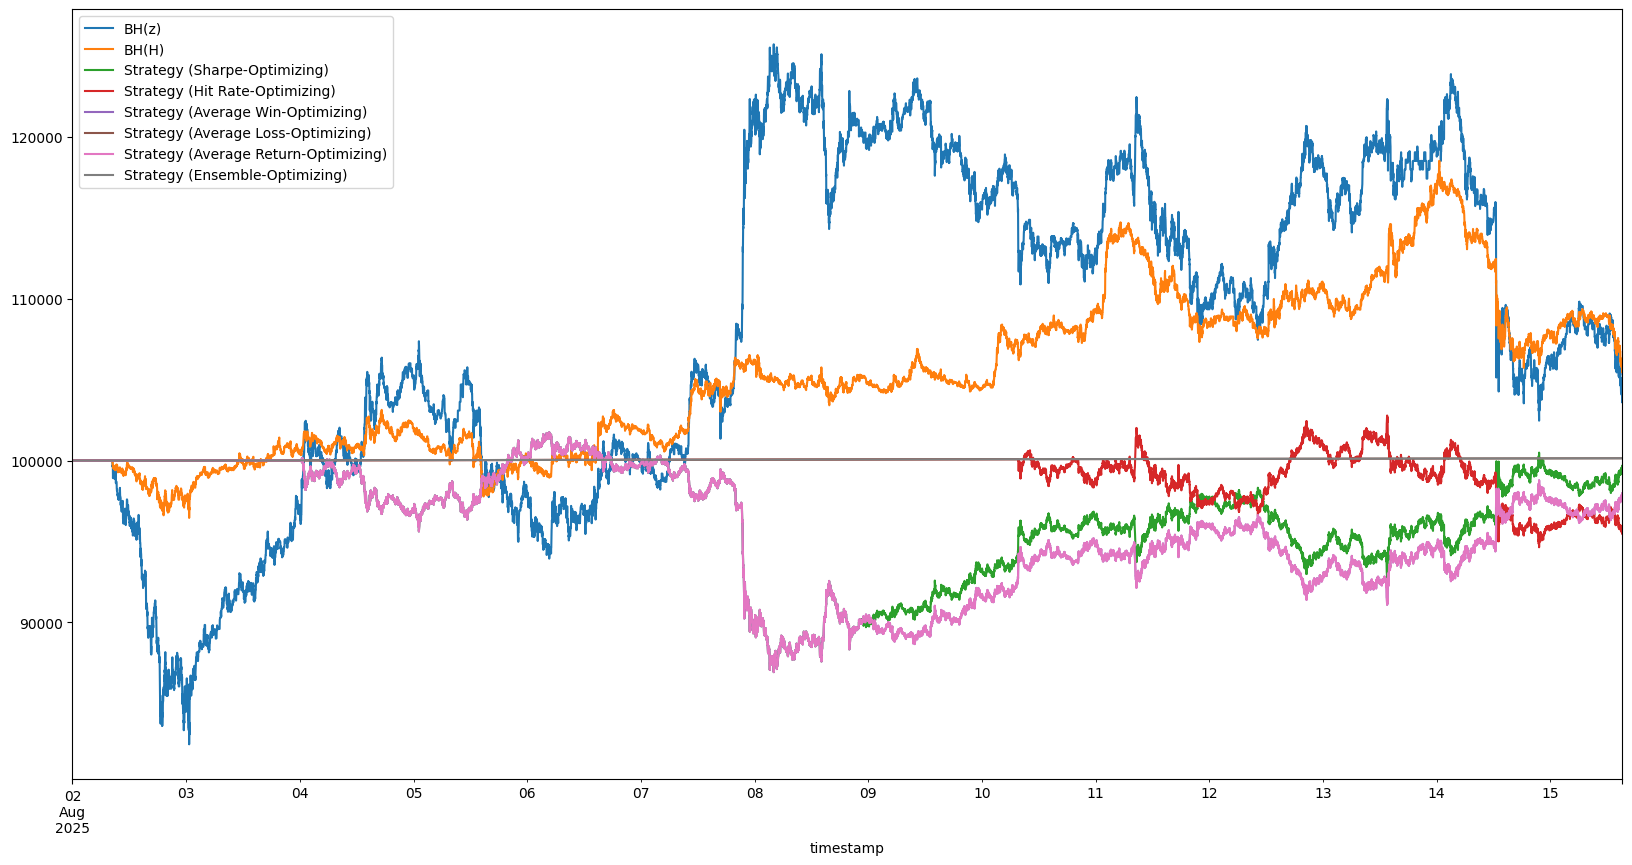

In [233]:
pair_train, pair_test = pair_BTC_XRP_train, pair_BTC_XRP_test

kf_ddivf(pair_train)

#classify states
pair_train['H Return'] = np.log1p(pair_train.iloc[:,0].pct_change())
pair_train['z Return'] = np.log1p(pair_train.iloc[:,1].pct_change())
pair_train['State'] = np.nan
hmm = mix.GaussianMixture(n_components=3, covariance_type="full", n_init=100, random_state=7).fit(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)
pair_train['State'][j+5:-1] = hmm.predict(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)
pair_train = pair_train.join(data_train['Daily RF Rate'])

p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S2_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S2_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S2_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S2_average_loss, p_opt_S0_average_return, p_opt_S1_average_return, p_opt_S2_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily RF Rate'])
back_test(pair_test)  

|   iter    |  target   |   p_S0    |   p_S1    |   p_S2    |
-------------------------------------------------------------
| 1         | -0.250148 | 26.952540 | 33.607574 | 29.110535 |
| 2         | -0.250148 | 26.795327 | 21.946191 | 30.835764 |
| 3         | -0.250148 | 22.503488 | 40.670920 | 43.546510 |
| 4         | -0.250148 | 20.337660 | 36.669001 | 26.155796 |
| 5         | -0.250148 | 27.721782 | 42.023865 | 7.8414423 |
| 6         | -0.157612 | 8.3498574 | 5.3744041 | 5.4478559 |
| 7         | -0.375927 | 23.258685 | 5.0       | 5.0       |
| 8         | -0.070600 | 6.2457538 | 5.0045754 | 5.2368356 |
| 9         | -0.208683 | 5.0       | 5.0       | 6.9645297 |
| 10        | 0.0142054 | 6.3394558 | 6.3255595 | 5.0       |
| 11        | -0.016225 | 5.5304635 | 7.5678439 | 5.0       |
| 12        | 0.0845504 | 7.5244258 | 8.4830982 | 5.0       |
| 13        | 0.0845504 | 8.1657097 | 10.828409 | 5.0       |
| 14        | -0.036306 | 10.944463 | 10.155997 | 5.0       |
| 15    

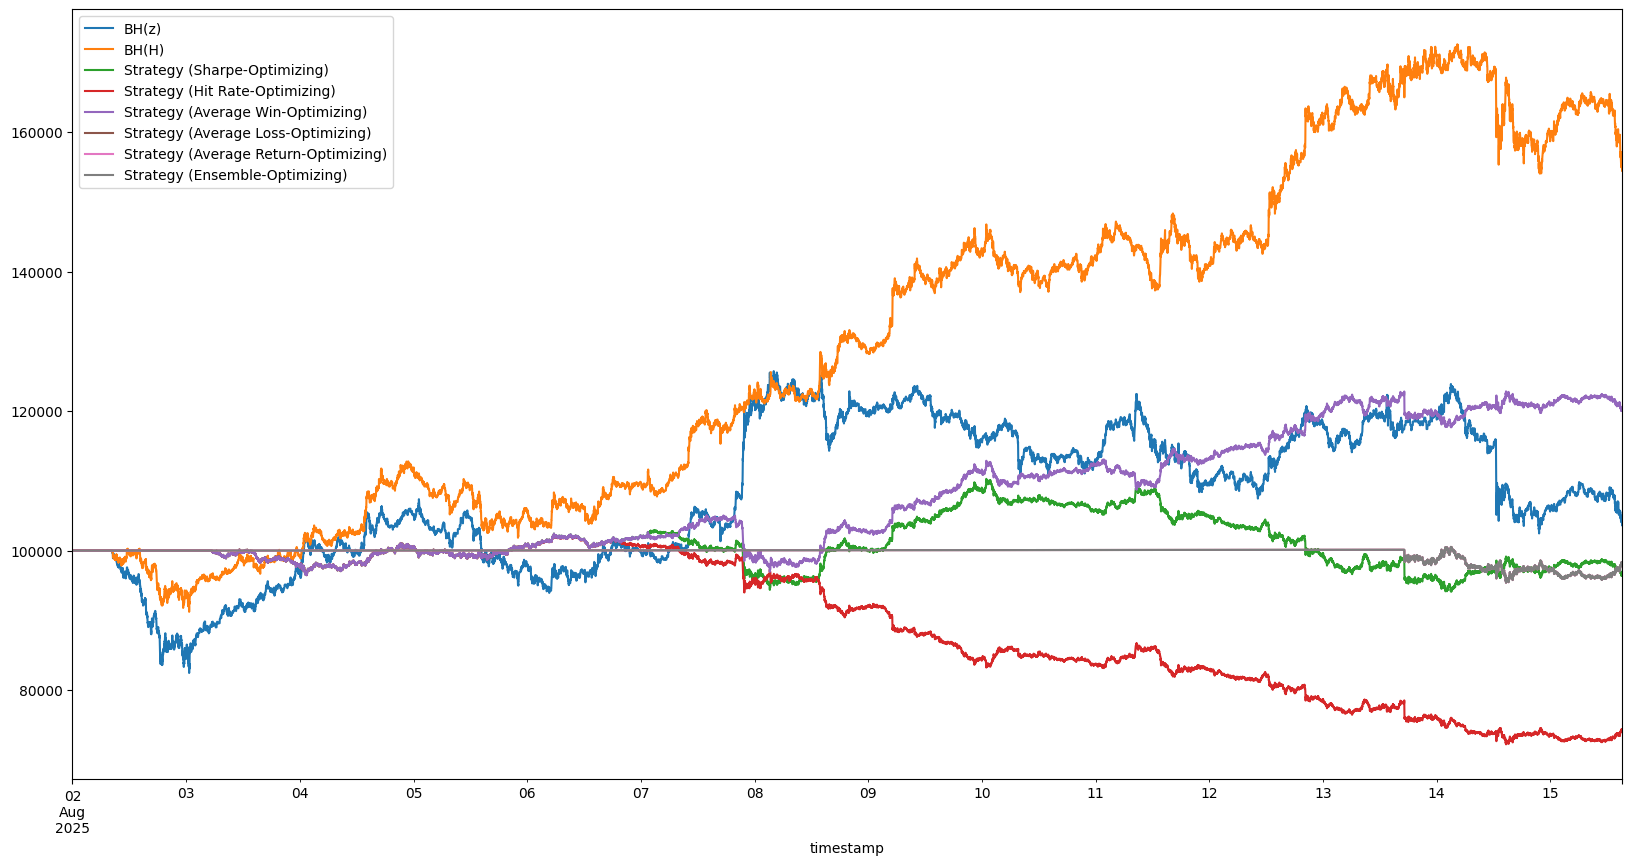

In [234]:
pair_train, pair_test = pair_ETH_XRP_train, pair_ETH_XRP_test

kf_ddivf(pair_train)

#classify states
pair_train['H Return'] = np.log1p(pair_train.iloc[:,0].pct_change())
pair_train['z Return'] = np.log1p(pair_train.iloc[:,1].pct_change())
pair_train['State'] = np.nan
hmm = mix.GaussianMixture(n_components=3, covariance_type="full", n_init=100, random_state=7).fit(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)
pair_train['State'][j+5:-1] = hmm.predict(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)
pair_train = pair_train.join(data_train['Daily RF Rate'])

p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S2_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S2_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S2_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S2_average_loss, p_opt_S0_average_return, p_opt_S1_average_return, p_opt_S2_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily RF Rate'])
back_test(pair_test) 

|   iter    |  target   |   p_S0    |   p_S1    |   p_S2    |
-------------------------------------------------------------
| 1         | -0.250148 | 26.952540 | 33.607574 | 29.110535 |
| 2         | -0.250148 | 26.795327 | 21.946191 | 30.835764 |
| 3         | -0.250148 | 22.503488 | 40.670920 | 43.546510 |
| 4         | -0.250148 | 20.337660 | 36.669001 | 26.155796 |
| 5         | 0.0032906 | 27.721782 | 42.023865 | 7.8414423 |
| 6         | 0.0059684 | 27.678190 | 42.353081 | 7.0584797 |
| 7         | -0.162613 | 45.0      | 45.0      | 5.0       |
| 8         | -0.162613 | 11.399597 | 45.0      | 5.0       |
| 9         | -0.162613 | 29.107003 | 30.026922 | 5.0       |
| 10        | 0.0130067 | 32.664803 | 45.0      | 10.731051 |
| 11        | -0.318063 | 45.0      | 5.0       | 45.0      |
| 12        | -0.278711 | 5.0       | 5.0       | 5.0       |
| 13        | -0.262454 | 5.0       | 5.0       | 45.0      |
| 14        | 0.0130067 | 25.943173 | 45.0      | 10.854851 |
| 15    

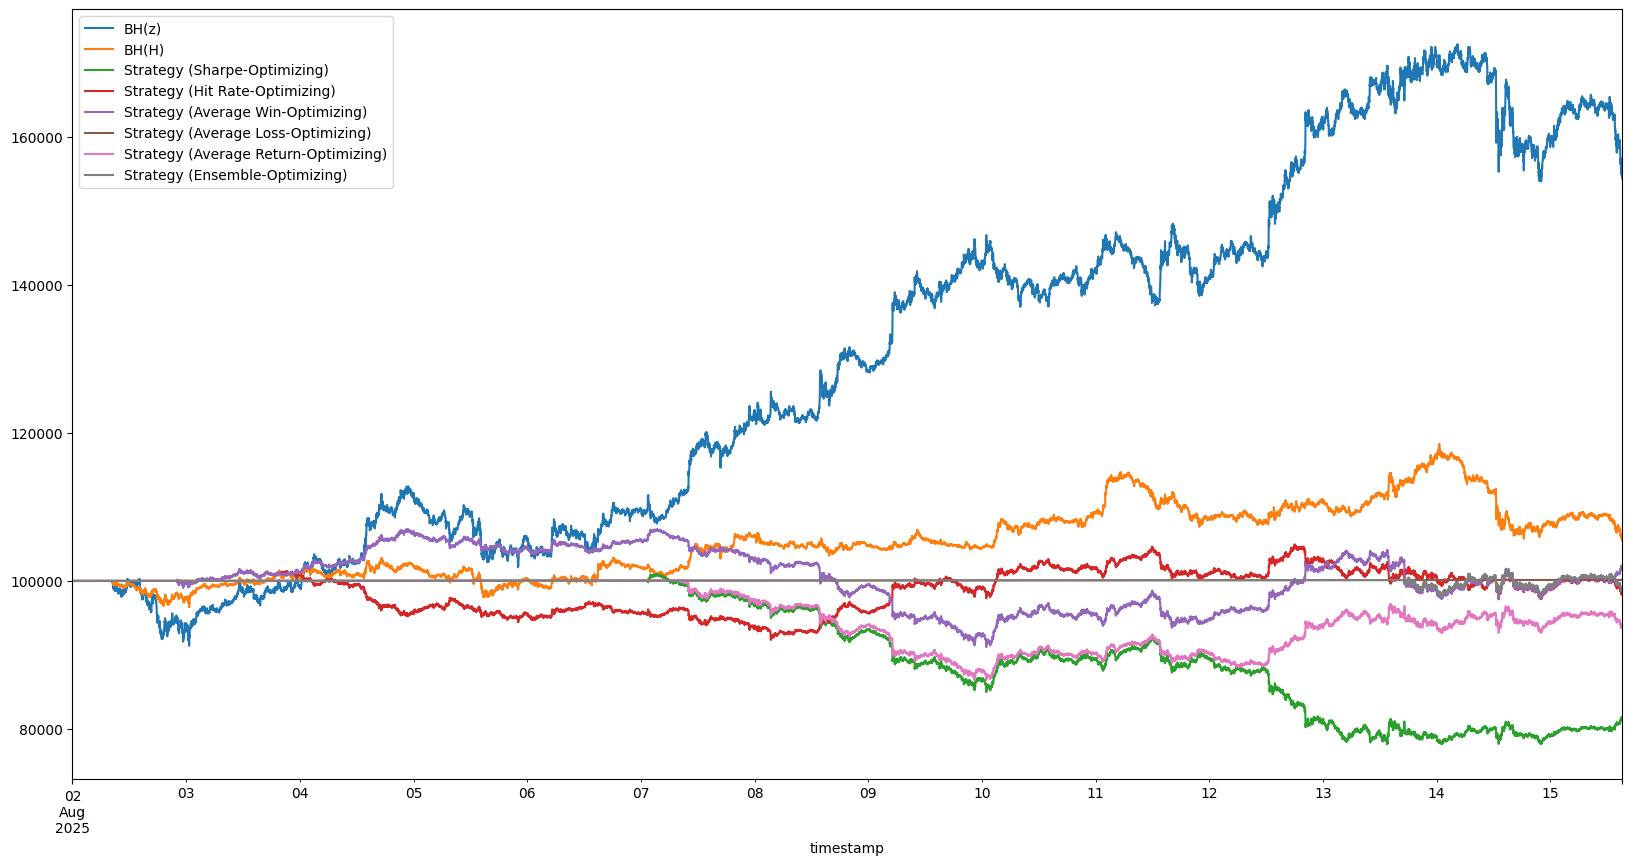

In [235]:
pair_train, pair_test = pair_BTC_ETH_train, pair_BTC_ETH_test

kf_ddivf(pair_train)

#classify states
pair_train['H Return'] = np.log1p(pair_train.iloc[:,0].pct_change())
pair_train['z Return'] = np.log1p(pair_train.iloc[:,1].pct_change())
pair_train['State'] = np.nan
hmm = mix.GaussianMixture(n_components=3, covariance_type="full", n_init=100, random_state=7).fit(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)
pair_train['State'][j+5:-1] = hmm.predict(pair_train.iloc[j+5:-1][['Innovation', 'H Return', 'z Return']].values)
pair_train = pair_train.join(data_train['Daily RF Rate'])

p_opt_S0_sharpe, p_opt_S1_sharpe, p_opt_S2_sharpe, p_opt_S0_hit_rate, p_opt_S1_hit_rate, p_opt_S2_hit_rate, p_opt_S0_average_win, p_opt_S1_average_win, p_opt_S2_average_win, p_opt_S0_average_loss, p_opt_S1_average_loss, p_opt_S2_average_loss, p_opt_S0_average_return, p_opt_S1_average_return, p_opt_S2_average_return = optimize_threshold(pair_train)
print(' ')
last_beta_0, last_beta_1 = pair_train.iloc[-1, 2], pair_train.iloc[-1, 3]
kf_ddivf_hmm_test(pair_test)
pair_test = pair_test.join(data_test['Daily RF Rate'])
back_test(pair_test)

In [28]:
def BM_test(pair_test):
# Construct Buy-and-Hold Strategy for comparision
  pair_test['Investment in H'] = 0.0
  pair_test['BH(H) Instant PnL'] = 0.0
  pair_test['BH(H)'] = E0
  pair_test['BH(H) Instant Return'] = 0.0
  pair_test['Cash'] = W0 - E0
  Q_H_begin_BH = min(200000.0, Delta_max * pair_test['BH(H)'][init])
  
  for t in range(init, pair_test.shape[0] - 1):
      ## GENERATE INSTANT PNL
      E = pair_test['BH(H)'][t]
      # Refill if falls below zero
      if E < 0:
          refill = min(E0 - E, pair_test['Cash'][t])
          pair_test['Cash'][t] = pair_test['Cash'][t] - refill
          E = pair_test['BH(H)'][t] + refill
      pair_test['Cash'][t + 1] = pair_test['Cash'][t]
      r = pair_test['Daily RF Rate'][t] / (24 * 60)
      R_H = (pair_test.iloc[:, 0][t] / pair_test.iloc[:, 0][t - 1]) - 1
      # Trade the minimum of $200,000 and maximum leverage
      Q_H = pair_test['Investment in H'][t - 1]
      if t == init:
          Q_H_new = Q_H_begin_BH
      else:
          Q_H_new = Q_H * (1 + R_H)
      pair_test['Investment in H'][t] = Q_H_new
  
      if t == init:
          instant_pnl = (Q_H * R_H) + r * (E - Q_H_begin_BH) - delta_r * abs(Q_H_begin_BH) - epsilon * (abs(Q_H_begin_BH))
      elif t == pair_test.shape[0] - 2:
          instant_pnl = (Q_H * R_H) - epsilon * (abs(Q_H))
      else:
          instant_pnl = (Q_H * R_H) + r * (E - Q_H_begin_BH) - delta_r * abs(Q_H_begin_BH)
  
      pair_test['BH(H) Instant PnL'][t] = instant_pnl
  
      ## GAIN PNL
      pair_test['BH(H)'][t + 1] = E + instant_pnl
      pair_test['BH(H) Instant Return'][t + 1] = instant_pnl / E
  
  pair_test['BH(H)'] = pair_test['BH(H)'] + pair_test['Cash'] - W0 + E0
  pair_test = pair_test.drop(['Investment in H', 'Cash'], axis=1)
  
  # Extract date
  pair_test['date_only'] = pair_test.index.date
  
  # Group by date
  daily_pnl = pair_test.groupby('date_only')['BH(H) Instant PnL'].sum()
  daily_strategy_first = pair_test.groupby('date_only')['BH(H)'].first()
  
  # Calculate daily return
  daily_return = daily_pnl / daily_strategy_first
  
  # Combine into a new DataFrame
  daily_summary = pd.DataFrame({
      'BH(H) Daily PnL': daily_pnl,
      'BH(H) Daily Return': daily_return
  })
  
  # Merge back to the original DataFrame
  pair_test = pair_test.merge(daily_summary, left_on='date_only', right_index=True, how='left')
  
  # Step 1: Slice first
  df_sliced = pair_test[init:].copy()
  
  # Step 2: Ensure datetime index
  df_sliced.index = pd.to_datetime(df_sliced.index)
  
  # Step 3: Drop duplicates to keep one row per day (first row of each date)
  df_daily = df_sliced[~df_sliced.index.normalize().duplicated(keep='first')]
  
  # Step 4: Compute Sharpe components
  average_return = df_daily['BH(H) Daily Return'].mean() 
  excess_returns = df_daily['BH(H) Daily Return'] - df_daily['Daily RF Rate']
  volatility = df_daily['BH(H) Daily Return'].std() 
  sharpe = excess_returns.mean()  / volatility
  pair_test = pair_test.drop(['BH(H) Daily PnL', 'BH(H) Daily Return', 'date_only'], axis=1)
  
  print(f"average_return : {average_return}")
  print(f"volatility : {volatility}")
  print('Sharpe Ratio (BH(H)):', sharpe)
  
  pair_test['Investment in z'] = 0.0
  pair_test['BH(z) Instant PnL'] = 0.0
  pair_test['BH(z)'] = E0
  pair_test['BH(z) Instant Return'] = 0.0
  pair_test['Cash'] = W0 - E0
  Q_z_begin_BH = min(200000.0, Delta_max * pair_test['BH(z)'][init])
  
  for t in range(init, pair_test.shape[0] - 1):
  
      ## GENERATE INSTANT PNL
      E = pair_test['BH(z)'][t]
      # Refill if falls below zero
      if E < 0:
          refill = min(E0 - E, pair_test['Cash'][t])
          pair_test['Cash'][t] = pair_test['Cash'][t] - refill
          E = pair_test['BH(z)'][t] + refill
      pair_test['Cash'][t + 1] = pair_test['Cash'][t]
      r = pair_test['Daily RF Rate'][t] / (24 * 60)
      R_z = (pair_test.iloc[:, 1][t] / pair_test.iloc[:, 1][t - 1]) - 1
      # Trade the minimum of $200,000 and maximum leverage
      Q_z = pair_test['Investment in z'][t - 1]
      if t == init:
          Q_z_new = Q_z_begin_BH
      else:
          Q_z_new = Q_z * (1 + R_z)
      pair_test['Investment in z'][t] = Q_z_new
  
      if t == init:
          instant_pnl = (Q_z * R_z) + r * (E - Q_z_begin_BH) - delta_r * abs(Q_z_begin_BH) - epsilon * (abs(Q_z_begin_BH))
      elif t == pair_test.shape[0] - 2:
          instant_pnl = (Q_z * R_z) - epsilon * (abs(Q_z))
      else:
          instant_pnl = (Q_z * R_z) + r * (E - Q_z_begin_BH) - delta_r * abs(Q_z_begin_BH)
  
      pair_test['BH(z) Instant PnL'][t] = instant_pnl
  
      ## GAIN PNL
      pair_test['BH(z)'][t + 1] = E + instant_pnl
      pair_test['BH(z) Instant Return'][t + 1] = instant_pnl / E
  
  pair_test['BH(z)'] = pair_test['BH(z)'] + pair_test['Cash'] - W0 + E0
  pair_test = pair_test.drop(['Investment in z', 'Cash'], axis=1)
  
  # Extract date
  pair_test['date_only'] = pair_test.index.date
  
  # Group by date
  daily_pnl = pair_test.groupby('date_only')['BH(z) Instant PnL'].sum()
  daily_strategy_first = pair_test.groupby('date_only')['BH(z)'].first()
  
  # Calculate daily return
  daily_return = daily_pnl / daily_strategy_first
  
  # Combine into a new DataFrame
  daily_summary = pd.DataFrame({
      'BH(z) Daily PnL': daily_pnl,
      'BH(z) Daily Return': daily_return
  })
  
  # Merge back to the original DataFrame
  pair_test = pair_test.merge(daily_summary, left_on='date_only', right_index=True, how='left')
  
  # Step 1: Slice first
  df_sliced = pair_test[init:].copy()
  
  # Step 2: Ensure datetime index
  df_sliced.index = pd.to_datetime(df_sliced.index) 
  
  # Step 3: Drop duplicates to keep one row per day (first row of each date)
  df_daily = df_sliced[~df_sliced.index.normalize().duplicated(keep='first')]
  
  # Step 4: Compute Sharpe components
  average_return = df_daily['BH(z) Daily Return'].mean() 
  excess_returns = df_daily['BH(z) Daily Return'] - df_daily['Daily RF Rate']
  volatility = df_daily['BH(z) Daily Return'].std() 
  sharpe = excess_returns.mean() / volatility
  pair_test = pair_test.drop(['BH(z) Daily PnL', 'BH(z) Daily Return', 'date_only'], axis=1)
  
  print(f"average_return : {average_return}")
  print(f"volatility : {volatility}")
  print('Sharpe Ratio (BH(z)):', sharpe)

  pair_test[['BH(z)', 'BH(H)']].plot(figsize=(20, 10))
  plt.show()